In [1]:
import notebook
notebook.nbextensions.check_nbextension('usability/codefolding', user=True)
notebook.nbextensions.check_nbextension('usability/codefolding/main.js', user=True)
# E = notebook.nbextensions.EnableNBExtensionApp()
# E.enable_nbextension('usability/codefolding/main')

False

In [2]:
import sys
sys.path.append('../')
sys.path.append('../nswe')

import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
%matplotlib notebook

nan = float('nan')

In [3]:
import generalFunctions as gF
import cnoidal
import nswe
import muscl2


In [4]:
%%writefile serre.py
## Numerical resolution of the Serre equations
import numpy as np
import matplotlib.pyplot as plt
import math
import generalFunctions as gF
import cnoidal
import nswe
import muscl2



Overwriting serre.py


$\newcommand{\th}{\tilde{h}}$
$\newcommand{\tu}{\tilde{u}}$

$\newcommand{\lh}{\overline{h}}$
$\newcommand{\lu}{\overline{u}}$

$\newcommand{\Atwo}[2]{\left( \begin{array}{c} #1 \\ #2  \end{array} \right)}$

# Numerical resolution of the Serre equations

## The model

The Serre equations are a model to describe higly nonlinear waves propagating in shallow waters. Considering a horizontal bottom, these equations are written as

\begin{equation}
\label{eq:SerreFull}
h_t + (hu)_x = 0 \\
u_t + uu_x + gh_x - \frac{1}{3h}\left(h^3 \left( u_{xt} + uu_{xx} - (u_x)^2  \right) \right)_x = 0
\end{equation}

where $u = u(x,t)$, $h = h(x,t)$ and $g$ are, respectively, the depth-averaged horizontal velocity of the fluid, the water depth and the gravity acceleration.

## Discretization

As done previously for the numerical resolution of the KdV and the BBM equations, the Serre equations will be numerically solved using a splitting method, in which the system of equations will be decomposed in two : the first one will contain the advection terms, and the second one, all the high-order derivative terms.

Therefore, the numerical resolution will consist in solve, in each time step $[t_n, t_{n+1}]$, the following problem :

\begin{equation}
\label{eq:SerreSplit1}
\begin{cases}
\th_t + \left(\th\tu\right)_x = 0 \\
\tu_t + \tu\tu_x + g\th_x = 0, \ \, t \in [t_n, t_{n+1}], \ \  (\th,\tu)(x,t_n) = (h,u)(x,t_n)
\end{cases}
\end{equation}

\begin{equation}
\label{eq:SerreSplit2}
\begin{cases}
\lh_t   = 0 \\
\lu_t - \frac{1}{3\lh}\left(\lh^3 \left( \lu_{xt} + \lu\lu_{xx} - (\lu_x)^2  \right) \right)_x = 0, \ \, t \in [t_n, t_{n+1}], \ \  (\lh,\lu)(x,t_n) = (\th,\tu)(x,t_{n+1})
\end{cases}
\end{equation}

\begin{equation}
\begin{cases}
(h,u)(x,t_{n+1}) = (\lh,\lu)(x,t_{n+1})
\end{cases}
\end{equation}

In the following descriptions of the resolution of the two schemes, the tilde and the overbar will be omitted for the sake of clarity.

### First system of equations

In order to solve the advection system (\ref{eq:SerreSplit1}) with the Roe solver (an approximation of the Riemman solver), one must write it in the classical form $U_t +  F(U)_x = 0$, where $U$ is the vector of unknowns and $F$ is a flux function.

We have that

$(hu)_t = uh_t + hu_t = -u(hu)_x - h\left(uu_x + gh_x\right) = -u\left (h_xu + 2hu_x \right) - ghh_x = -\left(hu^2\right)_x - \frac{1}{2}g\left(h^2\right)_x = - \left(hu^2 +  \frac{1}{2}gh^2 \right)_x$

Therefore, the system can be rewritten as

\begin{equation}
\begin{cases}
h_t + \left(hu \right)_x = 0 \\
\left(hu \right)_t + \left(hu^2 +  \frac{1}{2}gh^2 \right)_x = 0
\end{cases}
\end{equation}

and we will solve it for the unknowns $U = \Atwo{h}{hu}$, with the flux function $F \Atwo{h}{hu} = \Atwo{hu}{hu^2 +  \frac{1}{2}gh^2} $. The time step is discretized using a 4th order Runge-Kutta scheme.

### Second system of equations

In the second system (\ref{eq:SerreSplit2}) of the splitted Serre equations , the water depth $h$ is constant in time, and therefore only the velocity $u$ must be updated. Separating the terms containing time derivatives, the second equation of thi suystem can be rewritten as 

\begin{equation}
\label{eq:dispersive}
\left( u - hh_xu_x - \frac{1}{3}h^2u_{xx} \right)_t  - \frac{1}{3h}\left(h^3 \left( uu_{xx} - (u_x)^2  \right) \right)_x = 0
\end{equation}

This equation will be solved using an explicit Finite Difference scheme. Defining

$g_1 = h^3 \left( uu_{xx} - (u_x)^2 \right)$

$g_2 = u - h h_x u_x - \frac{1}{3}h^2 u_{xx}$

where the derivatives are evalueated using appropriate finite difference approximations.

With this notation, using an one-step forward time discretization, one gets

$(g_2)_i^{n+1} = (g_2)_i^n + \frac{\Delta t}{3h_i^n} \left(\left( g_1 \right)_x\right)_i^n = G_i^n$

where the superscript and the subscript denotes respectively the time step and the spatial position.

Using 2nd order centered approximation for the spatial derivatives in $(g_2)_i^{n+1}$, one gets the following tridiagonal linear system :

$\left( \frac{h_i^n(h_x)_i^n}{2\Delta x} - \frac{(h_i^n)^2}{3\Delta x^2} \right)u_{i-1}^{n+1} + 
 \left( 1 + \frac{2(h_i^n)^2}{3\Delta x^2} \right)u_{i}^{n+1} + 
 \left( -\frac{h_i^n(h_x)_i^n}{2\Delta x} - \frac{(h_i^n)^2}{3\Delta x^2} \right)u_{i+1}^{n+1} = G_i^n $
 
 with the appropriate modifications to take in account the boundary conditions.
 
 
 ### Alternative resolution of the second system (for the variables $(h,hu)$)
 
 Inspired by the discretization described in the paper of Bonneton et. al (2011), we will rewrite the second system of equations obtained in the splitting of the Serre equations, in order to solve it in the variables $(h,hu)$ and thus keep the formulation of the first system.
 
 For this purpose, we will multiply the equation (\ref{eq:dispersive}) and write the variable $u$ inside the time derivative as $\frac{1}{h} hu$ :
 
 \begin{equation}
\label{eq:dispersive2}
\left( hu - h^2h_x \left( \frac{1}{h} hu \right)_x - \frac{1}{3}h^3\left( \frac{1}{h} hu \right)_{xx} \right)_t  - \frac{1}{3}\left(g_1 \right)_x = 0
\end{equation}

Developing the spatial derivatives in (\ref{eq:dispersive2}), we get

\begin{equation}
\label{eq:dispersive3}
       \left( 1-h^2 - \frac{h^3}{h_{xx}} \right)(hu) + \left( -hh_x - \frac{2h^3}{3h_{x}} \right)(hu)_x + \left( - \frac{h^2}{3} \right)(hu)_{xx} - \frac{1}{3}\left(g_1 \right)_x = 0
\end{equation}

which can be written as

\begin{equation}
    \tilde{T} (hu)_t = \frac{1}{3}\left(g_1 \right)_x \rightarrow (hu)_t = \tilde{T}^{-1}\left(\frac{1}{3}\left(g_1 \right)_x\right)
\end{equation}

where $\tilde{T} = 1 + hT\frac{1}{h} $

and $T$ is an operator defined by Bonneton et al and given by (in the 1D case)

\begin{equation}
   Tw = -\frac{h^2}{3}w_{xx} - hh_xw_x
\end{equation}

Therefore, for each $i=1,...N-1$, the actualization of the solution in time is given by

\begin{equation}
(hu)_i^{n+1} = (hu)_i^n + \Delta t z_i^n
\end{equation}

where $Z = (z_1,z_2,...,z_{n+1})^T$ is solution of $\tilde{T}Z = \frac{1}{3}\left(g_1 \right)_x$. The left side of this system has the form

\begin{equation}
h\frac{z}{h} - h^2h_x \left( \frac{z}{h} \right)_x - \frac{1}{3}h^3\left( \frac{z}{h}\right)_{xx}
\end{equation}

which is solved in the variable $z/h$ (in order to avoid divisions by spatial derivatives of $h$, that can be equal to zero), leading to the 2nd order discretization

$\left( \frac{h_i^n(h_x)_i^n}{2\Delta x} - \frac{(h_i^n)^2}{3\Delta x^2} \right)  \left( \frac{z}{h} \right)_{i-1}^{n+1} + 
 \left( 1 + \frac{2(h_i^n)^2}{3\Delta x^2} \right)\left( \frac{z}{h} \right)_{i}^{n+1} + 
 \left( -\frac{h_i^n(h_x)_i^n}{2\Delta x} - \frac{(h_i^n)^2}{3\Delta x^2} \right)\left( \frac{z}{h} \right)_{i+1}^{n+1} = \frac{1}{3} \left(\left( g_1 \right)_x\right)_i^n $

 
 ### Boundary conditions
 
 We describe briefly the imposition of boundary conditions to each one of the steps of the splitted Serre equations. 

 
 #### First step
  The spatial domain is discretized in $N+1$ points, homogeneously distributed and numbered from $0$ to $N$. In the resolution of the first step of the splitted Serre equations by the Finite Volume method, these points act as center of the cells (with the average value of the solution in the cell equal to its value on the respective point), and the first and last point are used as ghost cells. Therefore, the solution is effectively computed on the points $x_1,...,x_{N-1}$.
 
For the first step, the boundary conditions are imposed on the interface points $x_{1/2} = \frac{x_0 + x_1}{2}$ and $x_{N-1/2} = \frac{x_{N-1} + x_N}{2}$ with the following generic Robin conditions, for the variables $h$ and $hu$ :

$\alpha_L^h h(x_{1/2},t) + \beta_L^h h_x(x_{1/2},t) = \sigma_L^h(t)$

$\alpha_R^h h(x_{N-1/2},t) + \beta_R^h h_x(x_{N-1/2},t) = \sigma_R^h(t)$

$\alpha_L^{hu} h(x_{1/2},t) + \beta_L^{hu} h_x(x_{1/2},t) = \sigma_L^{hu}(t)$

$\alpha_R^{hu} h(x_{N-1/2},t) + \beta_R^{hu} h_x(x_{N-1/2},t) = \sigma_R^{hu}(t)$

Considering that the computation is made only on the cells' centers, the values of the solutions and its derivative on the interfaces will be approximated by

$h(x_{1/2},t) = \frac{h(x_0) + h(x_1)}{2}$

$h_x(x_{1/2},t) = \frac{h(x_1) - h(x_0)}{\Delta x}$

and similarly to the right boundary and the variable $hu$.

Replacing these approximations in the Robin boundary conditions, we obtain the values that must be imposed in the ghost cells :

$h_0 = \frac{\sigma_L^h(t) - \left(\frac{\alpha_L^h}{2} +\frac{\beta_L^h}{\Delta x} \right)h_1}{\frac{\alpha_L^h}{2} - \frac{\beta_L^h}{\Delta x}}$

$h_N = \frac{\sigma_R^h(t) - \left(\frac{\alpha_R^h}{2} - \frac{\beta_R^h}{\Delta x} \right)h_{N+1}}{\frac{\alpha_L^h}{2} + \frac{\beta_R^h}{\Delta x}}$

and similarly to the variable $hu$.

As special cases, these Robin conditions naturally degenerate to Dirichlet, $(\alpha,\beta) = (1,0)$, and Neumann, with $(\alpha,\beta) = (0,1)$. As expected, in the case of homogeneous conditions ($\sigma_\bullet^\bullet$), these coefficients conduct to $h_0 = -h_1$ (in the Dirichlet case) and $h_0 = h_1$ (in the Neumann case), and simirlarly to the right boundary and the variable $hu$.

As a last remark concerning the boundary equations in the first step of the Serre equations, in order to simulate an open and an closed boundary, one could impose the following conditions : 

* Open boundary : Homogeneous Neumann for $h$ and $hu$ 
* Closed boundary : Homogeneous Neumann for $h$ and homogeneous Dirichlet for $hu$

#### Second step

In order to keep the same approach as adopted in the first step of the Serre equations, for the second one we will continue computing the boundary conditions in the interfaces $x_{1/2}$ and $x_{N-1/2}$, even if these points are not used in the finite difference scheme.

Therefore, we must approximate the value of the solution and its derivatives on these interfaces. Similarly to the approximations made in the finite volume scheme, we compute

$h(x_{1/2},t) = \frac{h(x_0) + h(x_1)}{2}$

$h_x(x_{1/2},t) = \frac{h(x_1) - h(x_0)}{\Delta x}$

$h_{xx}(x_{1/2},t) = \frac{h(x_0) - 2h(x_1) + h(x_2)}{\Delta x^2}$

and similarly to the interface $x_{N-1/2}$


For the two steps of the Serre equations, higher-order approximations to the values on the interfaces could be used. For his purpose, one should write Taylor expansions around the point $x_0$ (for example, up to $O(\Delta x^2)$): 

$h(x_{1/2},t) = h(x_0) + h_x(x_0)\frac{\Delta x}{2} + h_{xx}(x_0)\frac{\Delta x^2}{8} + O(\Delta x^2)$

$h_x(x_{1/2},t) = h_x(x_0) + h_{xx}(x_0)\frac{\Delta x}{2} + h_{xxx}(x_0)\frac{\Delta x^2}{8} + O(\Delta x^2)$

$h_{xx}(x_{1/2},t) = h_{xx}(x_0) + h_{xxx}(x_0)\frac{\Delta x}{2} + h_{xxxx}(x_0)\frac{\Delta x^2}{8} + O(\Delta x^2)$

In [5]:
%%writefile serre.py -a

## Impose periodicity to ng ghost cells
def imposePeriodicity(v,ng) :
    for i in range(ng) :
        v[0+i] = v[-2*ng+i]
        v[-1-i] = v[2*ng-(i+1)]
    return v

Appending to serre.py


In [6]:
%%writefile serre.py -a

## Create an array with nx points in [xmin,xmax)
def discretizeSpace(xmin,xmax,nx):
    dx = (xmax-xmin)/nx
    x = np.arange(xmin,xmax,dx)
    
    return x,dx

Appending to serre.py


##### FUNCTIONS TO IMPOSE BOUNDARY CONDITIONS FOR THE FV SCHEME

In [7]:
%%writefile serre.py -a

## Impose Robin conditions to FV scheme, 1st order
## u_{1/2} = (u_0 + u_1)/2
## u_x_{1/2} = (u_1 - u_0)/dx
def robinBC1(h,hu,BC,dx,t):
    
    ### Generic Robin conditions
    ### BC[0] = BC[4]*u + BC[5]*ux ## hLeft
    ### BC[1] = BC[6]*u + BC[7]*ux ## huLeft
    ### BC[2] = BC[8]*u + BC[9]*ux ## hRight
    ### BC[3] = BC[10]*u + BC[11]*ux ##huRight
    
    hb = 1.*h
    hub = 1.*hu
    
    denLh = BC[4]/2. - BC[5]/dx
    denLhu = BC[6]/2. - BC[7]/dx
    denRh = BC[8]/2. + BC[9]/dx
    denRhu = BC[10]/2. + BC[11]/dx
    
    hb[0] = (BC[0] - (BC[4]/2. + BC[5]/dx)*h[1])/denLh
    hub[0] = (BC[1] - (BC[6]/2. + BC[7]/dx)*hu[1])/denLhu
    hb[-1] = (BC[2] - (BC[8]/2. - BC[9]/dx)*h[-2])/denRh
    hub[-1] = (BC[3] - (BC[10]/2. - BC[11]/dx)*hu[-2])/denRhu  
    return hb,hub

Appending to serre.py


In [8]:
%%writefile serre.py -a

## BC for a closed domain with 1 ghost cell
## The function robinBC1 can do the same with BC = [0.,0.,0.,0.,0.,1.,1.,0.,0.,1.,1.,0.]
def closedDomain(h,hu,t):
    hb = 1.*h
    hub = 1.*hu
    hb[0] = h[1]
    hub[0] = -hu[1]
    hb[-1] = h[-2]
    hub[-1] = -hu[-2]    
    return hb,hub

Appending to serre.py


In [9]:
%%writefile serre.py -a

## BC for a closed domain with 2 ghost cells
## The function robinBC1 CANNOT do the same
def closedDomainTwoGC(h,hu,BC,dx,t):
    hb = 1.*h
    hub = 1.*hu
    hb[0] = h[2]
    hub[0] = -hu[2]
    hb[1] = h[2]
    hub[1] = -hu[2]
    
    hb[-1] = h[-3]
    hub[-1] = -hu[-3]
    hb[-2] = h[-3]
    hub[-2] = -hu[-3]    
    return hb,hub

Appending to serre.py


In [10]:
%%writefile serre.py -a

## BC for an open domain
## The function robinBC1 can do the same with BC = [0.,0.,0.,0.,0.,1.,0.,1.,0.,1.,0.,1.]
def openDomain(h,hu,BC,dx,t):
    hb = 1.*h
    hub = 1.*hu
    hb[0] = h[1]
    hub[0] = hu[1]
    hb[-1] = h[-2]
    hub[-1] = hu[-2]    
    return hb,hub

Appending to serre.py


In [11]:
%%writefile serre.py -a

## BC for an open domain with 2 ghost cells
## The function robinBC1 can do the same with BC = [0.,0.,0.,0.,0.,1.,0.,1.,0.,1.,0.,1.]
def openDomain2GC(h,hu,BC,dx,t):
    hb = 1.*h
    hub = 1.*hu
    hb[0] = h[2]
    hb[1] = h[2]
    hub[0] = hu[2]
    hub[1] = hu[2]
    hb[-1] = h[-3]
    hb[-2] = h[-3]
    hub[-1] = hu[-3]    
    hub[-2] = h[-3]
    return hb,hub

Appending to serre.py


In [12]:
%%writefile serre.py -a

## BC for an open domain with 2 ghost cells
## The function robinBC1 can do the same with BC = [0.,0.,0.,0.,0.,1.,0.,1.,0.,1.,0.,1.]
def openDomain0GC(h,hu,BC,dx,t):
    return h,hu

Appending to serre.py


In [13]:
%%writefile serre.py -a

## Impose periodic BC for 1 ghost cell in the FV scheme
## The function robinBC1 CANNOT do the same
def periodicDomain(h,hu,BC,dx,t):
    hb = 1.*h
    hub = 1.*hu
    hb[0] = h[-2]
    hub[0] = hu[-2]
    hb[-1] = h[1]
    hub[-1] = hu[1]    
    return hb,hub

Appending to serre.py


In [14]:
%%writefile serre.py -a

## Impose periodic BC for 2 ghost cells in the FV scheme
## The function robinBC1 CANNOT do the same 
def periodicDomainTwoGC(h,hu,BC,dx,t):
    hb = 1.*h
    hub = 1.*hu
    
    hb[0] = h[-4]
    hub[0] = hu[-4]
    hb[-1] = h[3]
    hub[-1] = hu[3]
    
    hb[1] = h[-3]
    hub[1] = hu[-3]
    hb[-2] = h[2]
    hub[-2] = hu[2]
    
    return hb,hub

Appending to serre.py


##### FV SCHEME

In [15]:
import nswe_wbmuscl4 as wb4
def fluxes_periodic(h,hu,n,periodic, ng):
    
    ## first, we remove the ghost cells
    nx = h.shape[0]-2*ng
    ## then we add 3 cells on each side for the muscle scheme
    h0 = np.zeros(nx+6)
    u0 = np.zeros(nx+6)
    d0 = np.zeros(nx+6)
    h0[3:-3] = h[ng:len(h)-ng]
    u0[3:-3] = hu[ng:len(hu)-ng] #hu
    u0 = np.where(h0>1e-10,u0/h0,h0) #hu/h
    
    if periodic:
        h0[:3] = h0[-6:-3]
        h0[-3:] = h0[3:6]
        u0[:3] = u0[-6:-3]
        u0[-3:] = u0[3:6]
        
    else:
        h0[:3]  = h0[3:6]
        h0[-3:] = h0[-6:-3]
        u0[:3]  = u0[3:6]
        u0[-3:] = u0[-6:-3]
    
    fp, fm, sc = wb4.fluxes_sources(d0,h0,u0)
    return fp

In [16]:
%%writefile serre.py -a

# compute any of the RK4 coefficients (k_i)
def getRK4coef(x,uA,uB,f,dx,dt,nx,periodic,ng):
    F = f(uA,uB,nx,periodic,ng)
    return -dt/dx*(F[0,1:] - F[0,:-1]), -dt/dx*(F[1,1:] - F[1,:-1])

# complete the vector of RK4 coefficients with zeros in the ghost cells (to perform the sum u  + k_i)
def extend2GhostCells(v,ng):
    return np.concatenate((np.zeros(ng),v,np.zeros(ng)))

# RK4 for one time step
def RK4(x,uA,uB,f,bcf,bcp,dx,dt,nx,t,periodic,ng):
        
    uuA = np.copy(uA)
    uuB = np.copy(uB)
    uuA,uuB = bcf(uuA,uuB,bcp,dx,t)
    k1A,k1B = getRK4coef(x,uuA,uuB,f,dx,dt,nx,periodic,ng)
    k1A = extend2GhostCells(k1A,ng)
    k1B = extend2GhostCells(k1B,ng)

    uuA = uA+k1A/2.
    uuB = uB+k1B/2.
    uuA,uuB = bcf(uuA,uuB,bcp,dx,t)
    k2A,k2B = getRK4coef(x,uuA,uuB,f,dx,dt,nx,periodic,ng)
    k2A = extend2GhostCells(k2A,ng)
    k2B = extend2GhostCells(k2B,ng)

    uuA = uA+k2A/2.
    uuB = uB+k2B/2.
    uuA,uuB = bcf(uuA,uuB,bcp,dx,t)
    k3A,k3B = getRK4coef(x,uuA,uuB,f,dx,dt,nx,periodic,ng)
    k3A = extend2GhostCells(k3A,ng)
    k3B = extend2GhostCells(k3B,ng)

    uuA = uA+k3A
    uuB = uB+k3B
    uuA,uuB = bcf(uuA,uuB,bcp,dx,t)
    k4A,k4B = getRK4coef(x,uuA,uuB,f,dx,dt,nx,periodic,ng)
    k4A = extend2GhostCells(k4A,ng)
    k4B = extend2GhostCells(k4B,ng)

    return uA + 1./6.*(k1A+2.*k2A+2.*k3A+k4A), uB + 1./6.*(k1B+2.*k2B+2.*k3B+k4B)

# Euler for one time step
def Euler(x,uA,uB,f,bcf,bcp,dx,dt,nx,t,ng):

        uuA = np.copy(uA)
        uuB = np.copy(uB)
        uuA,uuB = bcf(uuA,uuB,bcp,dx,t)
        k1A,k1B = getRK4coef(x,uuA,uuB,f,dx,dt,nx)
        k1A = extend2GhostCells(k1A,ng)
        k1B = extend2GhostCells(k1B,ng)

        return uA + k1A, uB + k1B

Appending to serre.py


##### FUNCTIONS TO IMPOSE BOUNDARY CONDITIONS FOR THE FD SCHEME

In [17]:
%%writefile serre.py -a

keepFirstSolL = 0
keepFirstSolR = 0

## Robin BC for the FD scheme (order 1, imposed in the center of the ghost cell)
## Terrible name :p Choose a better one, like robinBC2
def genericOpenDomain2(M,rhs,t,dx,BC):

    ### Boundary conditions
    ## Structure : BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
    ##                 u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
    ##                 alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
    cntBC = 0
    if not math.isnan(BC[0]) : # u L
        cntBC = cntBC+1
        M[0,:] = 0.
        M[0,0] = 1.
        if (not math.isnan(BC[14])) and (BC[14]!=keepFirstSolL) : # time-dependent function
            rhs[0] = BC[14](t)
        else:
            rhs[0] = BC[0]
    if not math.isnan(BC[1]) : # ux L
        cntBC = cntBC+1
        row = 0
        if not math.isnan(BC[0]):
            row = row + 1
        M[row,:] = 0.
        M[row,0] = -1./dx
        M[row,1] = 1./dx
        rhs[row] = BC[1]
    if not math.isnan(BC[2]) : # uxx L
        cntBC = cntBC+1
        row = 0
        if not math.isnan(BC[0]):
            row = row + 1
        if not math.isnan(BC[1]):
            row = row + 1
        M[row,:] = 0.
        M[row,0] = 1./(dx*dx)
        M[row,1] = -2./(dx*dx)
        M[row,2] = 1./(dx*dx)
        rhs[row] = BC[2]
    if not math.isnan(BC[3]) : # Robin L
        cntBC = cntBC+1
        if not (math.isnan(BC[0]) and math.isnan(BC[1]) and math.isnan(BC[2])) :
            sys.exit("Error in left BC : Robin defined with Dirichlet and/or Neumann")
        M[0,:] = 0.
        M[0,0] = BC[8] - BC[9]/dx + BC[10]/(dx*dx)
        M[0,1] = BC[9]/dx  - 2.*BC[10]/(dx*dx)
        M[0,2] = BC[10]/(dx*dx)
        rhs[0] = BC[3]
    if not math.isnan(BC[4]) : # u R
        cntBC = cntBC+1
        M[-1,:] = 0.
        M[-1,-1] = 1.
        if (not math.isnan(BC[15])) and (BC[15]!=keepFirstSolR) : # time-dependent function
            rhs[-1] = BC[15](t)
        else:
            rhs[-1] = BC[4]
    if not math.isnan(BC[5]) : # ux R
        cntBC = cntBC+1
        row = -1
        if not math.isnan(BC[4]):
            row = row - 1
        M[row,:] = 0.
        M[row,-1] = 1./dx
        M[row,-2] = -1./dx
        rhs[row] = BC[5]
    if not math.isnan(BC[6]) : # uxx R
        cntBC = cntBC+1
        row = -1
        if not math.isnan(BC[4]):
            row = row - 1
        if not math.isnan(BC[5]):
            row = row - 1
        M[row,:] = 0.
        M[row,-1] = 1./(dx*dx)
        M[row,-2] = -2. /(dx*dx)  
        M[row,-3] = 1./(dx*dx)
        rhs[row] = BC[6]
    if not math.isnan(BC[7]) : # Robin R
        cntBC = cntBC+1
        if not (math.isnan(BC[4]) and math.isnan(BC[5]) and math.isnan(BC[6])) :
            sys.exit("Error in right BC : Robin defined with Dirichlet and/or Neumann")
        M[-1,:] = 0.
        M[-1,-1] = BC[11] + BC[12]/dx + BC[13]/(dx*dx)
        M[-1,-2] = -BC[12]/dx - 2.*BC[13]/(dx*dx)
        M[-1,-3] = BC[13]/(dx*dx)
        rhs[-1] = BC[7]
     
    if cntBC != 3 :
        print(cntBC)
        print(BC)
        sys.exit("Wrong number of BC")
    
    return M,rhs

Appending to serre.py


In [18]:
%%writefile serre.py -a

## Impose periodic BC for 1 ghost cell in the FD scheme
## The function genericOpenDomain2 (and equivalents) CANNOT do the same
def periodicDomain2(M,rhs,t,dx,BC):
    M[0,:] = 0.
    M[-1,:] = 0.
    
    M[0,0] = 1.
    M[0,-2] = -1.
    
    M[-1,-1] = 1.
    M[-1,1] = -1.
    
    rhs[0] = 0.
    rhs[-1] = 0.
    
    return M,rhs

Appending to serre.py


In [19]:
%%writefile serre.py -a

## Impose periodic BC for 2 ghost cells in the FD scheme
## The function genericOpenDomain2 (and equivalents) CANNOT do the same
def periodicDomain2TwoGC(M,rhs,t,dx,BC):
    M[0,:] = 0.
    M[1,:] = 0.
    M[-1,:] = 0.
    M[-2,:] = 0.
    
    M[0,0] = 1.
    M[0,-4] = -1.
    
    M[1,1] = 1.
    M[1,-3] = -1.
    
    M[-1,-1] = 1.
    M[-1,3] = -1.
    
    M[-2,-2] = 1.
    M[-2,2] = -1.
    
    rhs[0] = 0.
    rhs[1] = 0.
    rhs[-1] = 0.
    rhs[-2] = 0.
    
    return M,rhs

Appending to serre.py


In [20]:
%%writefile serre.py -a

import convolution as cvl

# impose transparent boundary conditions
def DTBC(M,rhs,BCs,hm1,h,u,hm1x,hx,hu,dx,dt,nit,Y=[],uall=None):
    
    """
    Impose three boundary conditions for the dispersive part
    
    - Inputs :
        * M : matrix of the FD scheme
        * rhs : right-hand side of the FD scheme
        * BCs : array of dimensions 3x3 containing one TBC in each line, in the form
            [Position,Type,Value,Opt], where
                ::: Position (int) : indicates the point to be modified (0,1,...,-2,-1)
                ::: Type (str) : indicates the type of BC : "Dirichlet"/"Neumann"/"TBC"
                ::: Value (float) : value of the BC
                ::: Opt [int,float,array] : optional coefficients for the TBC; depends on the Type 
        * h,hx,hu : informations from the last computation
        * hm1 : h before the advection step (not supposed to change during the dispersion step)
        * hp1 : information about h at this iteration (is already computed at the advection part)
        * dt
        
    - Outputs :
        * M
        * rhs
    """
    gr = 9.81
    
    ## first loop to compute TBC related parameters only once
    convol = False
    for i in range(BCs.shape[0]):
        [pos,typ,val] = BCs[i,:3]
        if typ == 'DTBC_Y':
            convol = True
            Ct = cvl.convolution_exact(nit, Y, uall)
            uu = (1./h)*(hm1*u + dt*gr*hm1*hm1x) 
            break
        
    ## impose BCs
    for i in range(BCs.shape[0]) :
        [pos,typ,val] = BCs[i,:3]
        pos = int(pos)
        val = float(val)
        if typ == "Dirichlet" :
            M[pos,:] = 0.
            M[pos,pos] = 1.
            rhs[pos] = -(val*h[pos]-hu[pos] - dt*gr*h[pos]*hx[pos])/dt
            # rhs[pos] = val*h[pos]
        elif typ == "Neumann" :
            M[pos,:] = 0.
            if pos == 0:
                M[0,0] = -h[1]
                M[0,1] = h[0]
                rhs[0] = h[0]*h[1]/dt*(u[1]-u[0] + dt*gr*(hx[1]-hx[0]) - val*dx)
            else:
                M[pos,pos] = h[pos-1]
                M[pos,pos-1] = -h[pos]
                rhs[pos] = h[pos]*h[pos-1]/dt*(u[pos]-u[pos-1] + dt*gr*(hx[pos]-hx[pos-1]) - val*dx)
        elif typ == "Robin" :
            alpha = float(BCs[i,3])
            beta = float(BCs[i,4])
            M[pos,:] = 0.
            if pos == 0 or pos == -2 :
                M[pos,pos] = dt*h[pos+1]*(alpha*dx - beta)
                M[pos,pos+1] = beta*dt*h[pos]
                rhs[pos] = h[pos]*h[pos+1]*(\
                                    alpha*dx*(u[pos]+dt*gr*hx[pos]) + \
                                    beta*(u[pos+1] - u[pos] + dt*gr*(hx[pos+1]-hx[pos])) - dx*val)
            elif pos == 1 or pos == -1 :
                M[pos,pos] = dt*h[pos-1]*(alpha*dx + beta)
                M[pos,pos-1] = -beta*dt*h[pos]
                rhs[pos] = h[pos]*h[pos-1]*(\
                                            alpha*dx*(u[pos]+dt*gr*hx[pos]) + \
                                            beta*(u[pos] - u[pos-1] + dt*gr*(hx[pos]-hx[pos-1])) - dx*val)
                            
        elif typ == "DTBC_Y":
            
            M[pos,:] = 0.
            
            if pos == 0:
                # Left TBC 1 ==> unknown = U[0]
                M[pos,0]   =  1.
                M[pos,1]   = -   Y[4,0]*h[0]/h[1]
                M[pos,2]   =     Y[6,0]*h[0]/h[2]
                val        = Ct[4,1] - Ct[6,2]
                rhs[pos]   = -(h[0]/dt)*( val - uu[0] + Y[4,0]*uu[1] - Y[6,0]*uu[2] )                
            elif pos == 1:
                # Left TBC 2 ==> unknown = U[1]
                M[pos,0]   =  1.
                M[pos,2]   = -   Y[5,0]*h[0]/h[2]
                M[pos,3]   =  2.*Y[8,0]*h[0]/h[3]
                M[pos,4]   = -   Y[7,0]*h[0]/h[4]
                val        = Ct[5,2] - 2*Ct[8,3] + Ct[7,4]
                rhs[pos]   = -(h[0]/dt)*( val - uu[0] + Y[5,0]*uu[2] - 2*Y[8,0]*uu[3] + Y[7,0]*uu[4] ) 
            elif pos == -1:
                ## Right TBC 1 ==> unknown = U[J]
                M[pos,-1]  =  1.
                M[pos,-2]  = -   Y[0,0]*h[-1]/h[-2]
                M[pos,-3]  =     Y[2,0]*h[-1]/h[-3]
                val        =  Ct[0,-2] - Ct[2,-3]
                rhs[pos]   = -(h[-1]/dt)*( val - uu[-1] + Y[0,0]*uu[-2] - Y[2,0]*uu[-3] )
            elif pos == -2:
                ## Right TBC 2 ==> unknown = U[J-1]
                M[pos,-1] =  1.
                M[pos,-2] = -2.*Y[0,0]*h[-1]/h[-2]
                M[pos,-3] =     Y[1,0]*h[-1]/h[-3]
                M[pos,-5] = -   Y[3,0]*h[-1]/h[-5]
                val       = 2*Ct[0,-2] - Ct[1,-3] + Ct[3,-5]
                rhs[pos]  = -(h[-1]/dt)*( val - uu[-1] + 2*Y[0,0]*uu[-2] - Y[1,0]*uu[-3] + Y[3,0]*uu[-5] )    
                
        else :
            sys.exit("Wrong type of TBC!! Please use Dirichlet/Neumann/TBC/DTBC_Y")
        
    if convol:
        return M,rhs,Ct
    else:
        return M,rhs,[]

Appending to serre.py


##### FD SCHEME

In [21]:
%%writefile serre.py -a

# Compute first derivative
def get1d(u,dx,periodic,order):
    a = np.zeros_like(u)
    if order == 1:
        a[1:-1] = 1./(2.*dx)*(u[2:] - u[0:-2])
        a[0] = a[1]
        a[-1] = a[-2]
    elif order == 2:
        a[1:-1] = 1./(2.*dx)*(u[2:] - u[0:-2])
        a[0] = (-3*u[0] + 4.*u[1] - u[2])/(2.*dx)
        a[-1] = (3*u[-1] - 4.*u[-2] + u[-3])/(2.*dx)
    elif order == 4 :
        a[2:-2] = 1./(12.*dx)*(u[0:-4] - 8.* u[1:-3] + 8.*u[3:-1] - u[4:])
        #if (periodic) :
        #    a[0] = 1./(12.*dx)*(u[-3] - 8.* u[-2] + 8.*u[1] - u[2])
            ##### Todo Boundaries
            #a[1] = 1./(12.*dx)*(u[-2] - 8.* u[-1] + 8.*u[1] - u[2])
    return a

# Compute first derivative
def get2d(u,dx,periodic,order=2):
    a = np.zeros_like(u)
    a[1:-1] = 1./(dx*dx)*(u[2:] - 2.*u[1:-1] + u[0:-2])
    if order == 1:
        a[0] = a[1]
        a[-1] = a[-2]
    elif order == 2:
        if periodic :
            a[0] = 1./(dx*dx)*(u[1] - 2.*u[0] - u[-2])
            a[-1] = a[0]
        else :
            a[0] = 1./(dx*dx)*(2.*u[0] - 5.*u[1] + 4.*u[2] - u[3])
            a[-1] = 1./(dx*dx)*(2.*u[-1] - 5.*u[-2] + 4.*u[-3] - u[-4])
    elif order == 4 :
        a[2:-2] = 1./(12.*dx*dx)*(-u[0:-4] + 16.* u[1:-3] - 30*u[2:-2] + 16.*u[3:-1] - u[4:])
        #### TODO Boundaries
    return a

# Compute first derivative
def get3d(u,dx,periodic,order=2):
    a = np.zeros_like(u)
    a[2:-2] = 1./(2.*dx*dx)*(-u[0:-4] + 2.*u[1:-3] - 2.*u[3:-1] + u[4:])
    a[0] = 1./(dx*dx)*(-u[0] + 3.*u[1] - 3.*u[2] + u[3])
    a[1] = 1./(dx*dx)*(-u[1] + 3.*u[2] - 3.*u[3] + u[4])
    a[-1] = 1./(dx*dx)*(u[-1] - 3.*u[-2] + 3.*u[-3] - u[-4])
    a[-2] = 1./(dx*dx)*(u[-2] - 3.*u[-3] + 3.*u[-4] - u[-5])
    return a

Appending to serre.py


In [22]:
%%writefile serre.py -a

def EFDSolver(h,u,dx,dt,t,order,BCfunction,BCparam=None,periodic=False,ng=2):
    
    """
    Finite Difference Solver for the second step of the splitted Serre equations.
    
    - Parameters
        * h,u (1D array) : solution
        * dx,dt,t (integers) : space step, time step, time
        * BCfunction (function) : function that modifies the linear system to impose the BCs
        * BCparam (1D array) : argument for BCfunction; contains the BCs in the form
             BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
                u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
                alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
        * periodic (boolean) : indicates if the function is periodic
        
    - Returns
        * u2 (1D array) : solution (velocity)
    """

    if periodic :
        for v in [u,h] :
            v = imposePeriodicity(v,ng)
    #h,u=periodicDomain(h,u,None,dx,t)

    ux = get1d(u,dx,periodic,order=2)
    uxx = get2d(u,dx,periodic,order=2)
    uxxx = get3d(u,dx,periodic,order=2)
    uux = u*ux
    uuxdx = get1d(uux,dx,periodic,order=2)
    hx = get1d(h,dx,periodic,order=2)
    h2x = get1d(h*h,dx,periodic,order=2)

    if periodic :
        for v in [ux,uux,uxx,uuxdx,h2x,hx] :
            v = imposePeriodicity(v,ng)
    
    g1 = h*h*h*(u*uxx - ux*ux)
    #g1 = h*h*h*(uuxdx - 2.*ux*ux)
    g1x = get1d(g1,dx,periodic,order=2)
    #g1x = 3.*h*h*hx*(u*uxx-ux*ux) + h*h*h*(-ux*uxx + u*uxxx)
    
    
    ################
    #g1x = 3.*h*h*hx*(u*uxx-ux*ux) + h*h*h*(ux*uxx + u*uxxx - 2.*ux*uxx)    
    #################
    
    g2 = u - 1./2.*h2x*ux - h*h*uxx/3.
       
    d0 = 1. + 2./(3.*dx*dx)*h*h
    dp1 = -h2x/(4.*dx) - h*h/(3.*dx*dx)
    dp1 = dp1[0:-1]
    dm1 = h2x/(4.*dx) - h*h/(3.*dx*dx)
    dm1 = dm1[1:]
    
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1)

    M[0,:] = 0
    M[-1,:] = 0
    
    M[0,0] = 1. - 3./4.*h2x[0]/dx - 2./3.*h[0]*h[0]/(dx*dx)
    M[0,1] = h2x[0]/dx + 5./3.*h[0]*h[0]/(dx*dx)
    M[0,2] = -1./4.*h2x[0]/dx - 4./3.*h[0]*h[0]/(dx*dx)
    M[0,3] = 1./3.*h[0]*h[0]/(dx*dx)

    M[-1,-1] = 1. + 3./4.*h2x[-1]/dx - 2./3.*h[-1]*h[-1]/(dx*dx)
    M[-1,-2] = -h2x[-1]/dx + 5./3.*h[-1]*h[-1]/(dx*dx)
    M[-1,-3] = 1./4.*h2x[-1]/dx - 4./3.*h[-1]*h[-1]/(dx*dx)
    M[-1,-4] = 1./3.*h[-1]*h[-1]/(dx*dx)


    np.set_printoptions(threshold=np.nan)
    np.set_printoptions(suppress=True)

    
    rhs = g2 + dt/(3.*h)*g1x
    
    if BCparam != None:
        if BCparam[14] == keepFirstSolL :
            BCparam[0] = u[0]
        if BCparam[15] == keepFirstSolL :
            BCparam[4] = u[-1]    
    
    M,rhs = BCfunction(M,rhs,t,dx,BCparam)
    
    u2 = np.linalg.solve(M,rhs)
        
    return u2

Appending to serre.py


In [23]:
%%writefile serre.py -a

def EFDSolverFM4(hm1,h,u,dx,dt,t,order,BCfunction,BCparam=None,periodic=False,ng=2,Y=[],nit=0,uall=None):
    
    """
    Finite Difference Solver for the second step of the splitted Serre equations, using the discretization derived
    in the paper of Fabien Marche
    
    - Parameters
        * h,u (1D array) : solution
        * dx,dt,t (integers) : space step, time step, time
        * BCfunction (function) : function that modifies the linear system to impose the BCs
        * BCparam (1D array) : argument for BCfunction; contains the BCs in the form
             BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
                u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
                alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
        * periodic (boolean) : indicates if the function is periodic
        
    - Returns
        * u2 (1D array) : solution (velocity)
    """
    
    gr = 9.81

    if periodic :
        for v in [u,h] :
            v = imposePeriodicity(v,ng)
    
    hu = h*u
    
    order = 2
    ux = get1d(u,dx,periodic,order=4)
    uxx = get2d(u,dx,periodic,order=4)
    uux = u*ux
    uuxdx = get1d(uux,dx,periodic,order=4)
    hx = get1d(h,dx,periodic,order=4)
    hm1x = get1d(hm1,dx,periodic,order=2)
    hxx = get2d(h,dx,periodic,order=4)
    h2x = get1d(h*h,dx,periodic,order=4)
    hhx = h*hx
    
    Q = 2.*h*hx*ux*ux + 4./3.*h*h*ux*uxx
    rhs = gr*h*hx + h*Q  

    if periodic :
        for v in [ux,uux,uxx,uuxdx,h2x,hx,hhx] :
            v = imposePeriodicity(v,ng)   
    
    d0 = 1. + hx*hx/3. + h*hxx/3. + 5.*h*h/(6.*dx*dx)
    dp1 = -2./3.*h*hx/(3.*dx) - 4./3.*h*h/(3.*dx*dx)
    dp1 = dp1[0:-1]
    dm1 = +2./3.*h*hx/(3.*dx) - 4./3.*h*h/(3.*dx*dx)
    dm1 = dm1[1:]
    dp2 = 1./3.*h*hx/(12.*dx) + 1./3.*h*h/(12.*dx*dx)
    dp2 = dp2[0:-2]
    dm2 = -1./3.*h*hx/(12.*dx) + 1./3.*h*h/(12.*dx*dx)
    dm2 = dm2[2:]
    
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1) + np.diag(dp2,2) + np.diag(dm2,-2)

    M[0,:] = 0
    M[1,:] = 0
    M[-1,:] = 0
    M[-2,:] = 0

    ### Correct it (but in general these lines are replaced by the BC)
    M[0,0] = h[0]*(1. - 3./4.*h2x[0]/dx - 2./3.*h[0]*h[0]/(dx*dx))
    M[0,1] = h[0]*(h2x[0]/dx + 5./3.*h[0]*h[0]/(dx*dx))
    M[0,2] = h[0]*(-1./4.*h2x[0]/dx - 4./3.*h[0]*h[0]/(dx*dx))
    M[0,3] = h[0]*(1./3.*h[0]*h[0]/(dx*dx))

    M[1,1] = h[1]*(1. - 3./4.*h2x[1]/dx - 2./3.*h[1]*h[1]/(dx*dx))
    M[1,2] = h[1]*(h2x[1]/dx + 5./3.*h[1]*h[1]/(dx*dx))
    M[1,3] = h[1]*(-1./4.*h2x[1]/dx - 4./3.*h[1]*h[1]/(dx*dx))
    M[1,4] = h[1]*(1./3.*h[1]*h[1]/(dx*dx))    
    
    M[-1,-1] = h[-1]*(1. + 3./4.*h2x[-1]/dx - 2./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-2] = h[-1]*(-h2x[-1]/dx + 5./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-3] = h[-1]*(1./4.*h2x[-1]/dx - 4./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-4] = h[-1]*(1./3.*h[-1]*h[-1]/(dx*dx))
      
    M[-2,-2] = h[-2]*(1. + 3./4.*h2x[-2]/dx - 2./3.*h[-2]*h[-2]/(dx*dx))
    M[-2,-3] = h[-2]*(-h2x[-2]/dx + 5./3.*h[-2]*h[-2]/(dx*dx))
    M[-2,-4] = h[-2]*(1./4.*h2x[-2]/dx - 4./3.*h[-2]*h[-2]/(dx*dx))
    M[-2,-5] = h[-2]*(1./3.*h[-2]*h[-2]/(dx*dx))
    ######

    np.set_printoptions(threshold=np.nan)
    np.set_printoptions(suppress=True)
    
    if BCfunction != DTBC:
        M,rhs = BCfunction(M,rhs,t,dx,BCparam)
    else:
        M,rhs,Ct = BCfunction(M,rhs,BCparam,hm1,h,u,hm1x,hx,hu,dx,dt,nit,Y,uall)

    z = np.linalg.solve(M,rhs)
    hu2 = hu + dt*(gr*h*hx-z)

    return hu2/h

Appending to serre.py


In [24]:
%%writefile serre.py -a

def EFDSolverFM4Bottom(h,u,dx,dt,t,order,BCfunction,BCparam=None,periodic=False,ng=2,eta=0.):
    
    """
    Finite Difference Solver for the second step of the splitted Serre equations,
    with a flart but non necessarily horizontal bottom, using the discretization derived
    in the paper of Fabien Marche
    
    - Parameters
        * h,u (1D array) : solution
        * dx,dt,t (integers) : space step, time step, time
        * BCfunction (function) : function that modifies the linear system to impose the BCs
        * BCparam (1D array) : argument for BCfunction; contains the BCs in the form
             BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
                u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
                alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
        * periodic (boolean) : indicates if the function is periodic
        * eta : slope of the bottom
        
    - Returns
        * u2 (1D array) : solution (velocity)
    """
    
    gr = 9.81

    if periodic :
        for v in [u,h] :
            v = imposePeriodicity(v,ng)
    
    hu = h*u
    
    ux = get1d(u,dx,periodic,order=4)
    uxx = get2d(u,dx,periodic,order=4)
    uux = u*ux
    uuxdx = get1d(uux,dx,periodic,order=4)
    hx = get1d(h,dx,periodic,order=4)
    hxx = get2d(h,dx,periodic,order=4)
    h2x = get1d(h*h,dx,periodic,order=4)
    hhx = h*hx
    
    Q = 2.*h*hx*ux*ux + 4./3.*h*h*ux*uxx + eta*eta*h*u*ux + eta*eta*(hx+eta)*u*u
    rhs = gr*h*hx + h*Q + gr*h*eta  

    if periodic :
        for v in [ux,uux,uxx,uuxdx,h2x,hx,hhx] :
            v = imposePeriodicity(v,ng)   
    
    d0 = 1. + hx*hx/3. + h*hxx/3. + 5.*h*h/(6.*dx*dx) + eta*(hx+eta)
    dp1 = -2./3.*h*hx/(3.*dx) - 4./3.*h*h/(3.*dx*dx)
    dp1 = dp1[0:-1]
    dm1 = +2./3.*h*hx/(3.*dx) - 4./3.*h*h/(3.*dx*dx)
    dm1 = dm1[1:]
    dp2 = 1./3.*h*hx/(12.*dx) + 1./3.*h*h/(12.*dx*dx)
    dp2 = dp2[0:-2]
    dm2 = -1./3.*h*hx/(12.*dx) + 1./3.*h*h/(12.*dx*dx)
    dm2 = dm2[2:]
    
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1) + np.diag(dp2,2) + np.diag(dm2,-2)

    M[0,:] = 0
    M[1,:] = 0
    M[-1,:] = 0
    M[-2,:] = 0

    ### Correct it (but in general these lines are replaced by the BC)
    M[0,0] = h[0]*(1. - 3./4.*h2x[0]/dx - 2./3.*h[0]*h[0]/(dx*dx))
    M[0,1] = h[0]*(h2x[0]/dx + 5./3.*h[0]*h[0]/(dx*dx))
    M[0,2] = h[0]*(-1./4.*h2x[0]/dx - 4./3.*h[0]*h[0]/(dx*dx))
    M[0,3] = h[0]*(1./3.*h[0]*h[0]/(dx*dx))

    M[1,1] = h[1]*(1. - 3./4.*h2x[1]/dx - 2./3.*h[1]*h[1]/(dx*dx))
    M[1,2] = h[1]*(h2x[1]/dx + 5./3.*h[1]*h[1]/(dx*dx))
    M[1,3] = h[1]*(-1./4.*h2x[1]/dx - 4./3.*h[1]*h[1]/(dx*dx))
    M[1,4] = h[1]*(1./3.*h[1]*h[1]/(dx*dx))    
    
    M[-1,-1] = h[-1]*(1. + 3./4.*h2x[-1]/dx - 2./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-2] = h[-1]*(-h2x[-1]/dx + 5./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-3] = h[-1]*(1./4.*h2x[-1]/dx - 4./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-4] = h[-1]*(1./3.*h[-1]*h[-1]/(dx*dx))
      
    M[-2,-2] = h[-2]*(1. + 3./4.*h2x[-2]/dx - 2./3.*h[-2]*h[-2]/(dx*dx))
    M[-2,-3] = h[-2]*(-h2x[-2]/dx + 5./3.*h[-2]*h[-2]/(dx*dx))
    M[-2,-4] = h[-2]*(1./4.*h2x[-2]/dx - 4./3.*h[-2]*h[-2]/(dx*dx))
    M[-2,-5] = h[-2]*(1./3.*h[-2]*h[-2]/(dx*dx))
    ######

    np.set_printoptions(threshold=np.nan)
    np.set_printoptions(suppress=True)

    if BCparam != None:
        if BCparam[14] == keepFirstSolL :
            BCparam[0] = u[0]
        if BCparam[15] == keepFirstSolL :
            BCparam[4] = u[-1]    
    
    M,rhs = BCfunction(M,rhs,t,dx,BCparam)

    z = np.linalg.solve(M,rhs)
    hu2 = hu + dt*(gr*h*(hx+eta)-z)

    return hu2/h

Appending to serre.py


In [25]:
%%writefile serre.py -a

def EFDSolverFM(h,u,dx,dt,t,order,BCfunction,BCparam=None,periodic=False,ng=2):
    
    """
    Finite Difference Solver for the second step of the splitted Serre equations, using the discretization derived
    in the paper of Fabien Marche
    
    - Parameters
        * h,u (1D array) : solution
        * dx,dt,t (integers) : space step, time step, time
        * BCfunction (function) : function that modifies the linear system to impose the BCs
        * BCparam (1D array) : argument for BCfunction; contains the BCs in the form
             BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
                u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
                alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
        * periodic (boolean) : indicates if the function is periodic
        
    - Returns
        * u2 (1D array) : solution (velocity)
    """
    
    gr = 9.81

    if periodic :
        for v in [u,h] :
            v = imposePeriodicity(v,ng)
    
    hu = h*u
    
    ux = get1d(u,dx,periodic,order=2)
    uxx = get2d(u,dx,periodic,order=2)
    uux = u*ux
    uuxdx = get1d(uux,dx,periodic,order=2)
    hx = get1d(h,dx,periodic,order=2)
    hxx = get2d(h,dx,periodic,order=2)
    h2x = get1d(h*h,dx,periodic,order=2)
    hhx = h*hx
    
    Q = 2.*h*hx*ux*ux + 4./3.*h*h*ux*uxx
    rhs = gr*h*hx + h*Q  

    if periodic :
        for v in [ux,uux,uxx,uuxdx,h2x,hx,hhx] :
            v = imposePeriodicity(v,ng)   
    
    d0 = 1. + hx*hx/3. + h*hxx/3. + 2.*h*h/(3.*dx*dx)
    dp1 = -h*hx/(3.*2.*dx) - h*h/(3.*dx*dx)
    dp1 = dp1[0:-1]
    dm1 = h*hx/(3.*2.*dx) - h*h/(3.*dx*dx)
    dm1 = dm1[1:]
    
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1)

    M[0,:] = 0
    M[-1,:] = 0

    ### Correct it (but in general these lines are replaced by the BC)
    M[0,0] = h[0]*(1. - 3./4.*h2x[0]/dx - 2./3.*h[0]*h[0]/(dx*dx))
    M[0,1] = h[0]*(h2x[0]/dx + 5./3.*h[0]*h[0]/(dx*dx))
    M[0,2] = h[0]*(-1./4.*h2x[0]/dx - 4./3.*h[0]*h[0]/(dx*dx))
    M[0,3] = h[0]*(1./3.*h[0]*h[0]/(dx*dx))

    M[-1,-1] = h[-1]*(1. + 3./4.*h2x[-1]/dx - 2./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-2] = h[-1]*(-h2x[-1]/dx + 5./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-3] = h[-1]*(1./4.*h2x[-1]/dx - 4./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-4] = h[-1]*(1./3.*h[-1]*h[-1]/(dx*dx))
    ######

    np.set_printoptions(threshold=np.nan)
    np.set_printoptions(suppress=True)

    if BCparam.all() != None:
        if BCparam[14] == keepFirstSolL :
            BCparam[0] = u[0]
        if BCparam[15] == keepFirstSolL :
            BCparam[4] = u[-1]    
    
    M,rhs = BCfunction(M,rhs,t,dx,BCparam)

    z = np.linalg.solve(M,rhs)
    hu2 = hu + dt*(gr*h*(hx+eta)-z)

    return hu2/h

Appending to serre.py


##### SPLITTING SCHEME

In [26]:
%%writefile serre.py -a

# solve the Serre equation
def splitSerre(x,h,u,t0,tmax,bcfunction1,bcfunction2,bcparam1,bcparam2,dx,nx,vardt = True, dt = 0.05,
               splitSteps = 3, periodic=False,order=2,fvsolver=muscl2.fluxes2,fvTimesolver=RK4,fdsolver=EFDSolver,
               ghostcells = 2,eta=0.,Y=[]):
    t = t0
    it = 0
    grav = 9.8
    ng = ghostcells
    
    uall = u
    hall = h
    tall = np.ones(1)*t0

    print(r'CFL = %f' %(dt/(dx*dx*dx)))
    
    while t < tmax and dt > 1e-9:
        if vardt :
            if (np.amax(np.absolute(u)) + np.sqrt(grav*np.amax(h))) > 1.e-6:
                dt = dx/(np.amax(np.absolute(u)) + np.sqrt(grav*np.amax(h)))
            print(r'dt = %f; t = %f' %(dt,t))
        t = t+dt
        it += 1
        
        hu = h*u

        h,hu = bcfunction1(h,hu,bcparam1,dx,t)
        hm1 = np.copy(h)
        #F = nswe.fluxes(h,hu,nx)
        #h[1:-1] = h[1:-1] - dt/dx*(F[0,1:] - F[0,0:-1])
        #hu[1:-1] = hu[1:-1] - dt/dx*(F[1,1:] - F[1,0:-1])
        
        if splitSteps == 3: ## Adv Disp Adv
            h,hu = fvTimesolver(x,h,hu,fvsolver,bcfunction1,bcparam1,dx,dt/2.,nx,t,periodic,ng=ghostcells)
            u = np.where(h[:]>1e-5, hu[:]/h[:], 0.)
            if not periodic:
                u = fdsolver(hm1,h,u,dx,dt,t,order,bcfunction2,bcparam2,periodic=False,ng=0,Y=Y,nit=it,uall=uall)
            else:
                u = fdsolver(h,u,dx,dt,t,order,bcfunction2,bcparam2,periodic=periodic,ng=ghostcells)
            hu = h*u
            h,hu = bcfunction1(h,hu,bcparam1,dx,t)  
            h,hu = fvTimesolver(x,h,hu,fvsolver,bcfunction1,bcparam1,dx,dt/2.,nx,t,periodic,ng=ghostcells)
            u = np.where(h[:]>1e-5, hu[:]/h[:], 0.)
        elif splitSteps == 2 : ## Adv Disp
            h,hu = fvTimesolver(x,h,hu,fvsolver,bcfunction1,bcparam1,dx,dt,nx,t,periodic,ng=ghostcells)
            u = np.where(h[:]>1e-5, hu[:]/h[:], 0.)
            if not periodic:
                u = fdsolver(hm1,h,u,dx,dt,t,order,bcfunction2,bcparam2,periodic=False,ng=0,Y=Y,nit=it,uall=uall)
            else:
                u = fdsolver(hm1,h,u,dx,dt,t,order,bcfunction2,bcparam2,periodic=periodic,ng=ghostcells)
        elif splitSteps == -2 : ## Disp Adv
            u = np.where(h[:]>1e-5, hu[:]/h[:], 0.)
            u = fdsolver(h,u,dx,dt,t,order,bcfunction2,bcparam2,periodic,ng=ghostcells)            
            hu = h*u
            h,hu = bcfunction1(h,hu,bcparam1,dx,t)  
            h,hu = fvTimesolver(x,h,hu,fvsolver,bcfunction1,bcparam1,dx,dt/2.,nx,t,ng=ghostcells)
            u = np.where(h[:]>1e-5, hu[:]/h[:], 0.)
        elif splitSteps == -3 : ## Adv Disp
            u = np.where(h[:]>1e-5, hu[:]/h[:], 0.)
            u = fdsolver(h,u,dx,dt/2.,t,order,bcfunction2,bcparam2,periodic,ng=ghostcells)            
            hu = h*u
            h,hu = bcfunction1(h,hu,bcparam1,dx,t)  
            h,hu = fvTimesolver(x,h,hu,fvsolver,bcfunction1,bcparam1,dx,dt/2.,nx,t,ng=ghostcells)
            u = np.where(h[:]>1e-5, hu[:]/h[:], 0.)
            u = fdsolver(h,u,dx,dt/2.,t,order,bcfunction2,bcparam2,periodic,ng=ghostcells)

        hall = np.column_stack((hall,h))
        uall = np.column_stack((uall,u))
        tall = np.hstack((tall,t*np.ones(1)))
        
    return hall,uall,tall

Appending to serre.py


### Test case

#### Some remarks and conclusions concerning the results presented below

In [27]:
## gaussian initial conditions

def gaussian(x, center, h0):
    h = h0 + np.exp(-400*(x-center)*(x-center))
    u = np.zeros_like(h)
    return h,u

In [28]:
import serre

init_cond = "solitary" ## gaussian, solitary or cnoidal

## cnoidal and solitary initial conditions
if init_cond != "gaussian":
    a0 = 1.
    a1 = .1
    k = 0.
    g = 9.81
    t = 0.0
    tmax = 20.
    dt = 0.05

    lam, h0 = cnoidal.WaveLengthDepth(k,a0,a1)

    L = 3.*lam
    xmin = -L
    xmax = L
    nx = 100
    x,dx = serre.discretizeSpace(xmin,xmax,nx)
    
    if init_cond == "cnoidal":
        h,u = cnoidal.analyticalSolution(x,t,k,a0,a1)
    else:
        h,u = cnoidal.analyticalSolutionSolitary(x,t,a0,a1)

#### Gaussian initial condition
elif init_cond == "gaussian":
    g = 9.81
    t = 0.0
    tmax = 2.
    dt = 0.01

    L = 3.
    xmin = -L
    xmax = L
    nx = 100
    x,dx = serre.discretizeSpace(xmin,xmax,nx)
    h0 = 1
    
    h,u = gaussian(x, 0, h0)

In [29]:
## Convolution coefficients

import Zt_tools as Z
print h0
Nf = 10**3
ps = Z.Parameters(h0, dx, nx, xmin, xmax, dt, Nf)
# we assume we don't go too far from the initial value of u so we keep the same mean for all the process
Y = Z.compute_Y3(ps)
# ub = 1.
# Y = Z.compute_Y2(ps, ub)
# Y = Z.compute_Y(ps)
# Z.plot_Y(Y, Nf, log_scale = True, export = False, save = False)
# K = Z.compute_K(dx, 1)

1.1
*** Starting computations of Ys
*** Computation of Ys (in Fourier space) --> done

*** Applying iFFT on Ys
 *  max(Y1) = 0.359696625165
 *  max(Y2) = 0.359696625165
*** iFFT --> done



In [30]:
## Resolution

## periodic
ng = 2
ugc = serre.extend2GhostCells(u,ng)
hgc = serre.extend2GhostCells(h,ng)
nxgc = nx + 2*ng
hall1,uall1,tall1 = serre.splitSerre(x,hgc,ugc,0,tmax,
                                     serre.periodicDomainTwoGC,serre.periodicDomain2TwoGC,None,None,
                                     dx,nxgc,vardt = False, dt = dt,
                                     splitSteps=2, order=4,
                                     periodic=True,fvsolver = fluxes_periodic, fdsolver = serre.EFDSolverFM4,
                                     ghostcells=ng)

## TBC
cond_l = "DTBC_Y"
cond_r = "DTBC_Y"
BCs = np.array([[0,cond_l,0.,1.,0.,1.],
                [-1,cond_r,0.,1.,0.,1.],
                [1,cond_l,0.,1.,0.,1.],
                [-2,cond_r,0.,1.,0.,1.]], dtype=object)
hall2,uall2,tall2 = serre.splitSerre(x,h,u,0,tmax,
                                     serre.openDomain0GC,serre.DTBC,None,BCs,
                                     dx,nx,vardt = False, dt = dt,
                                     splitSteps=2, order=4, 
                                     periodic=False,fvsolver = fluxes_periodic, fdsolver = serre.EFDSolverFM4,
                                     ghostcells=0, Y=Y)

umin = np.amin(uall2)
umax = np.amax(uall2)
hmin = np.amin(hall2)
hmax = np.amax(hall2)

print(np.linalg.norm(uall1[ng:-ng]-uall2))
print(np.linalg.norm(hall1[ng:-ng]-hall2))

CFL = 0.115207


/home/gaspard/.virtualenvs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in divide
  if sys.path[0] == '':


CFL = 0.115207
14.081932453926553
4.621869190286895


#### Plotting

*** Plotting animation ...



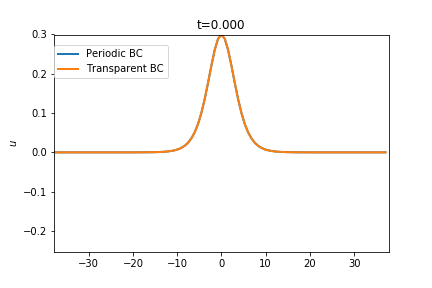
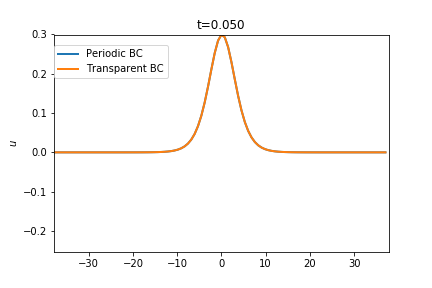
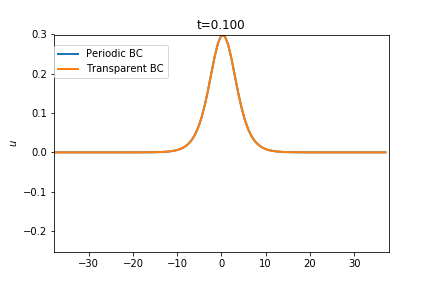
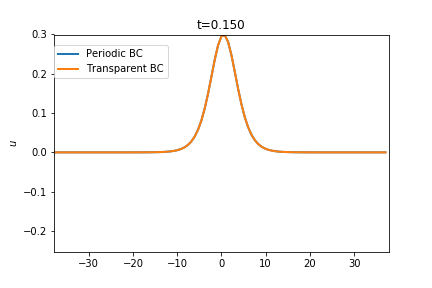
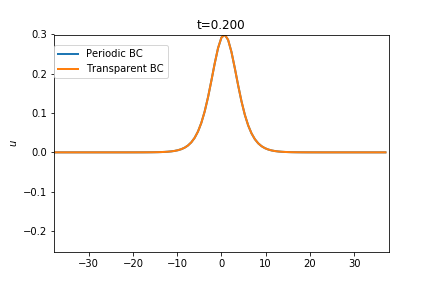
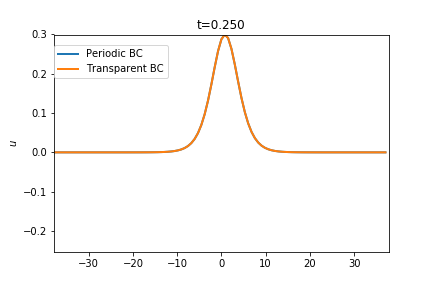
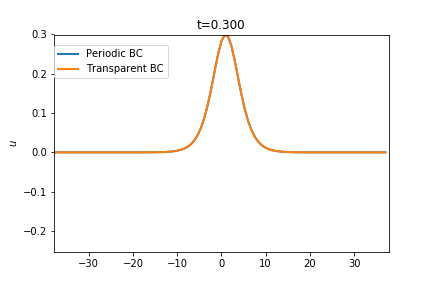
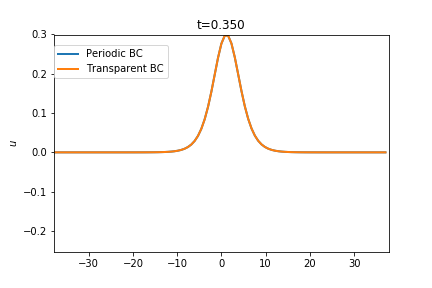
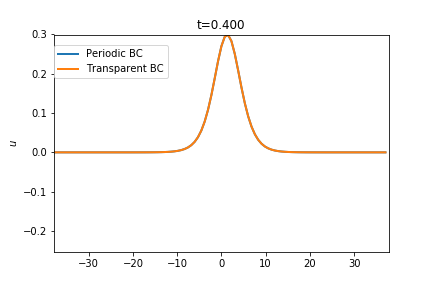
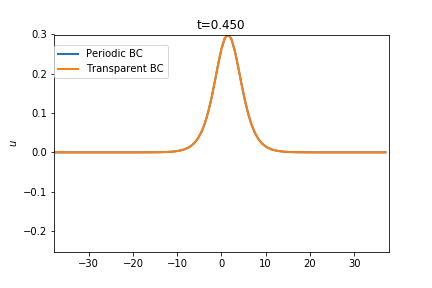
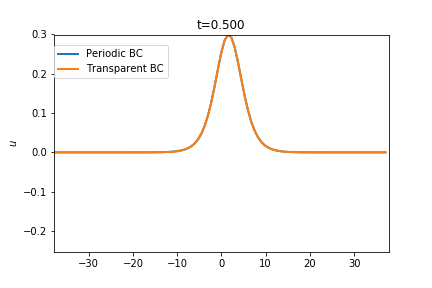
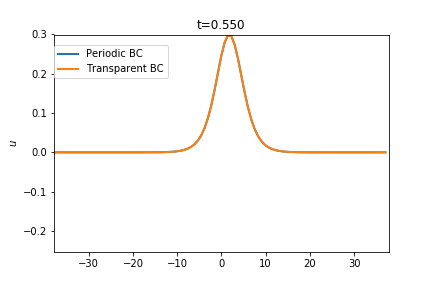
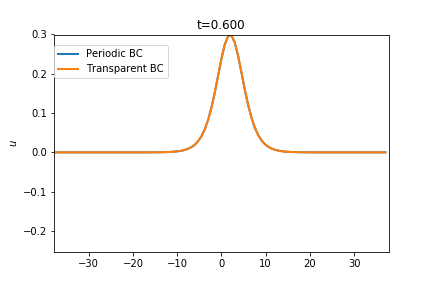
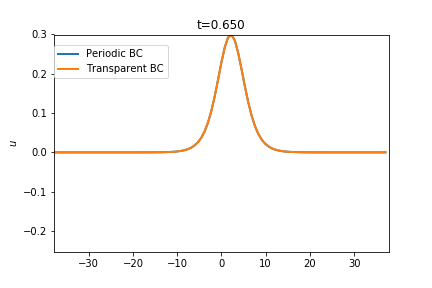
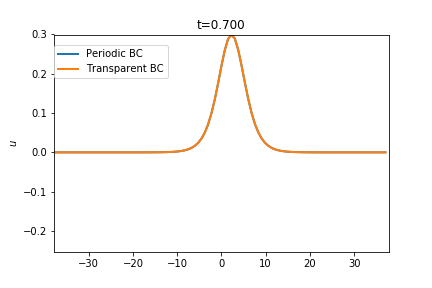
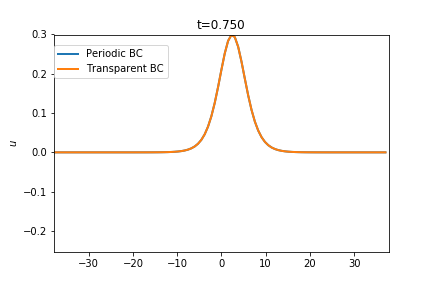
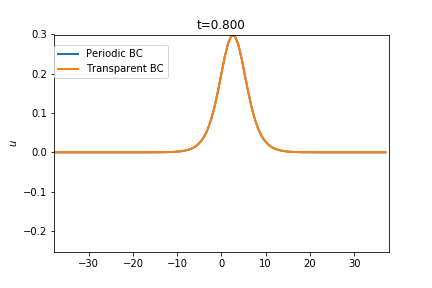
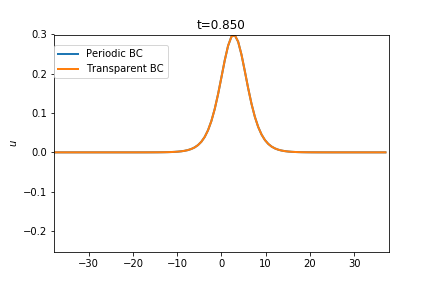
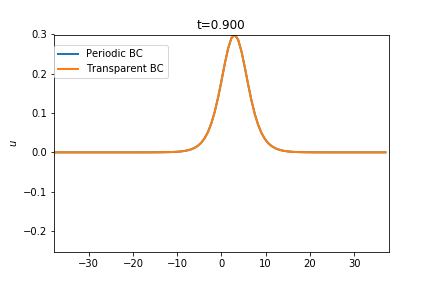
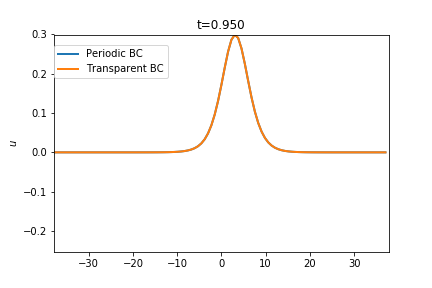
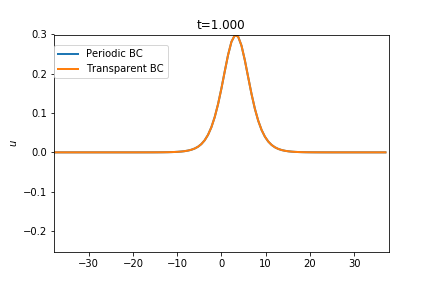
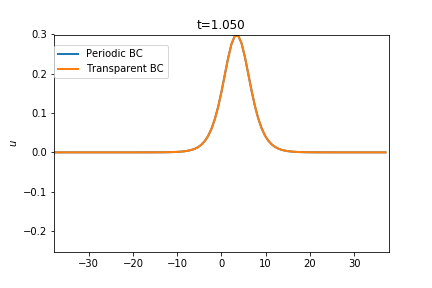
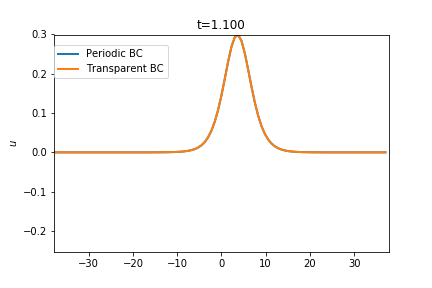
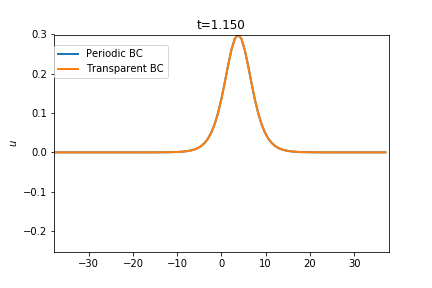
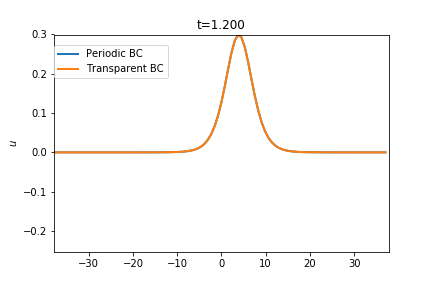
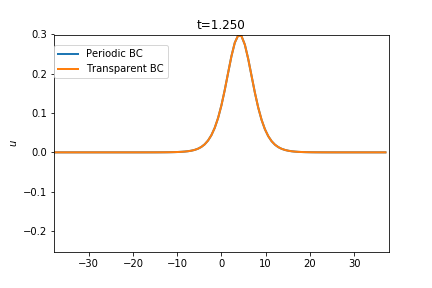
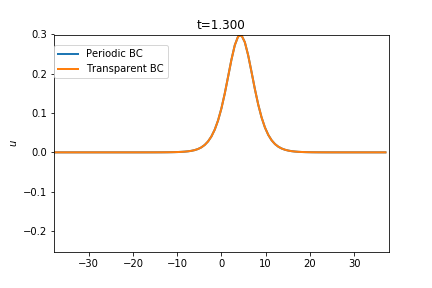
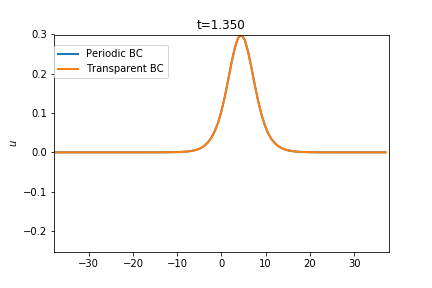
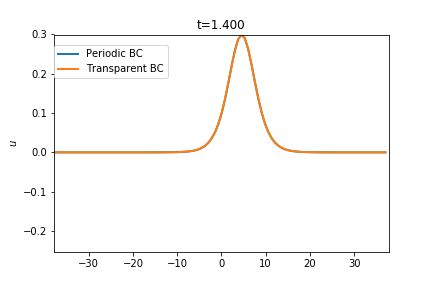
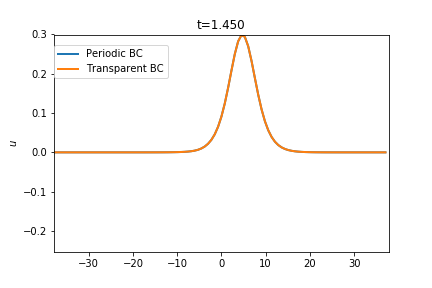
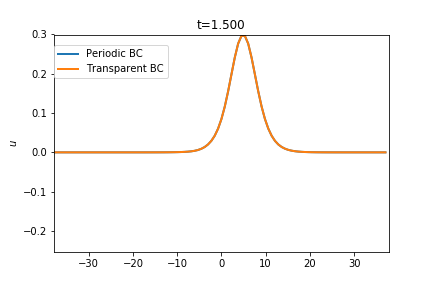
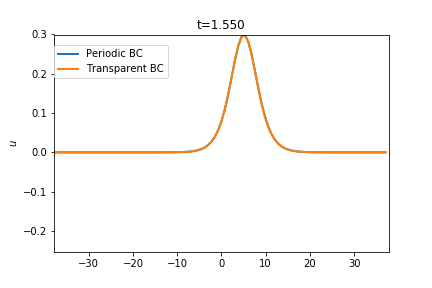
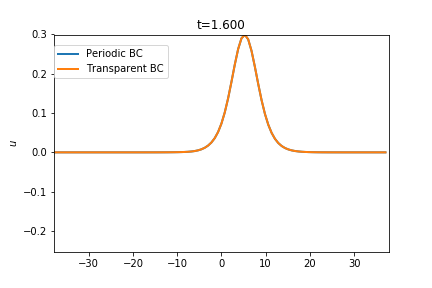
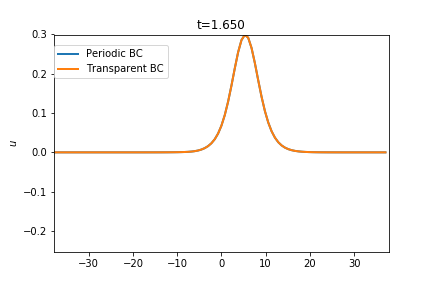
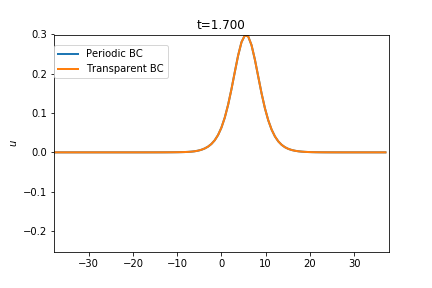
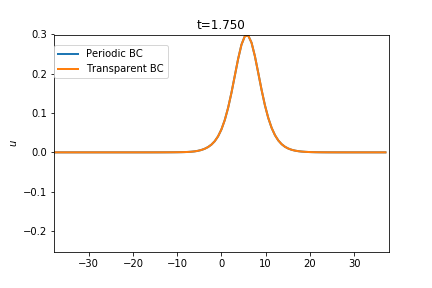
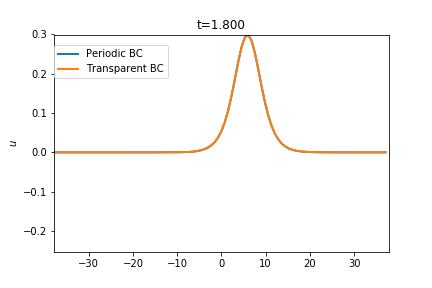
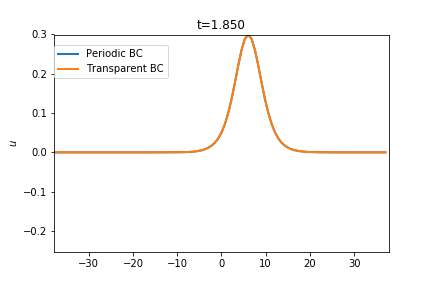
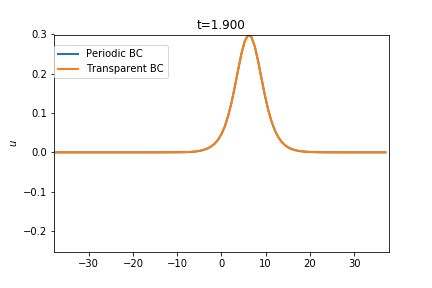
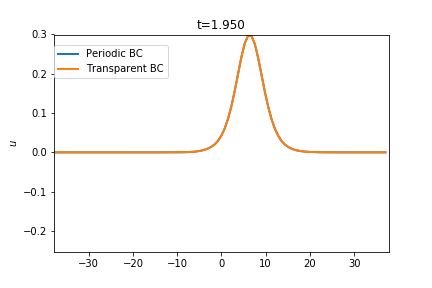
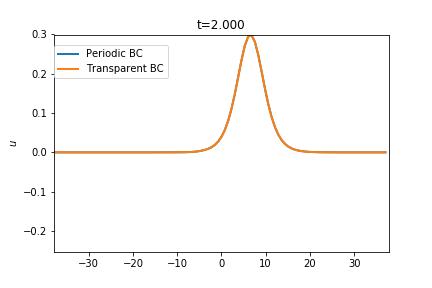
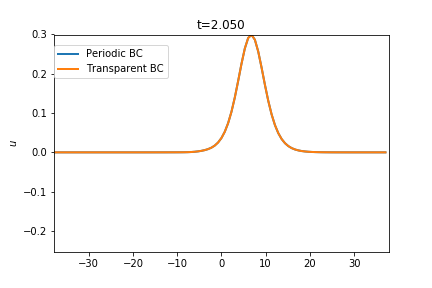
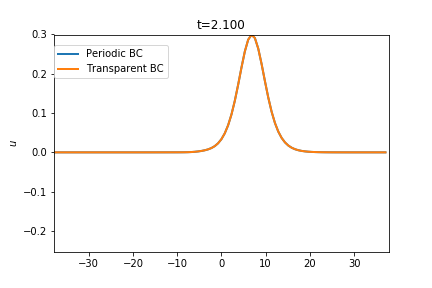
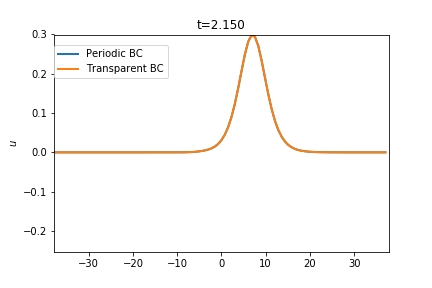
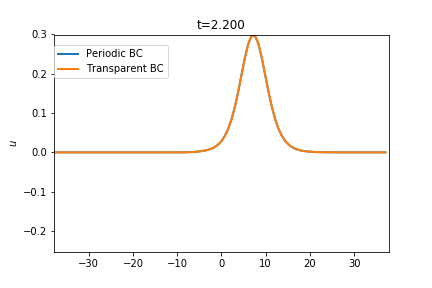
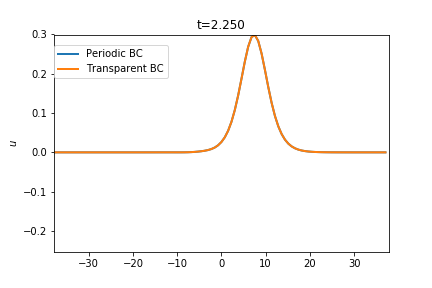
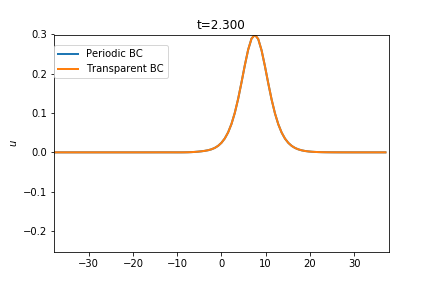
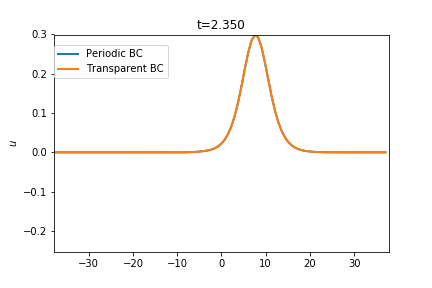
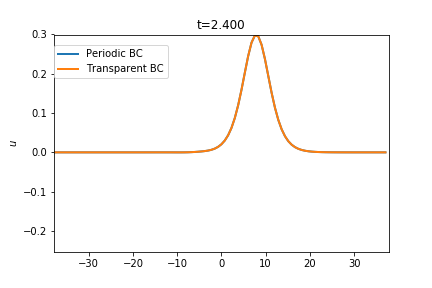
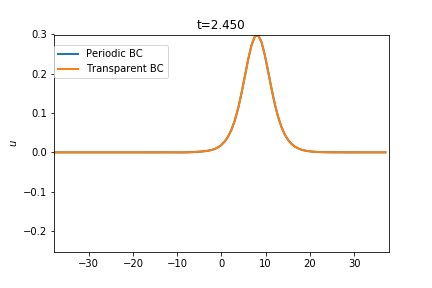
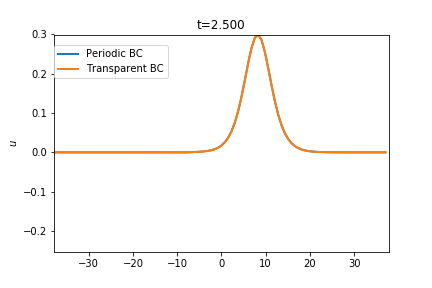
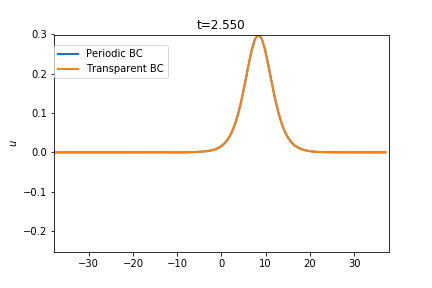
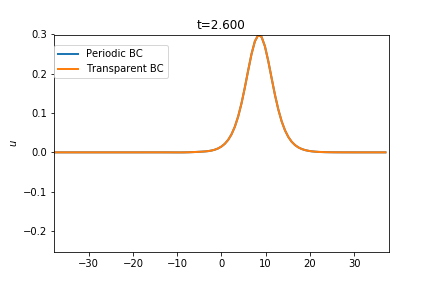
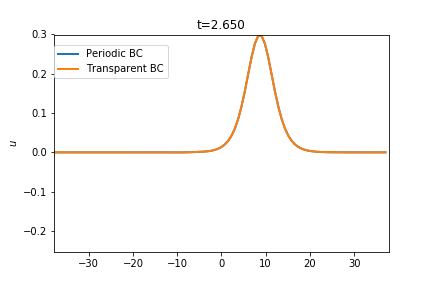
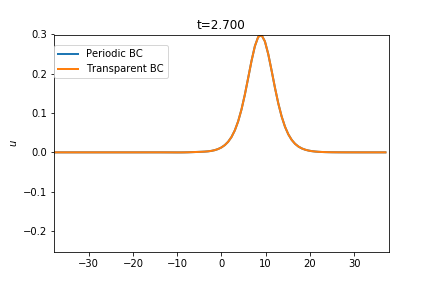
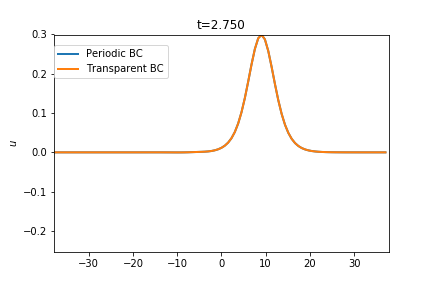
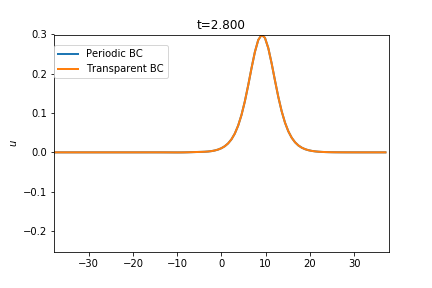
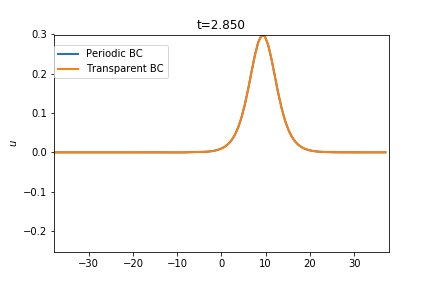
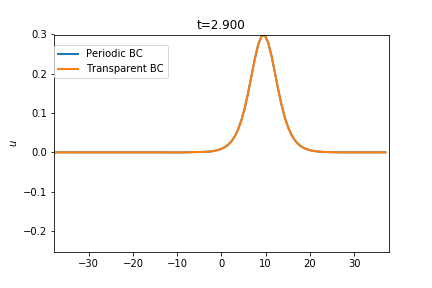
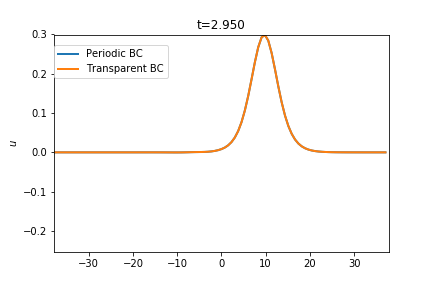
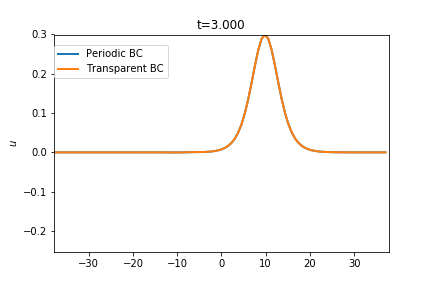
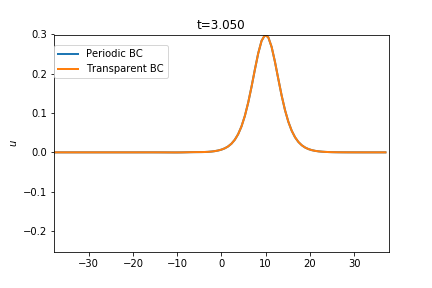
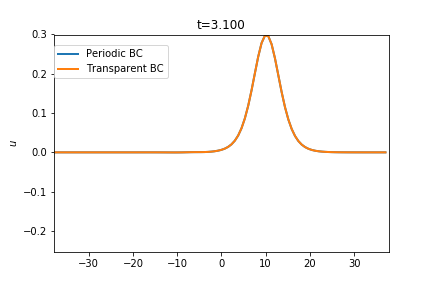
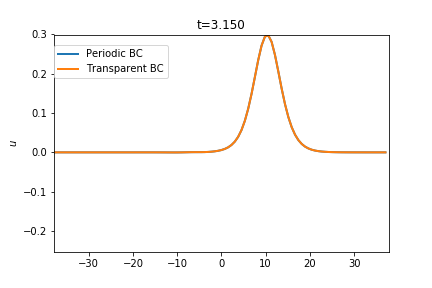
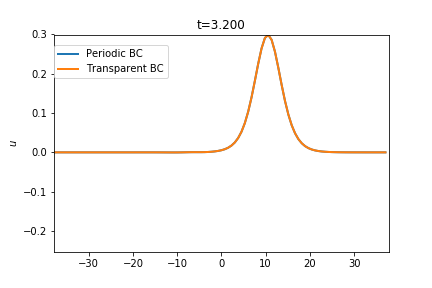
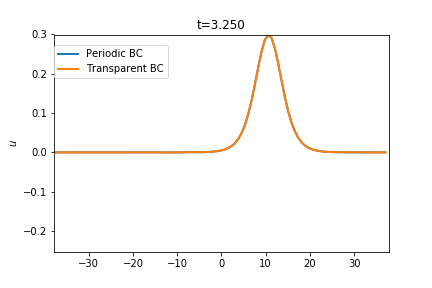
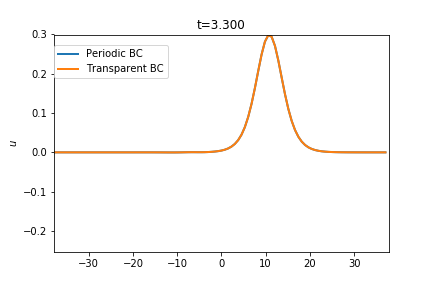
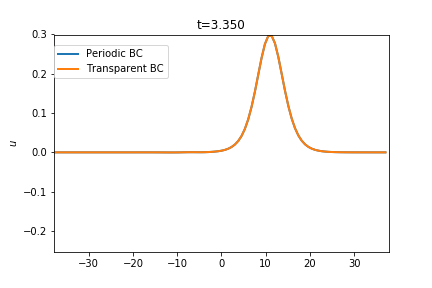
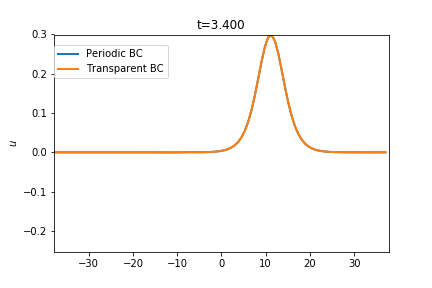
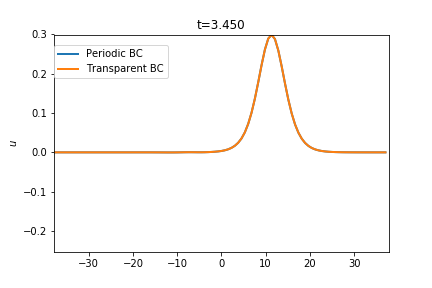
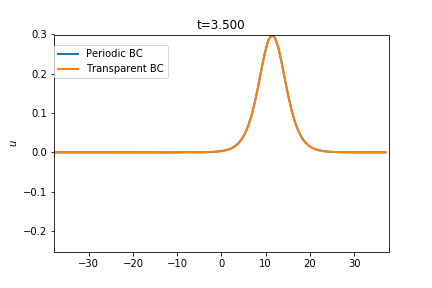
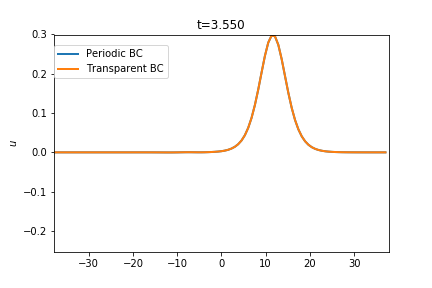
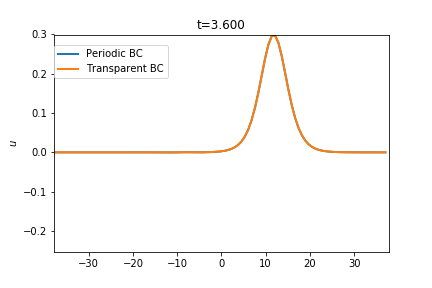
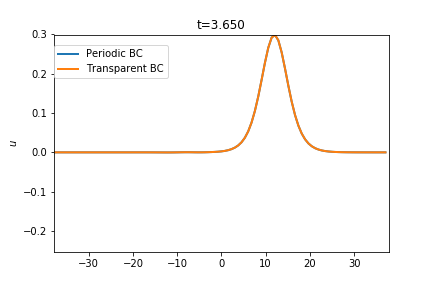
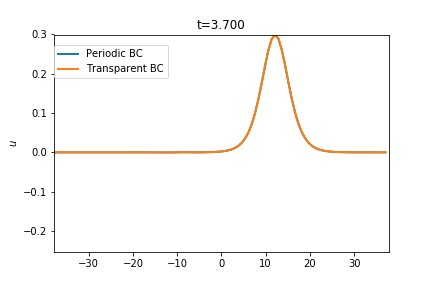
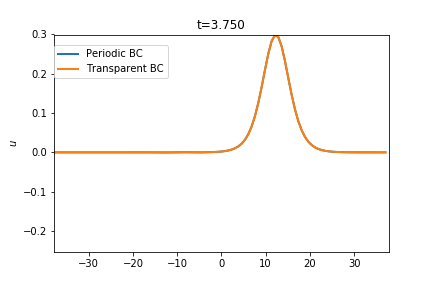
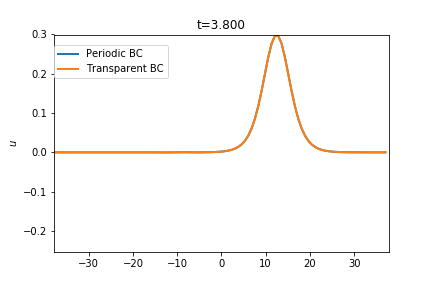
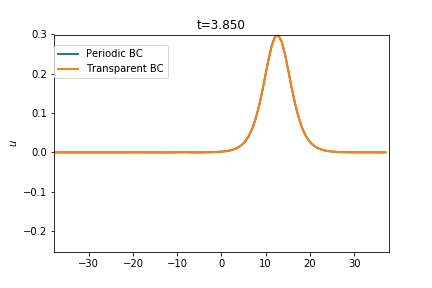
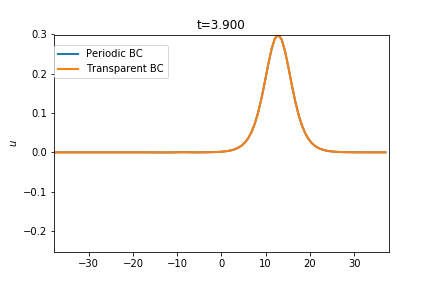
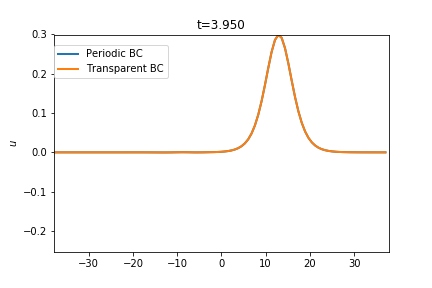
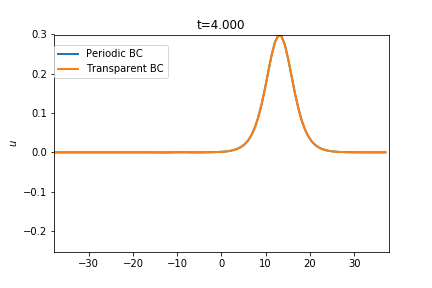
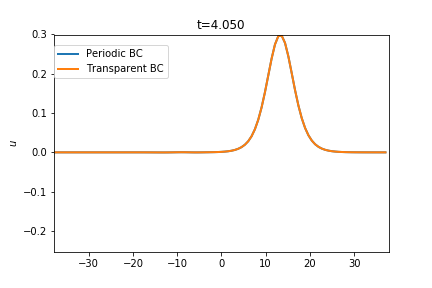
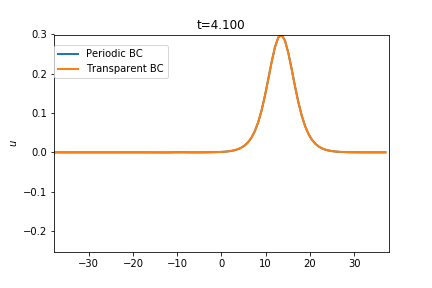
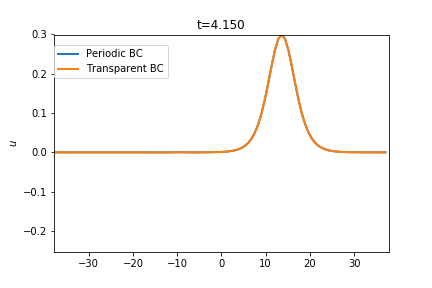
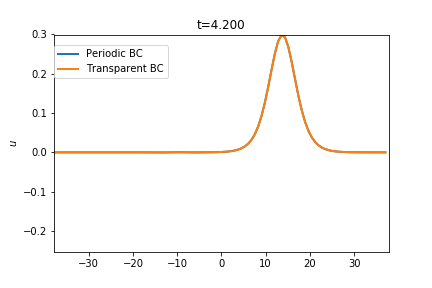
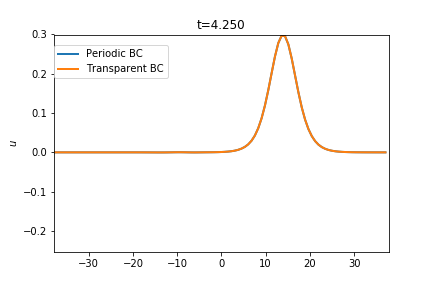
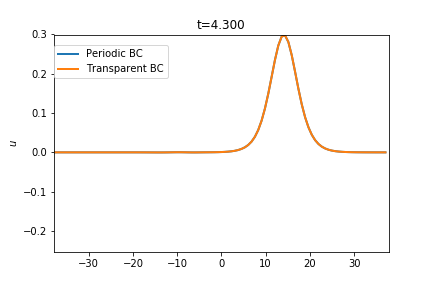
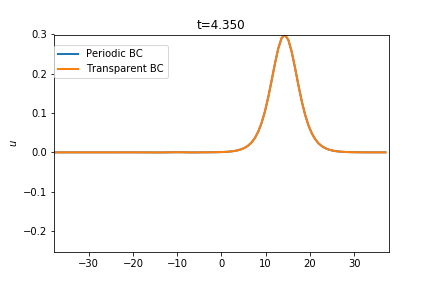
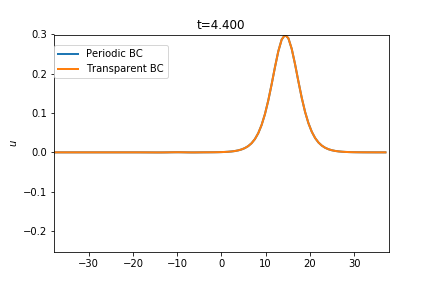
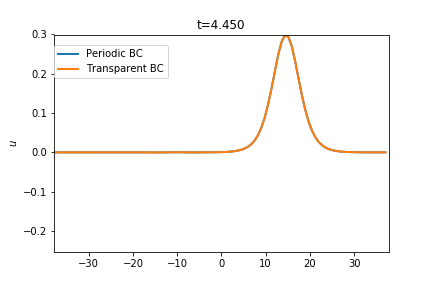
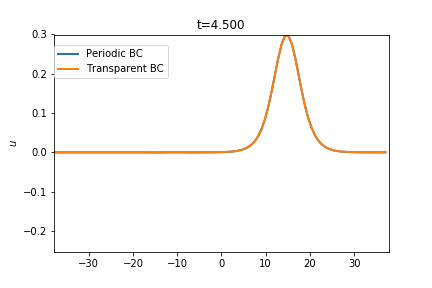
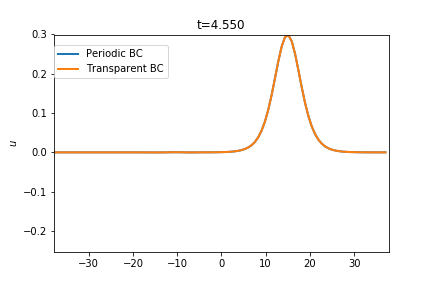
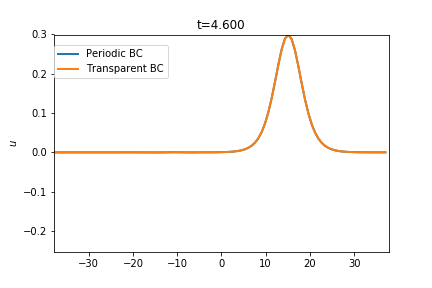
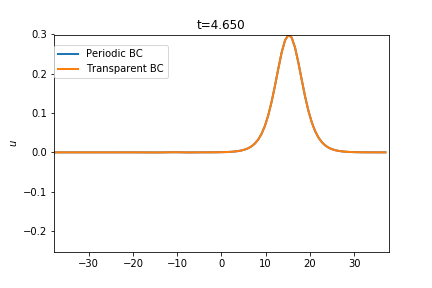
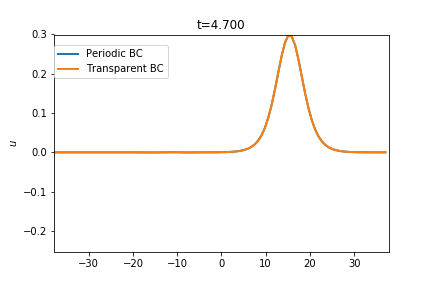
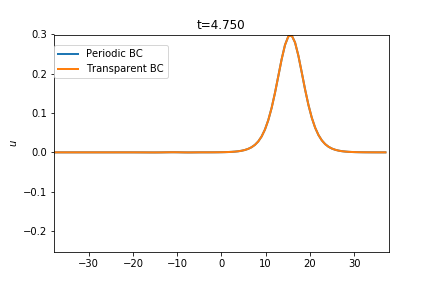
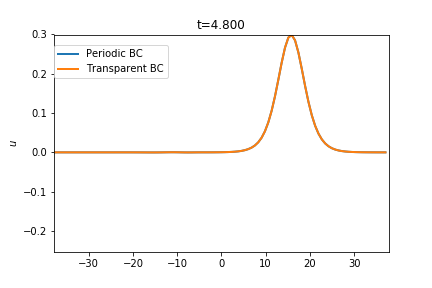
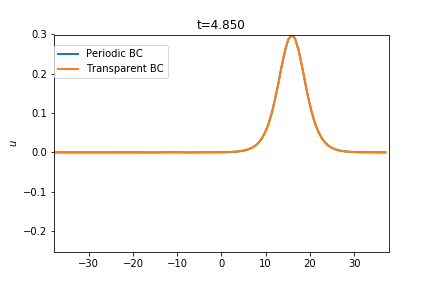
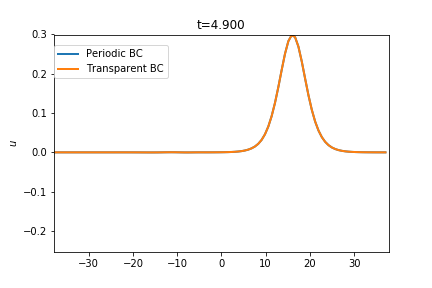
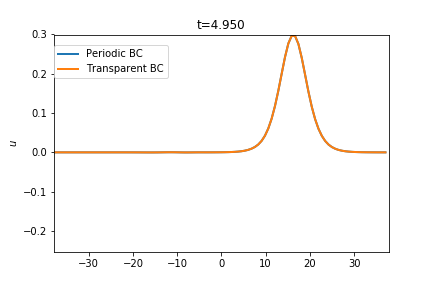
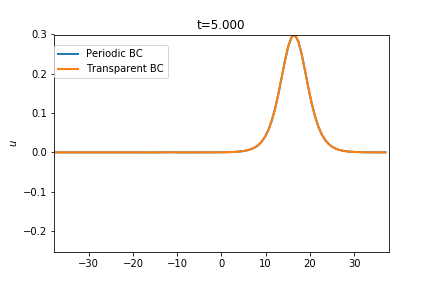
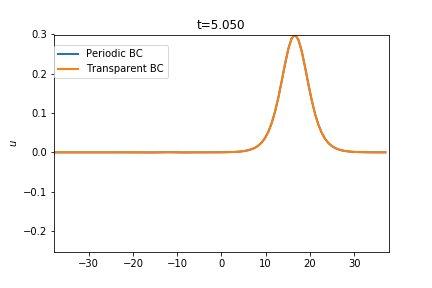
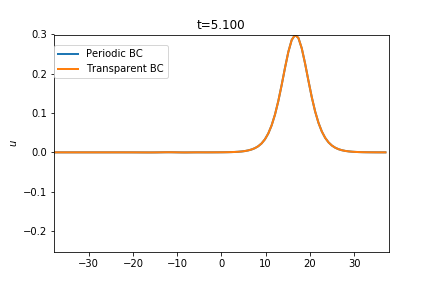
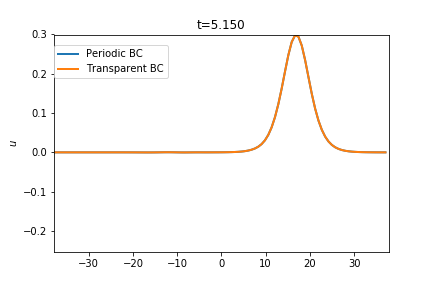
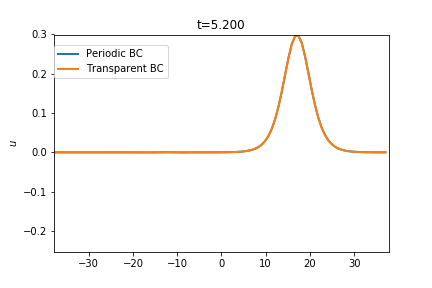
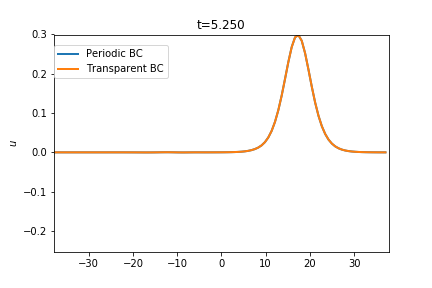
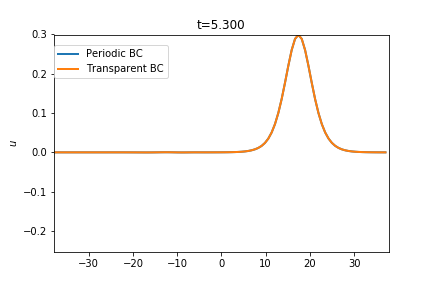
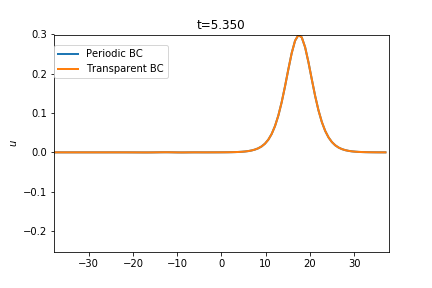
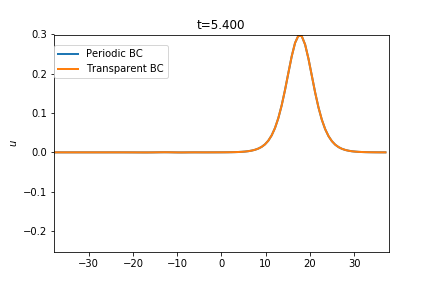
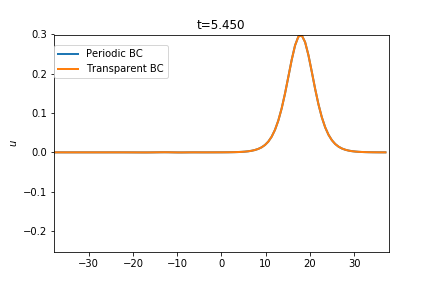
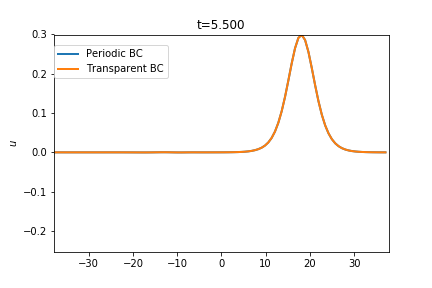
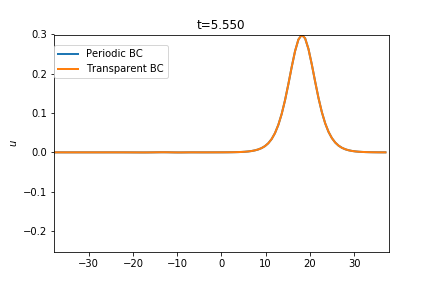
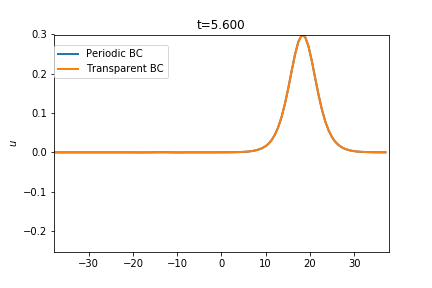
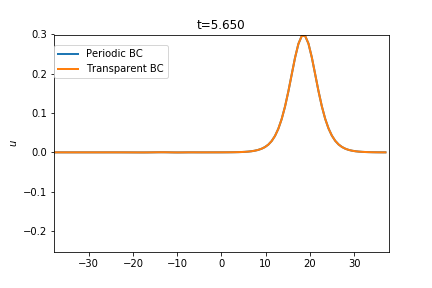
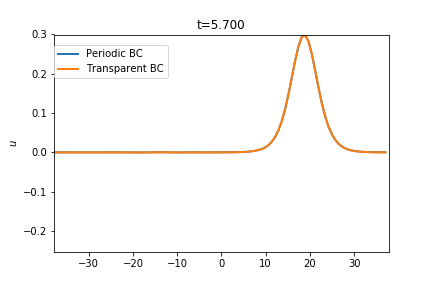
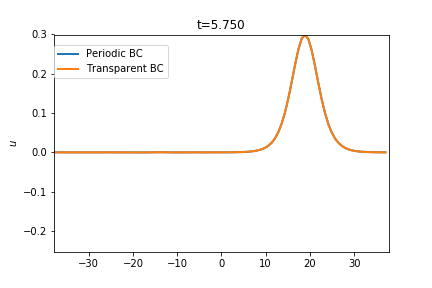
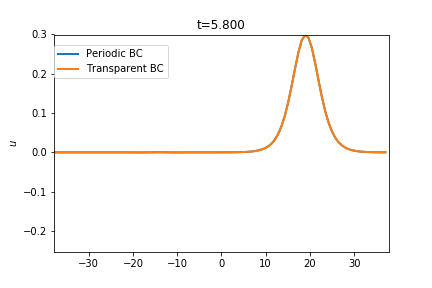
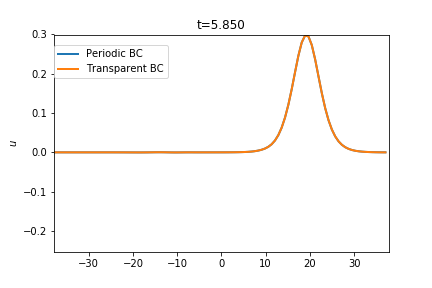
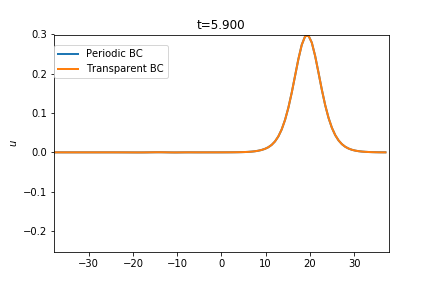
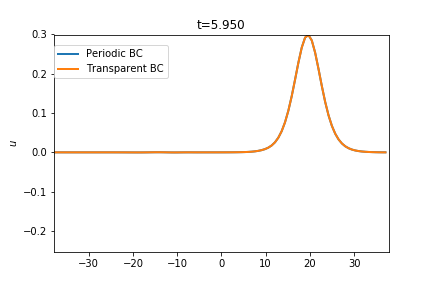
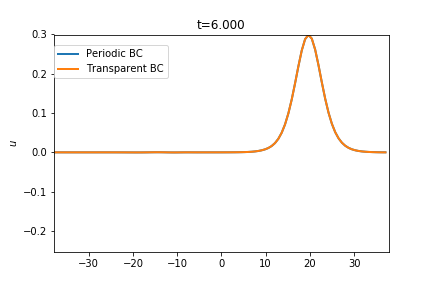
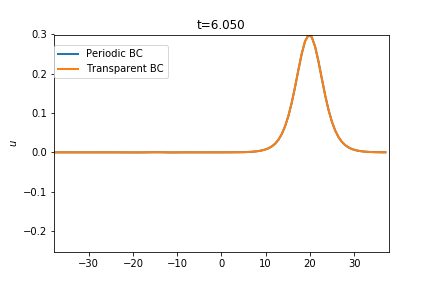
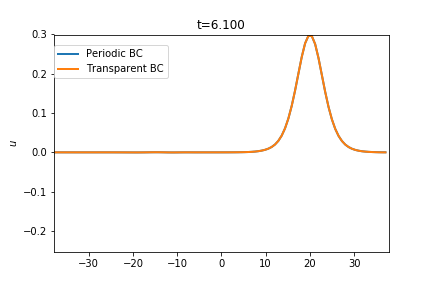
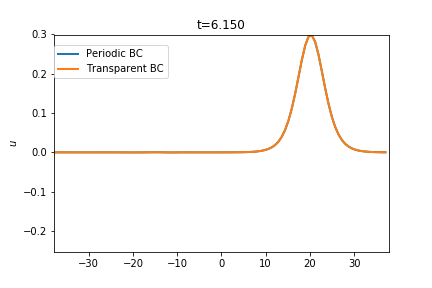
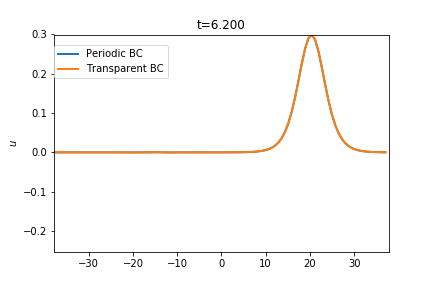
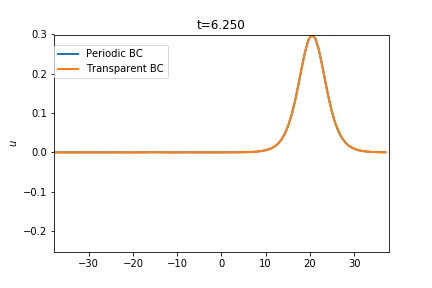
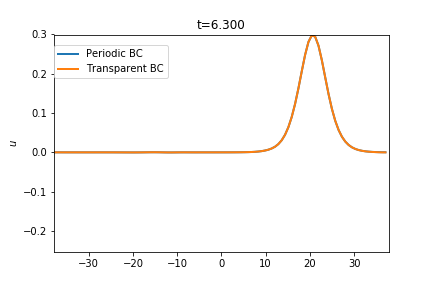
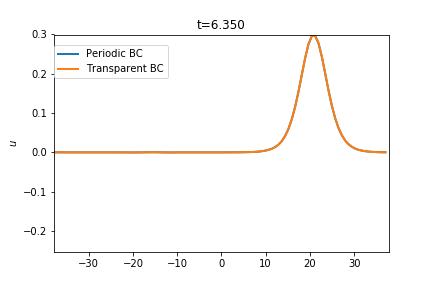
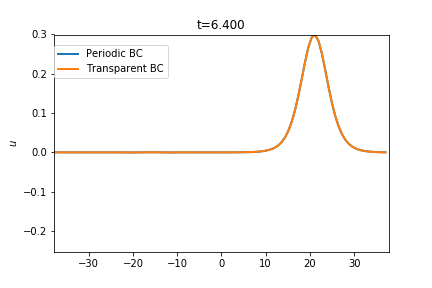
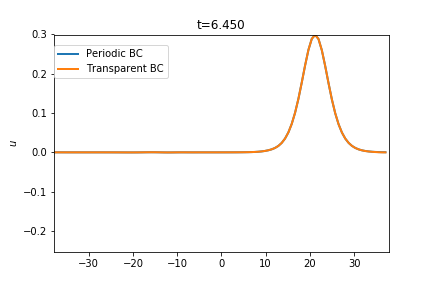
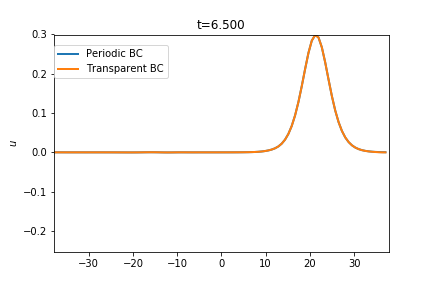
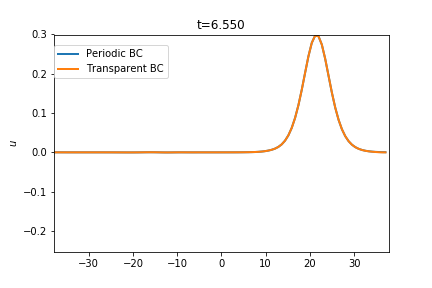
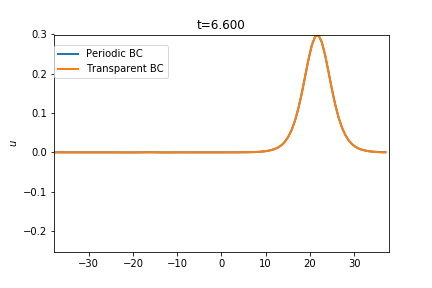
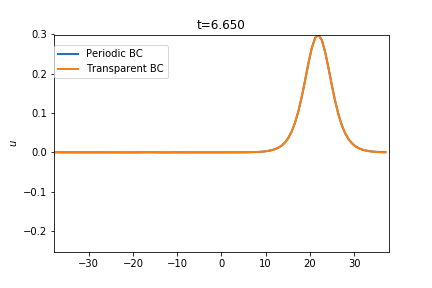
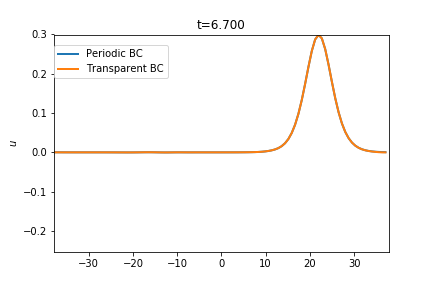
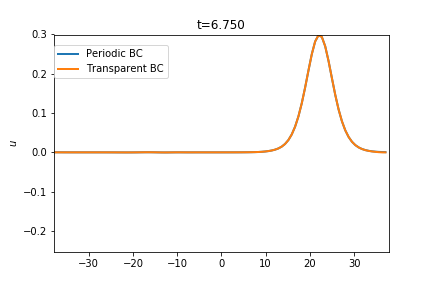
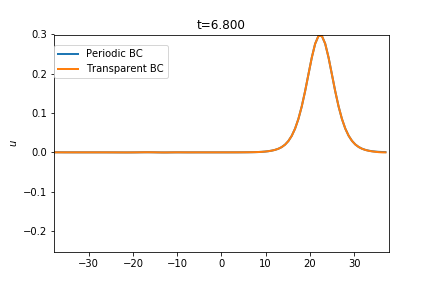
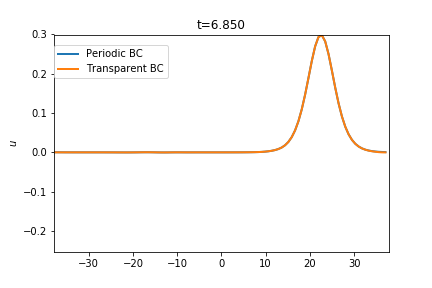
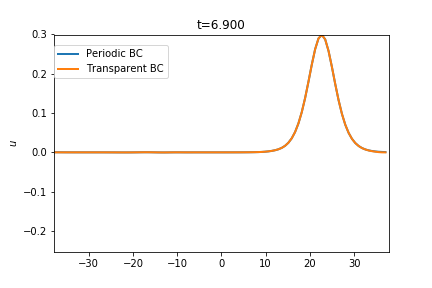
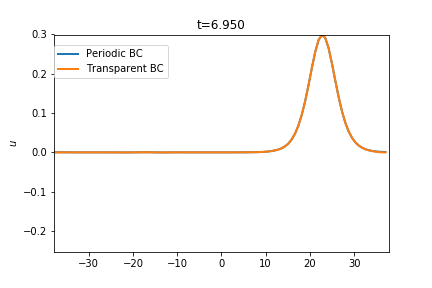
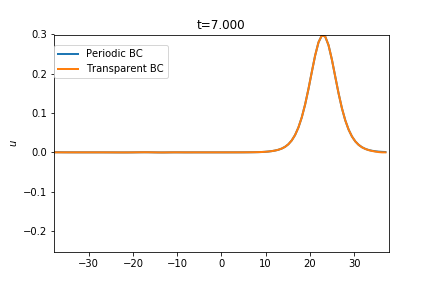
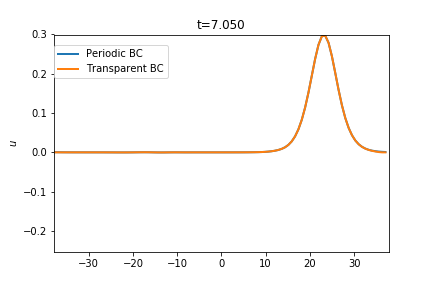
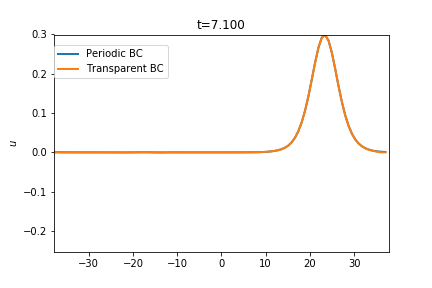
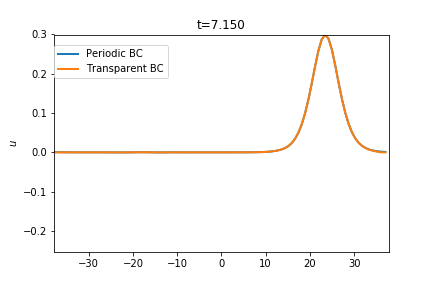
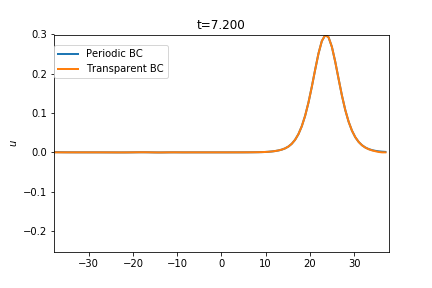
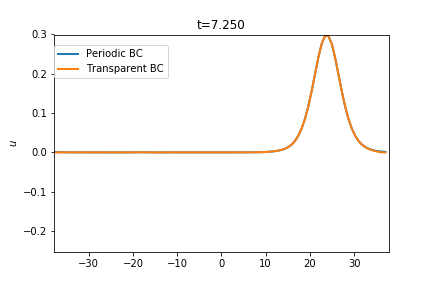
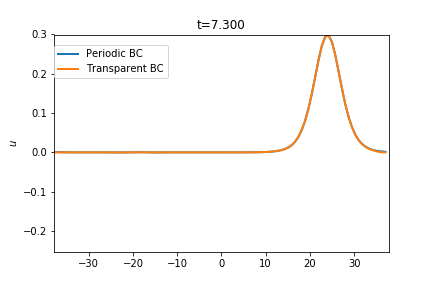
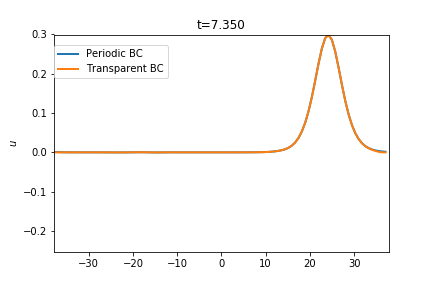
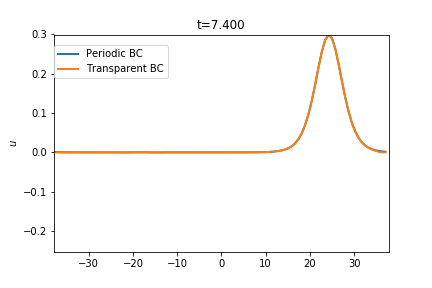
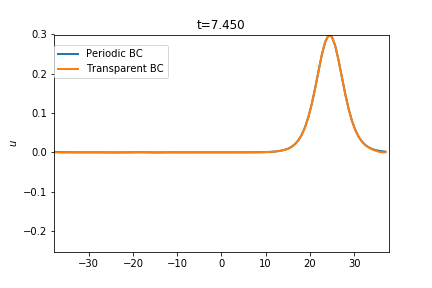
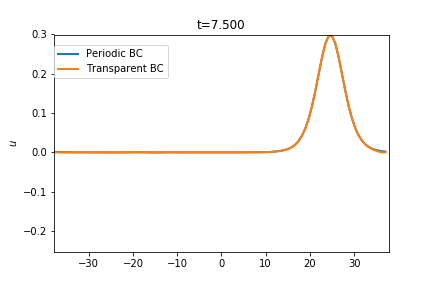
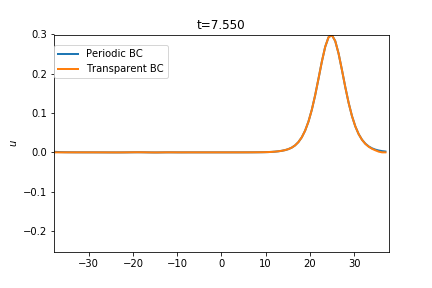
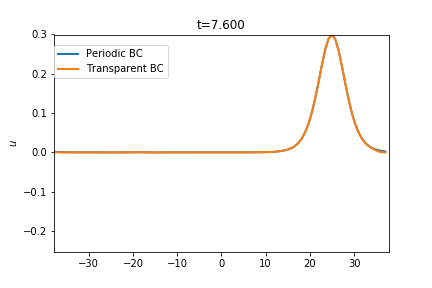
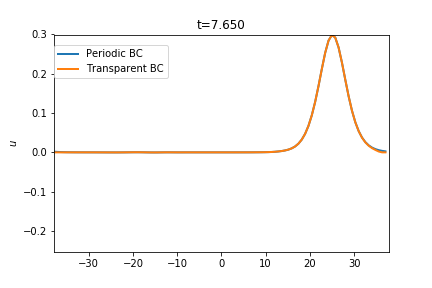
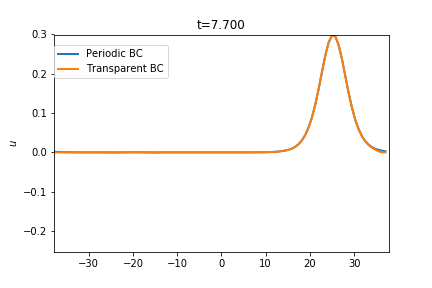
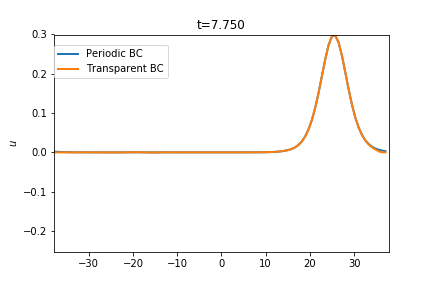
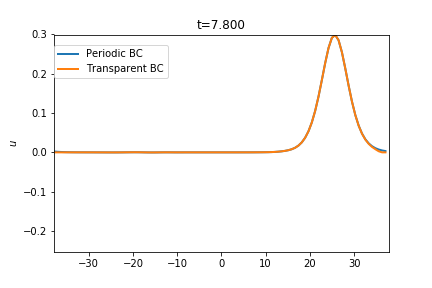
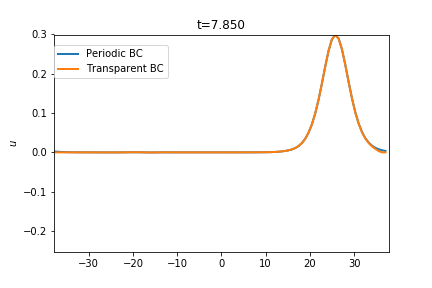
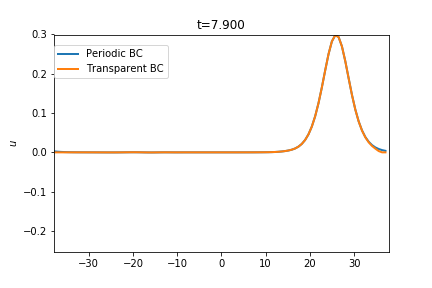
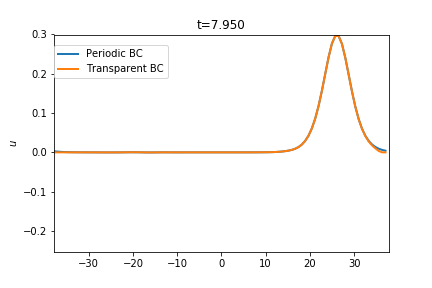
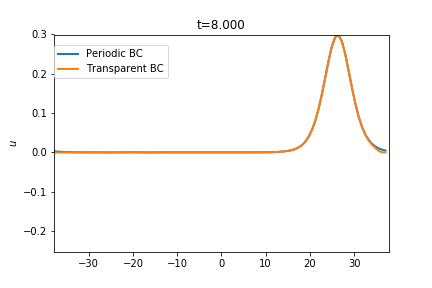
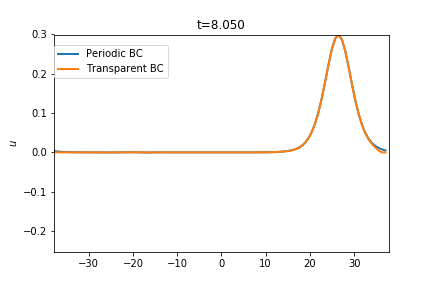
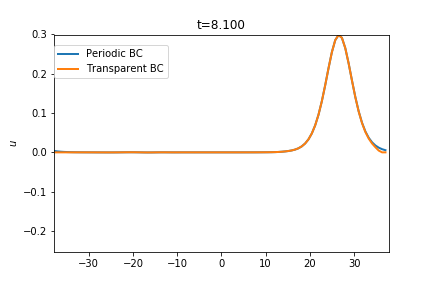
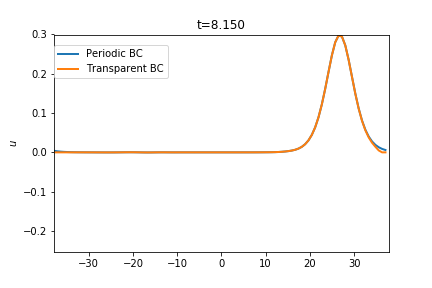
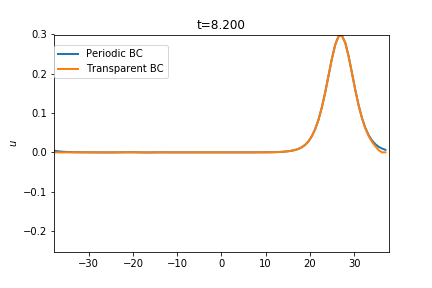
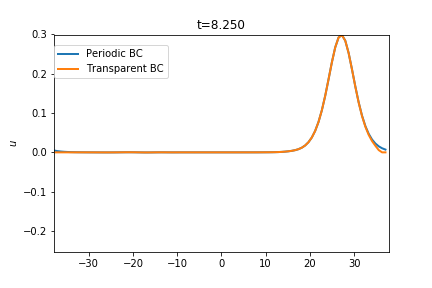
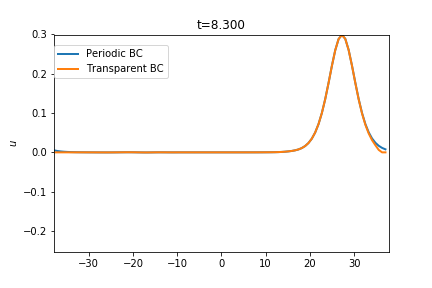
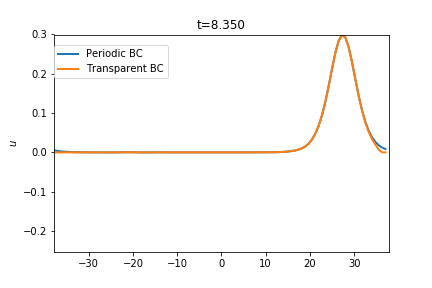
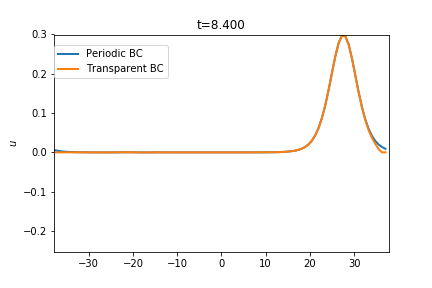
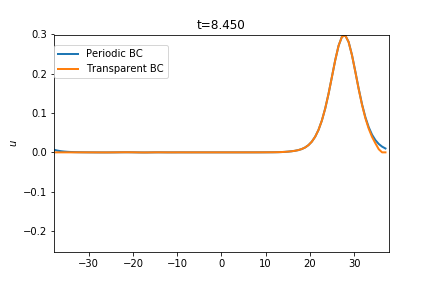
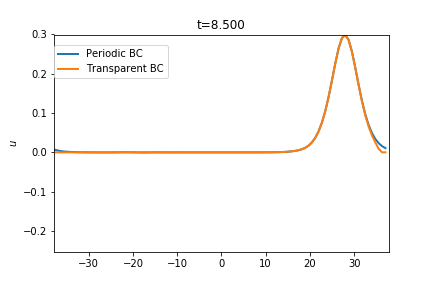
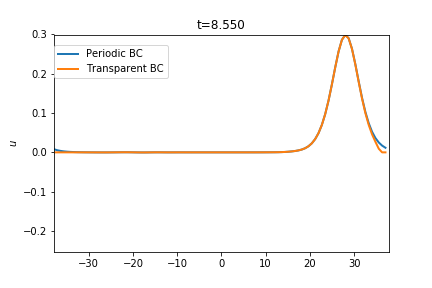
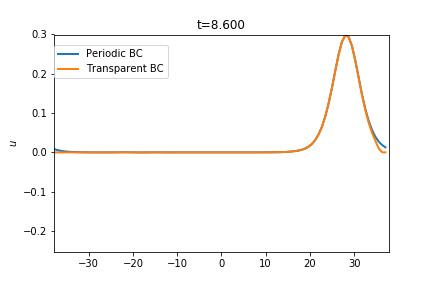
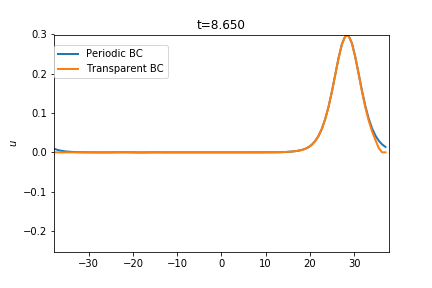
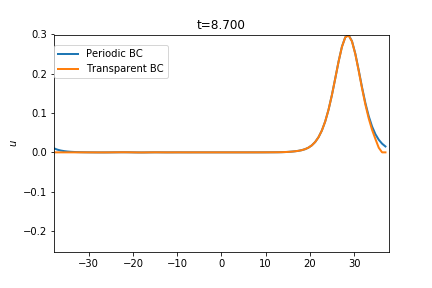
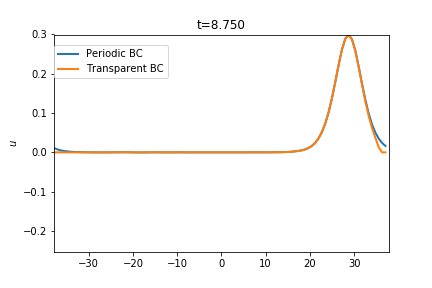
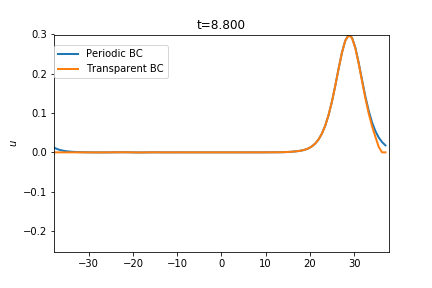
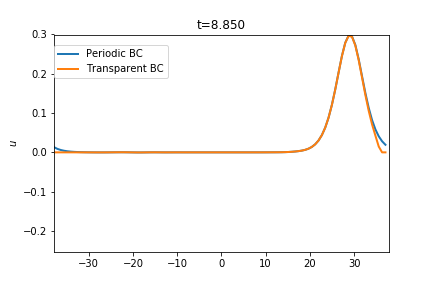
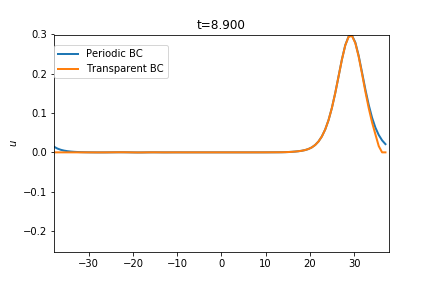
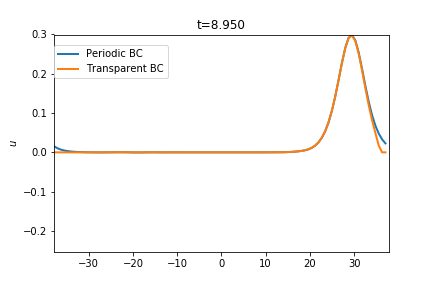
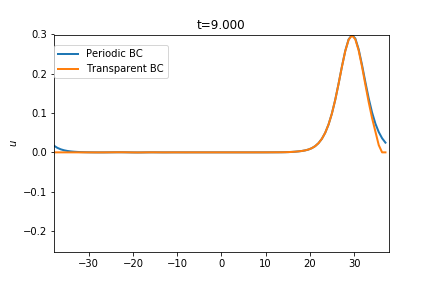
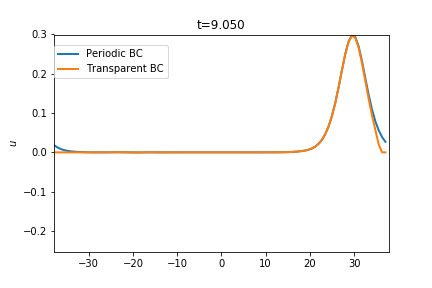
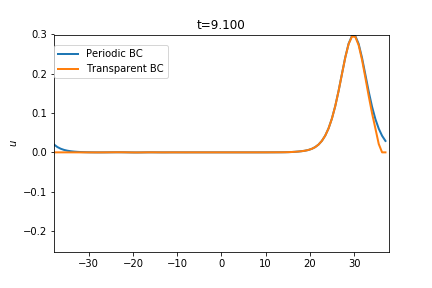
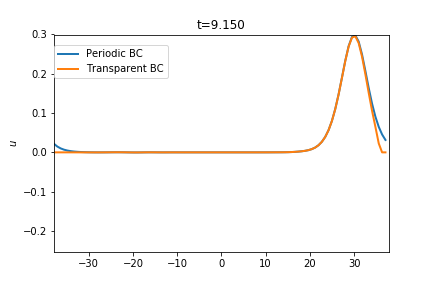
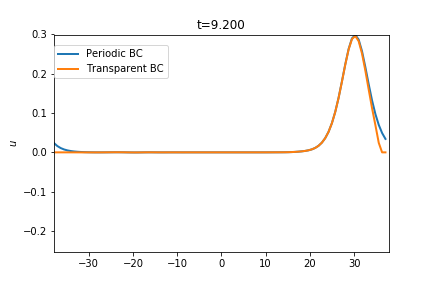
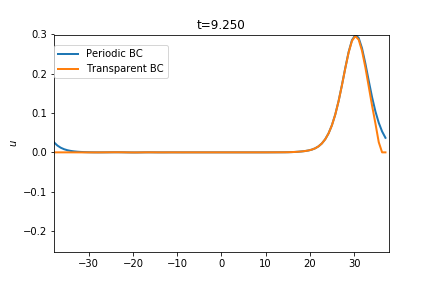
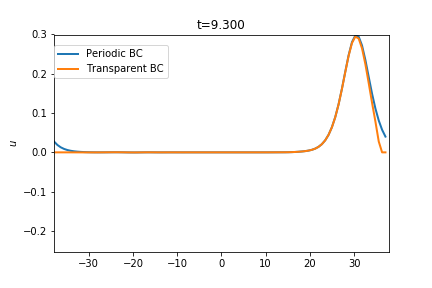
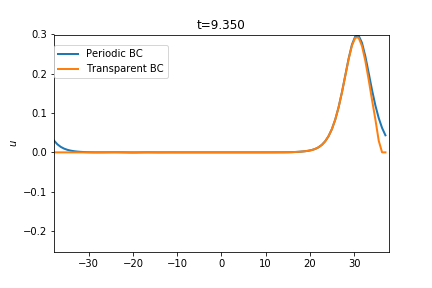
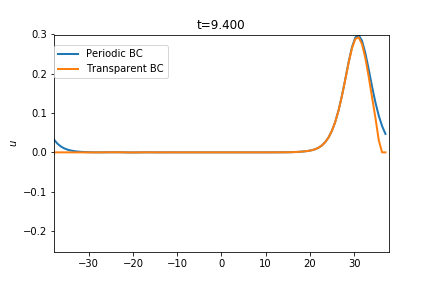
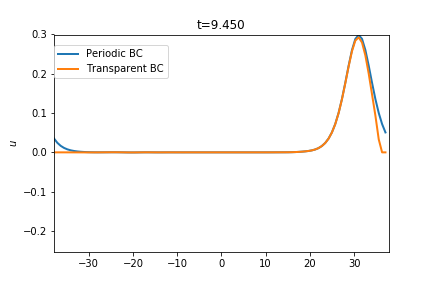
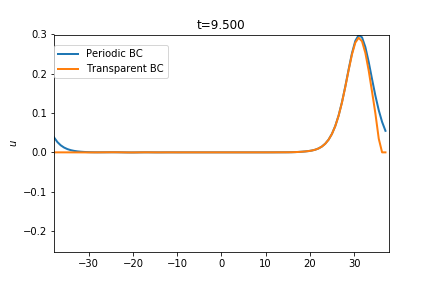
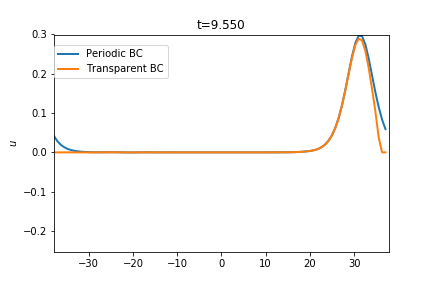
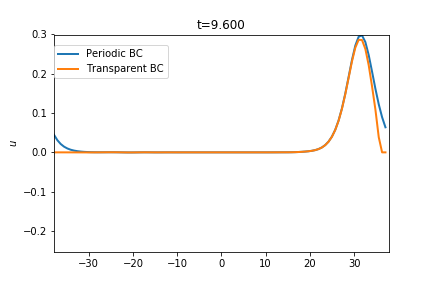
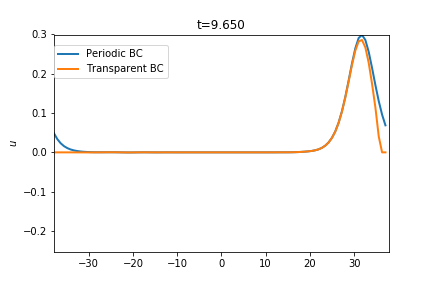
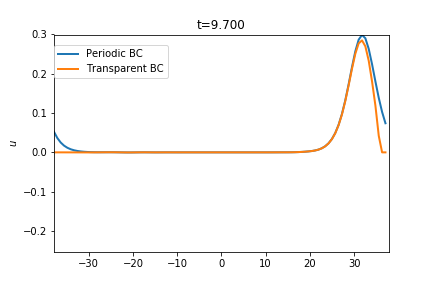
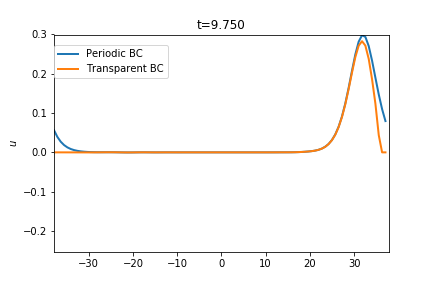
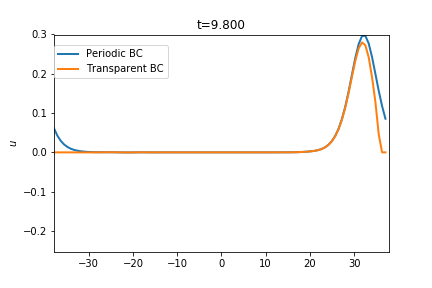
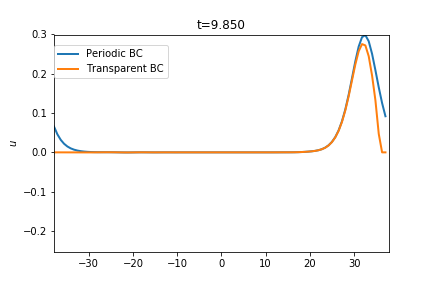
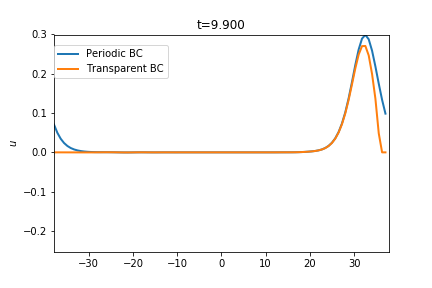
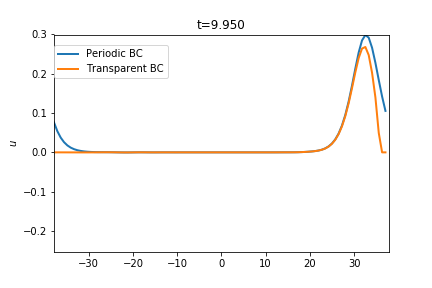
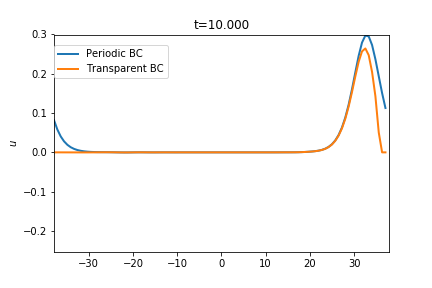
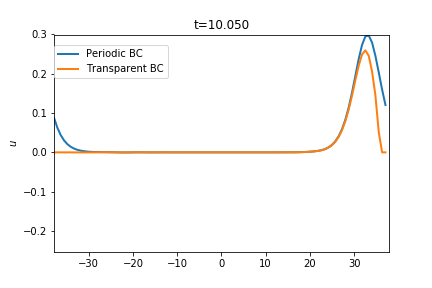
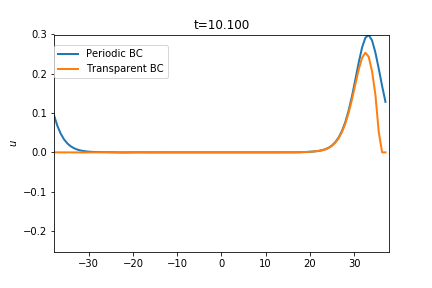
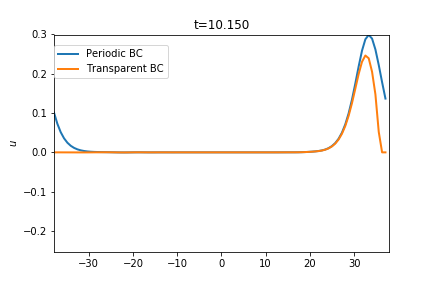
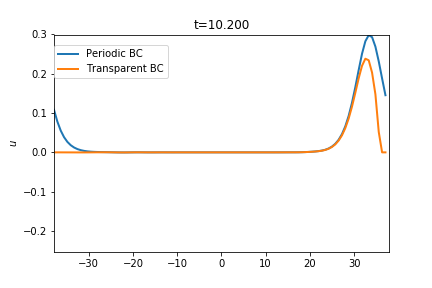
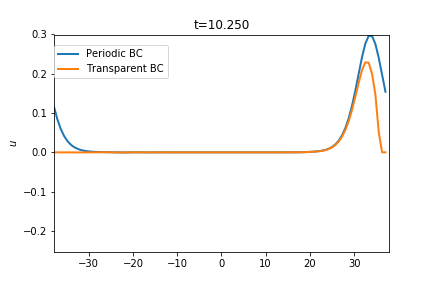
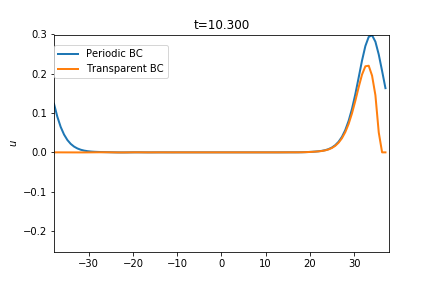
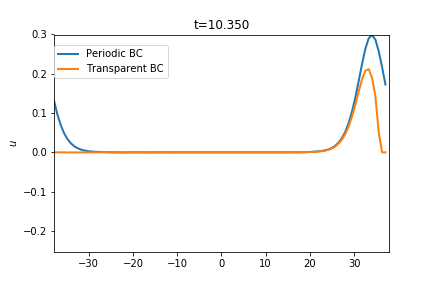
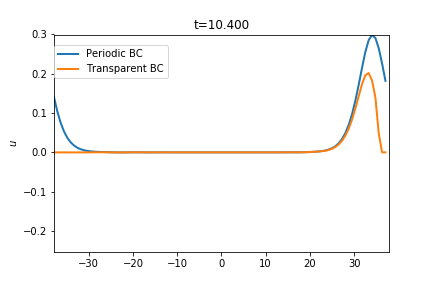
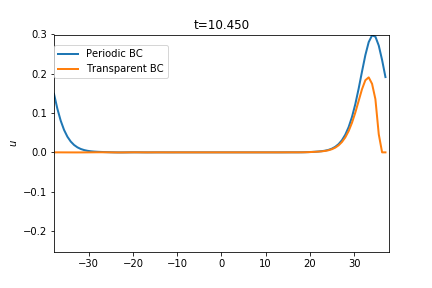
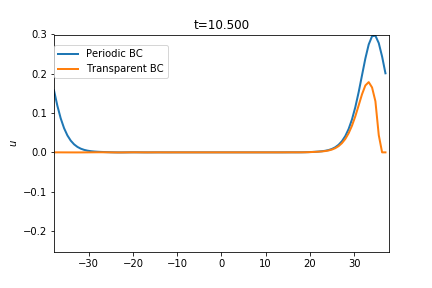
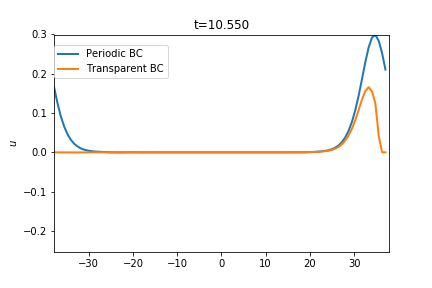
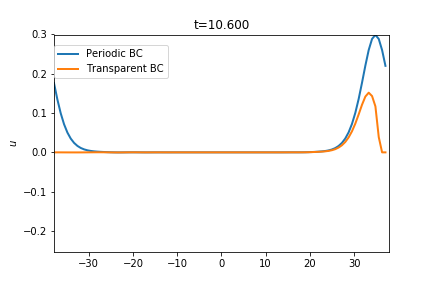
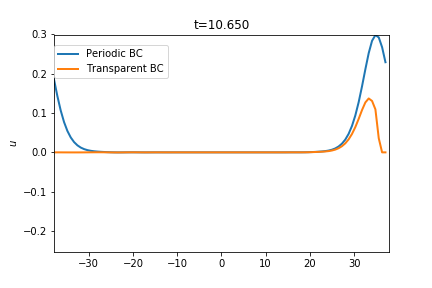
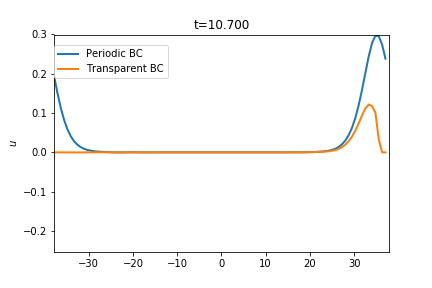
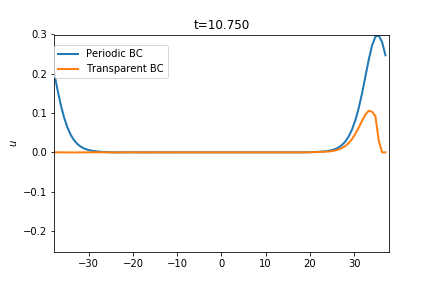
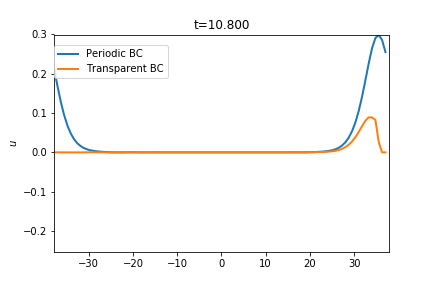
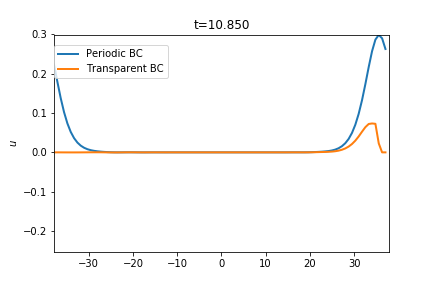
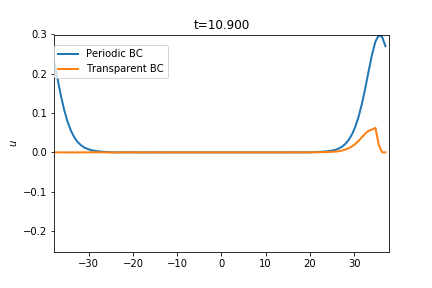
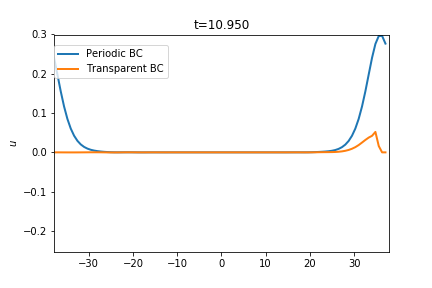
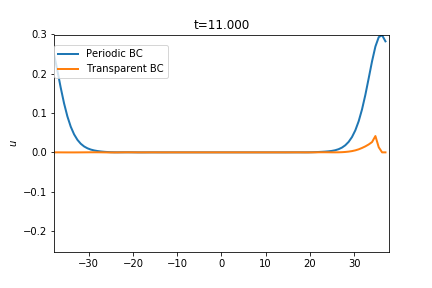
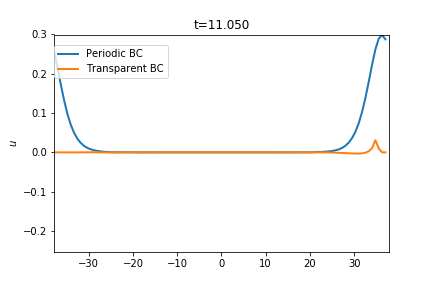
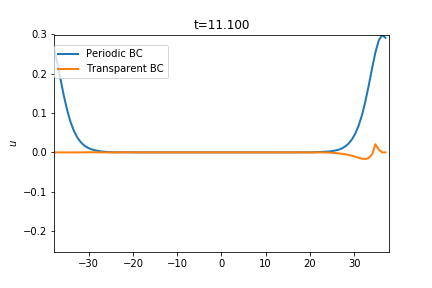
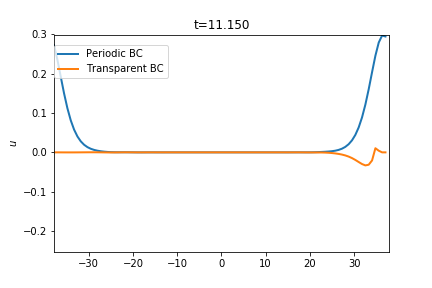
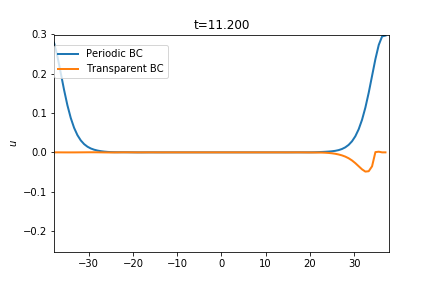
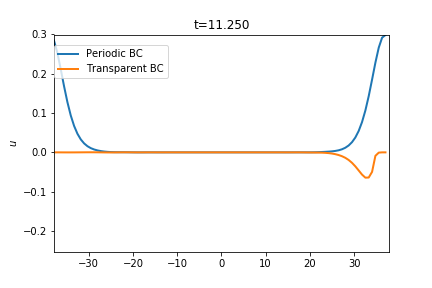
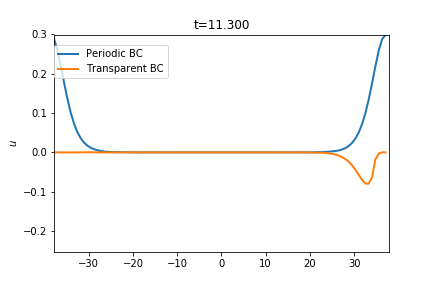
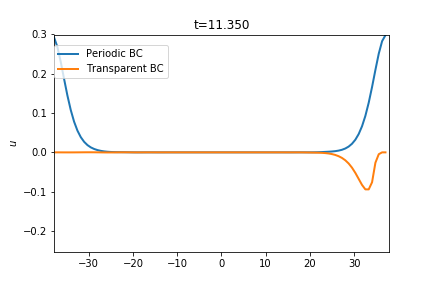
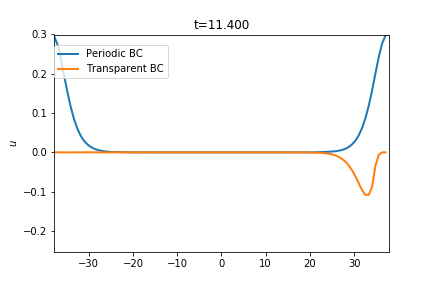
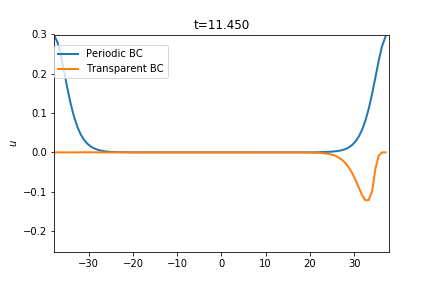
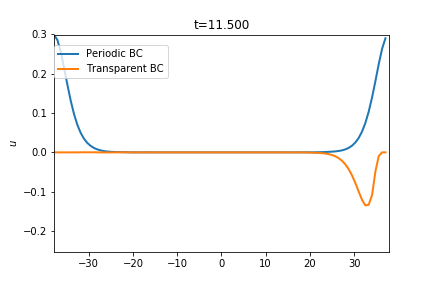
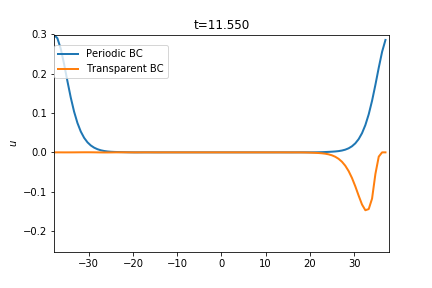
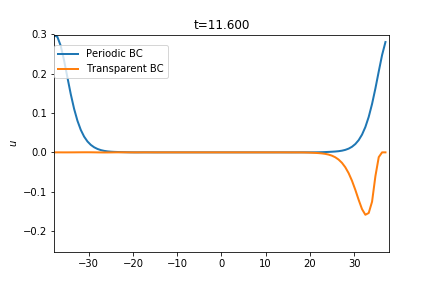
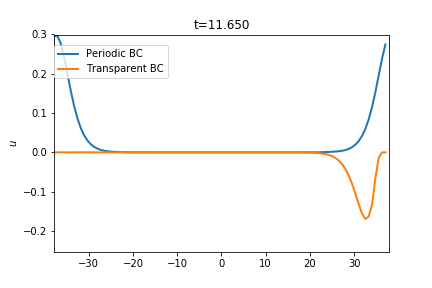
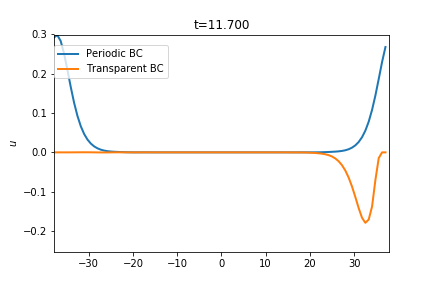
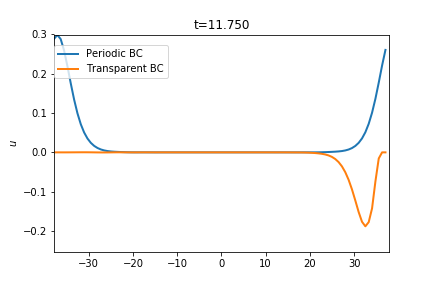
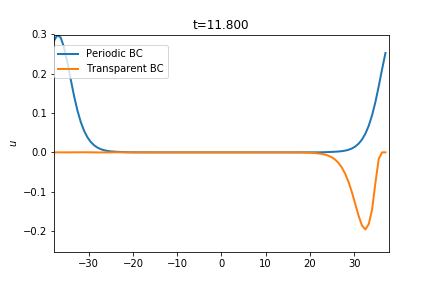
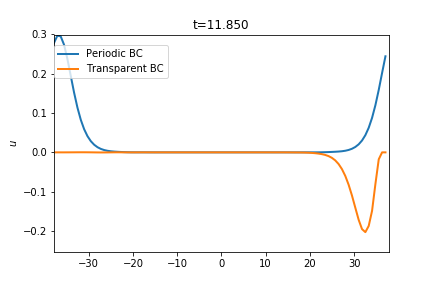
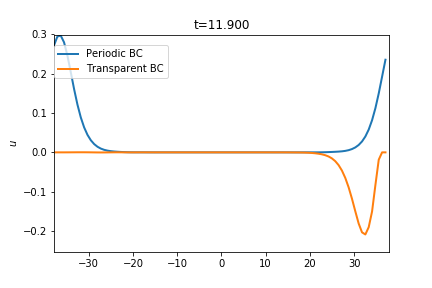
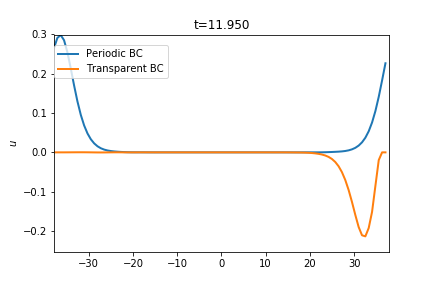
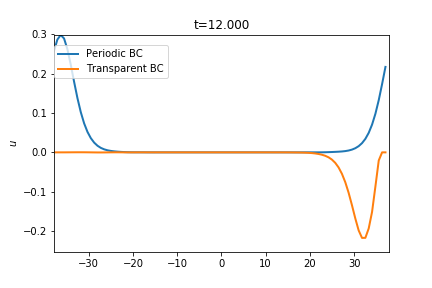
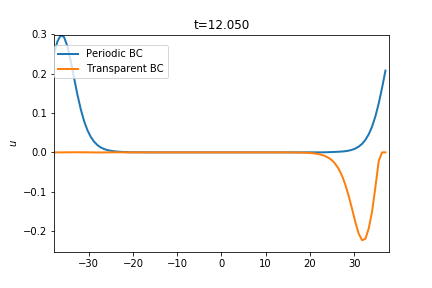
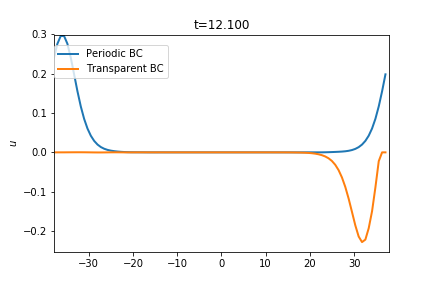
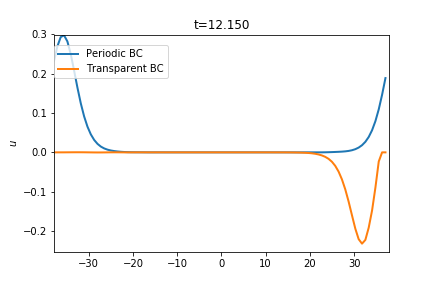
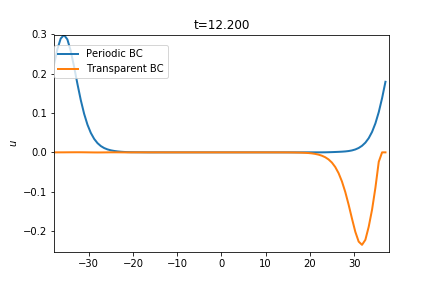
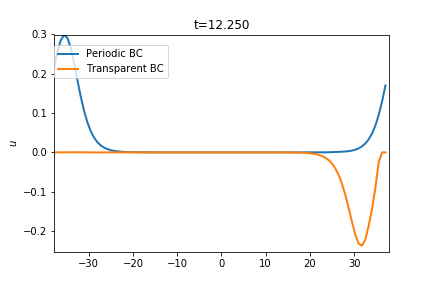
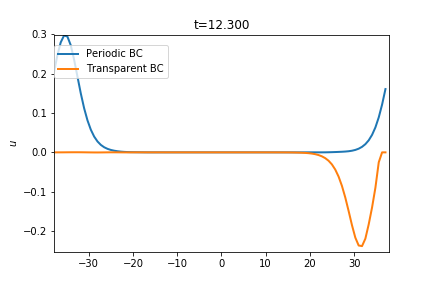
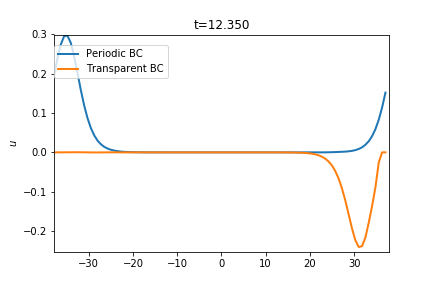
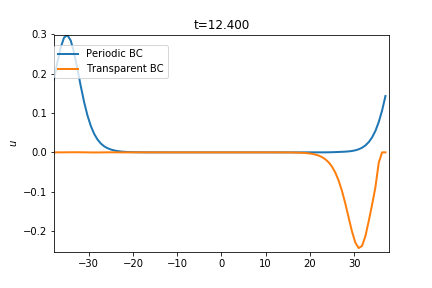
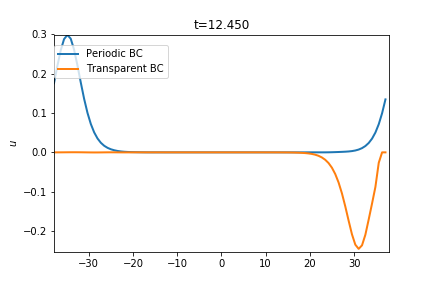
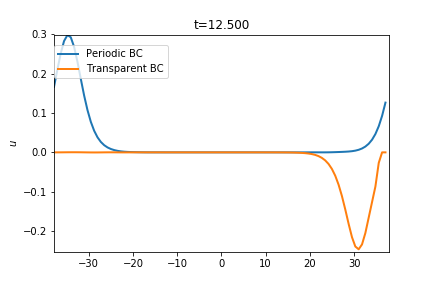
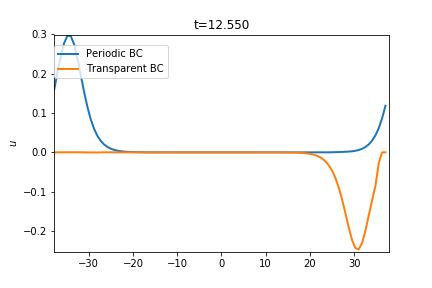
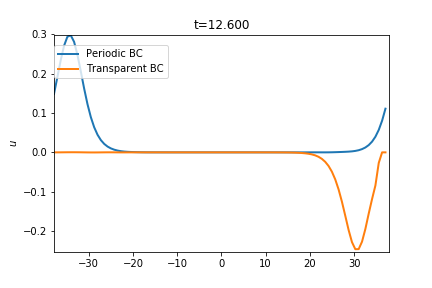
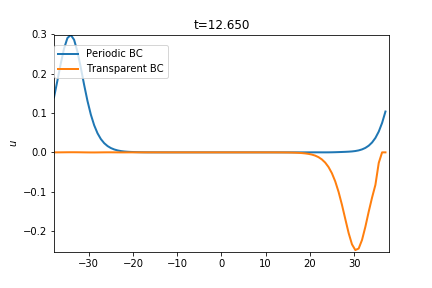
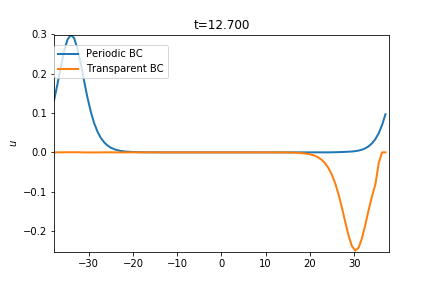
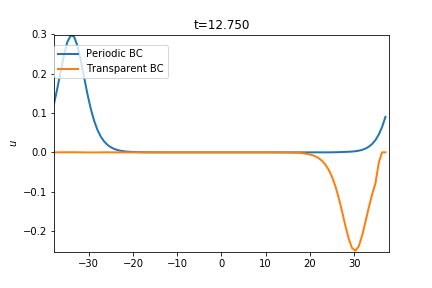
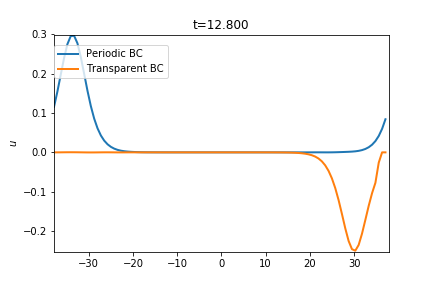
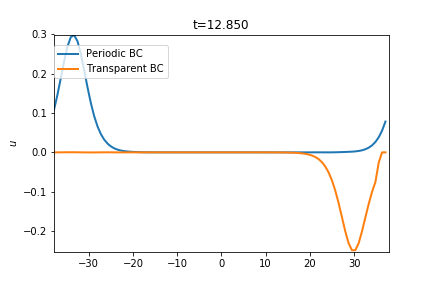
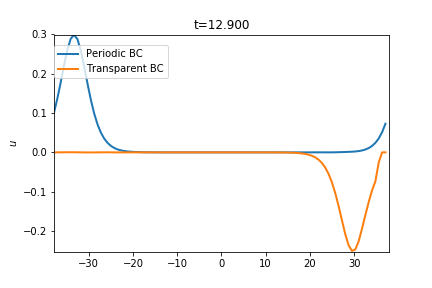
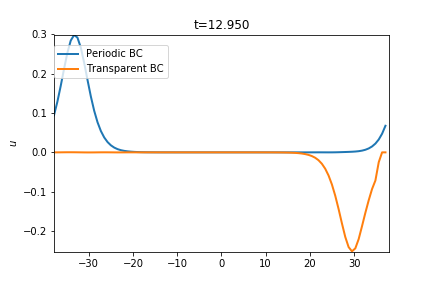
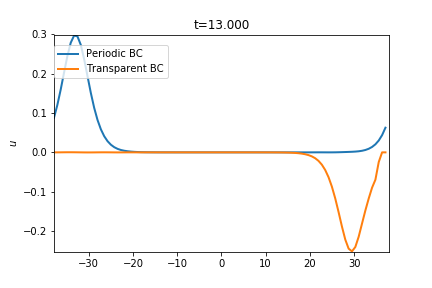
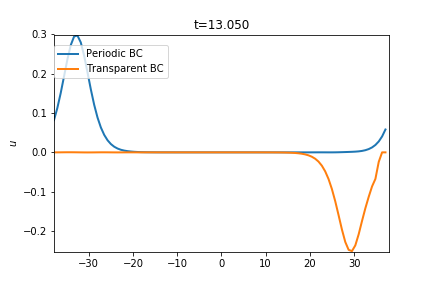
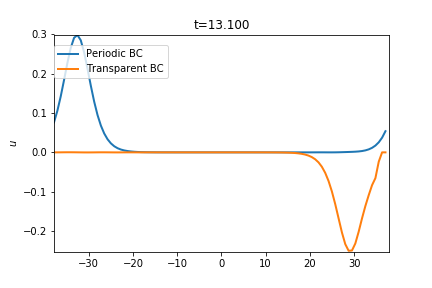
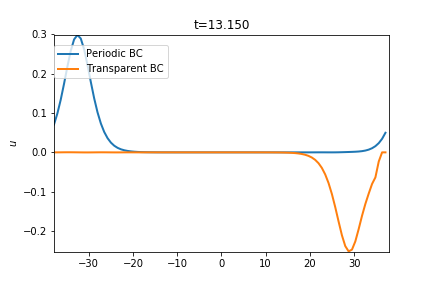
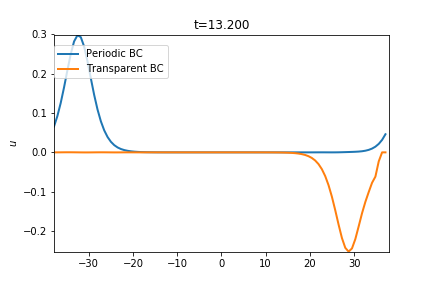
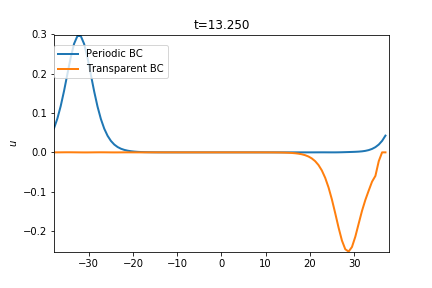
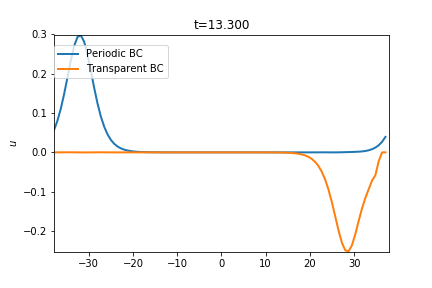
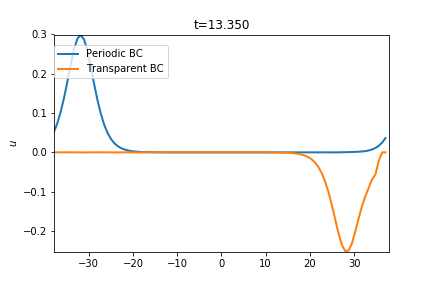
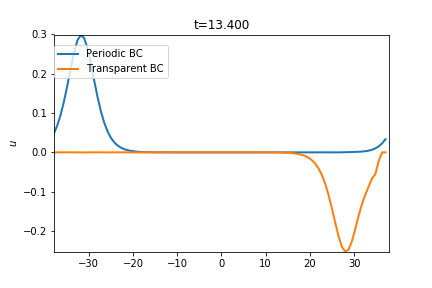
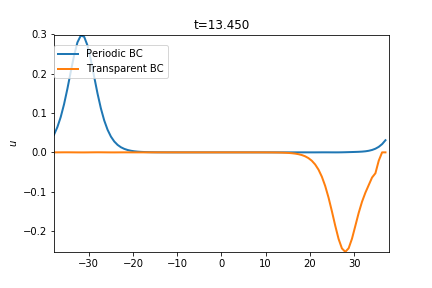
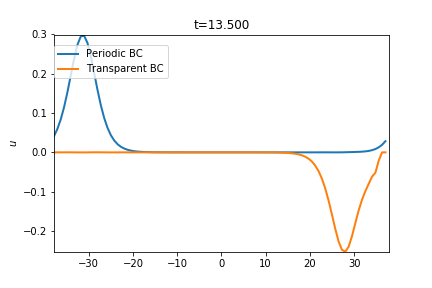
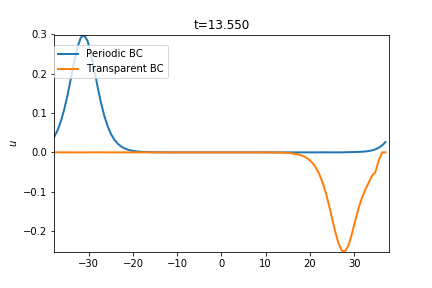
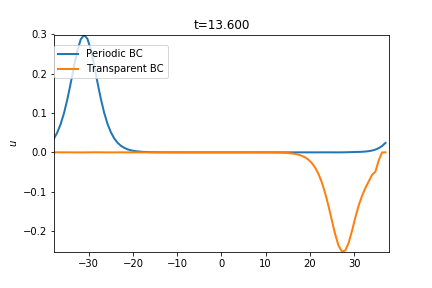
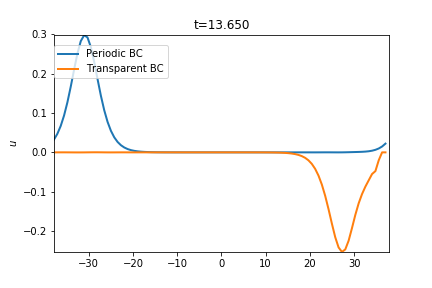
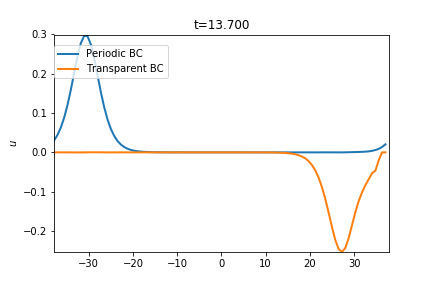
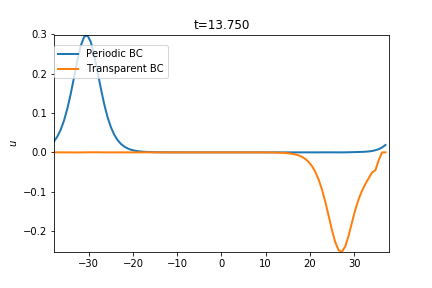
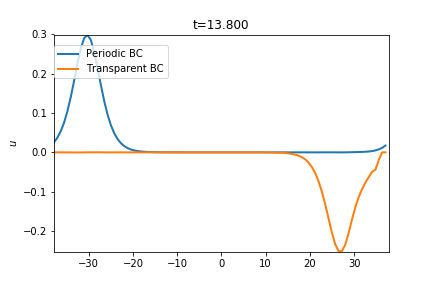
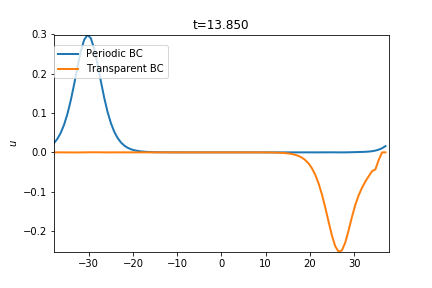
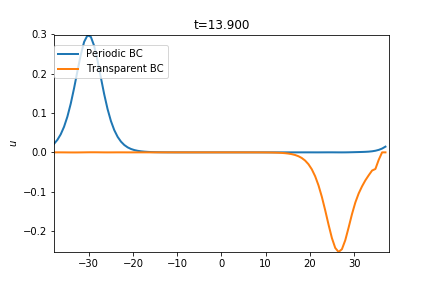
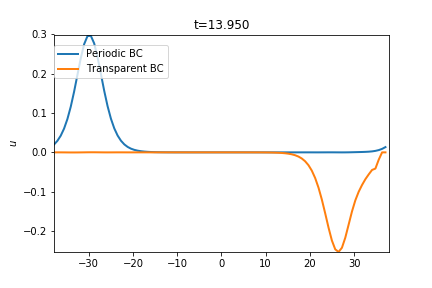
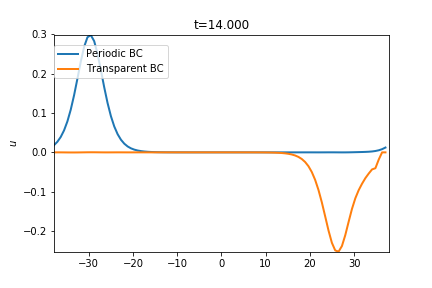
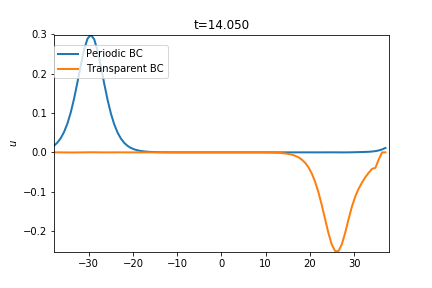
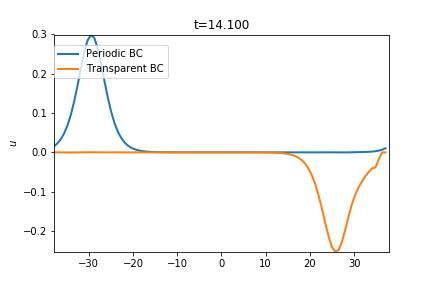
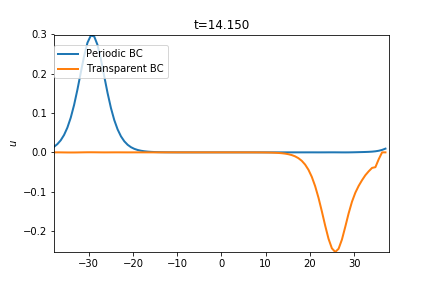
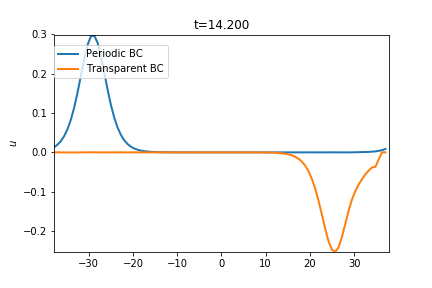
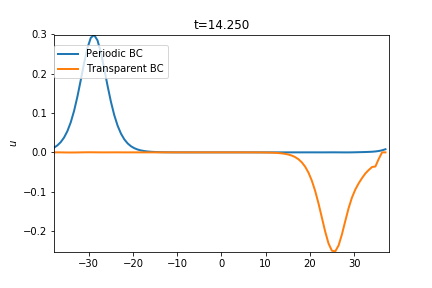
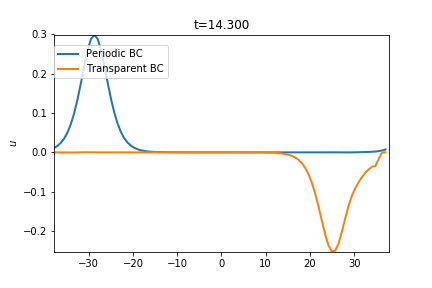
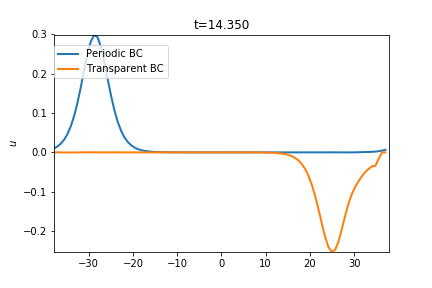
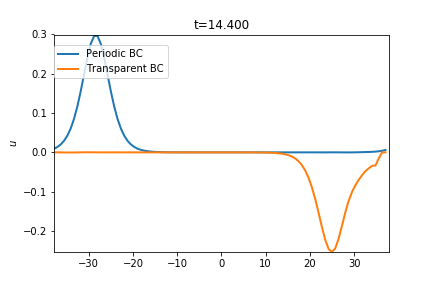
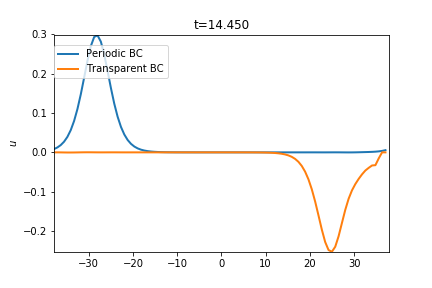
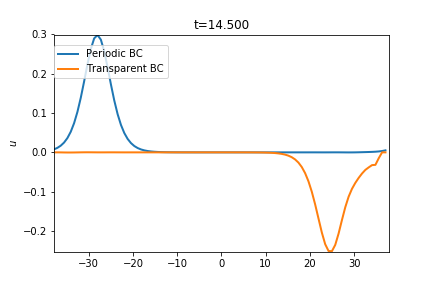
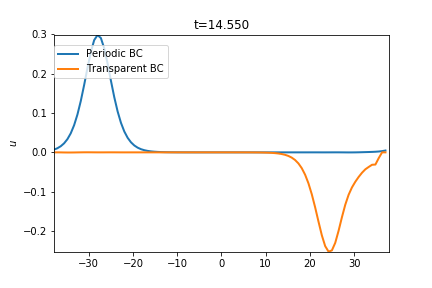
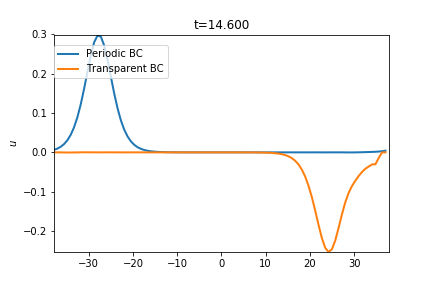
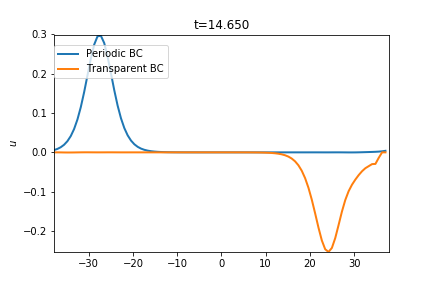
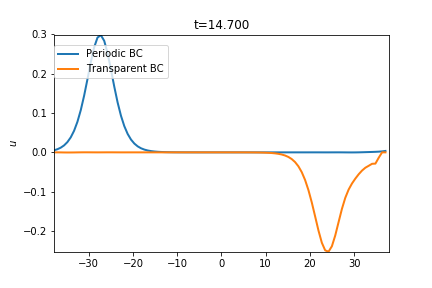
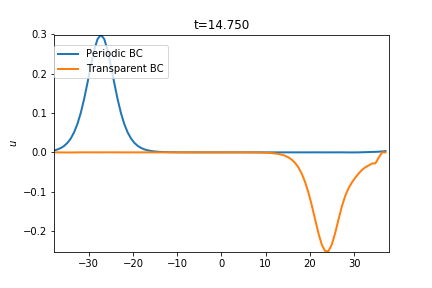
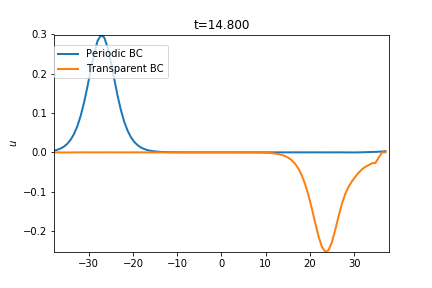
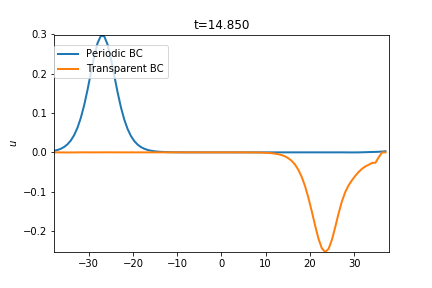
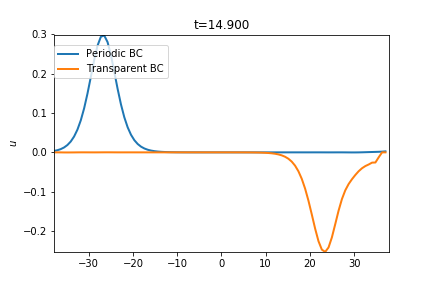
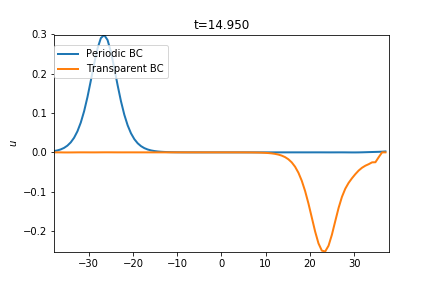
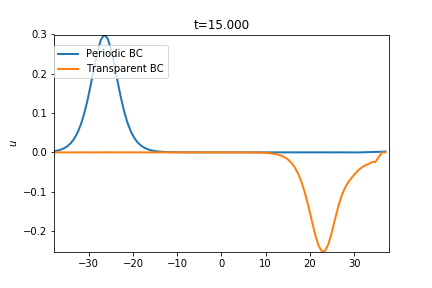
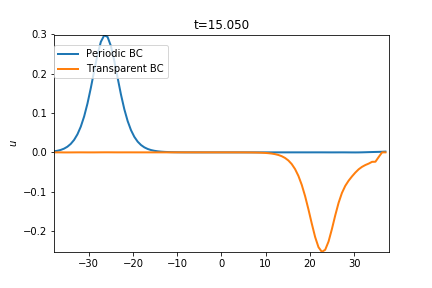
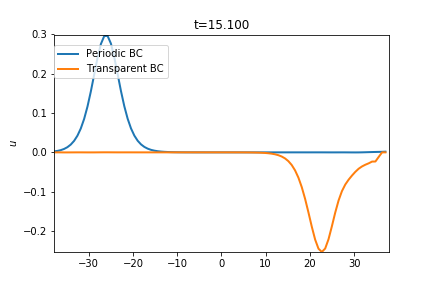
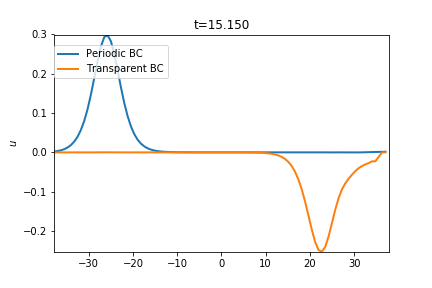
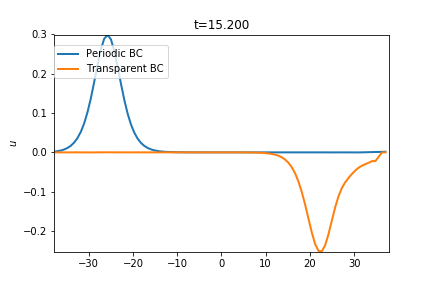
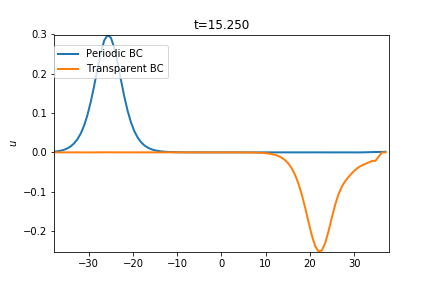
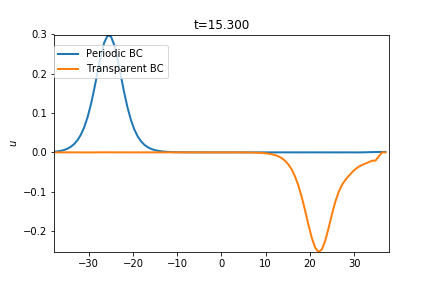
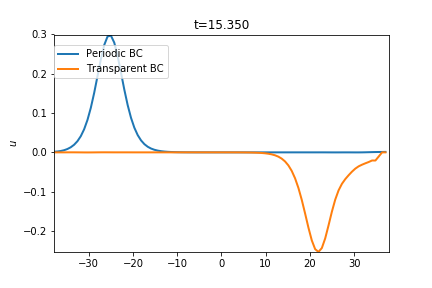
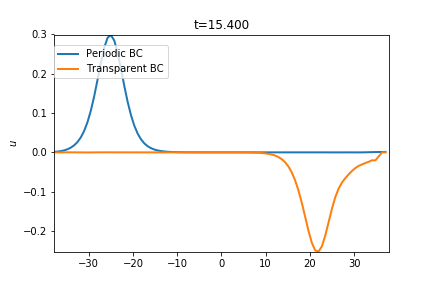
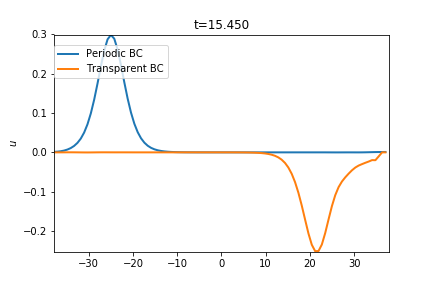
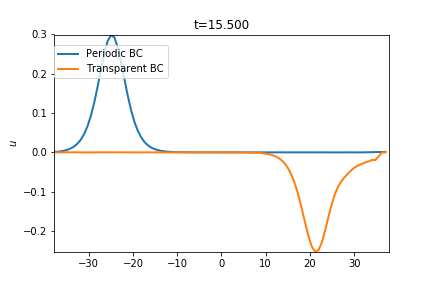
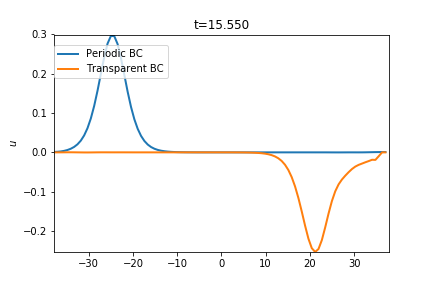
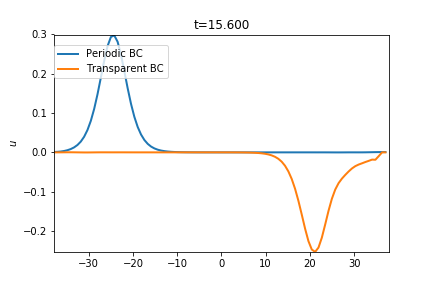
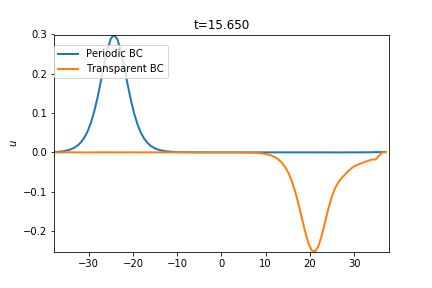
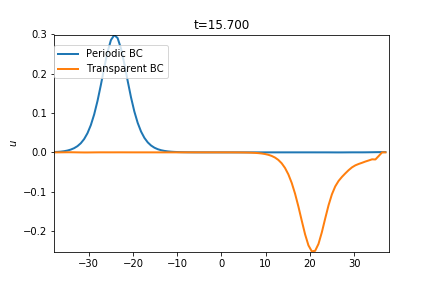
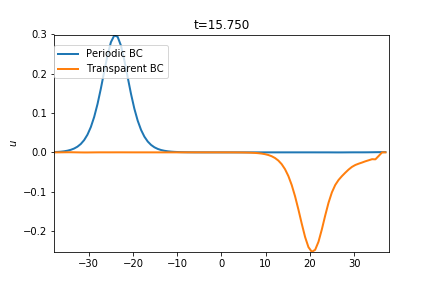
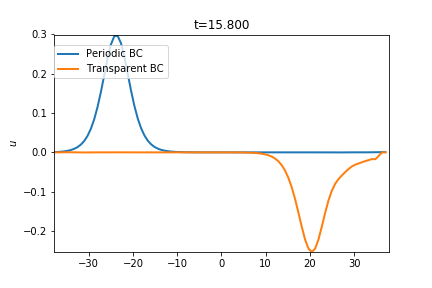
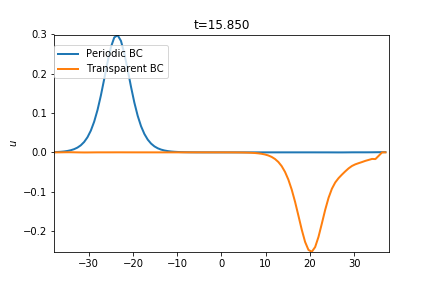
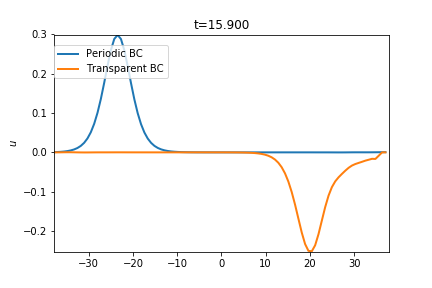
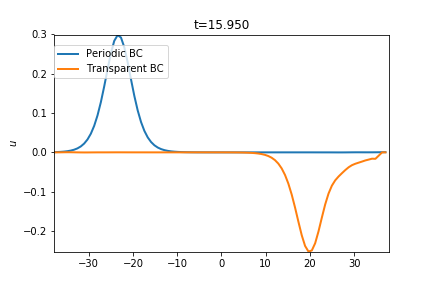
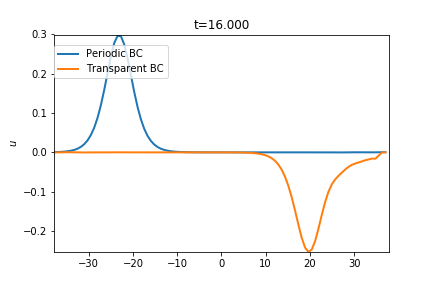
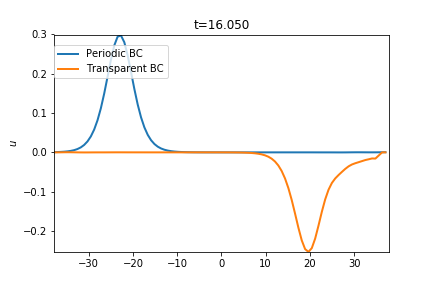
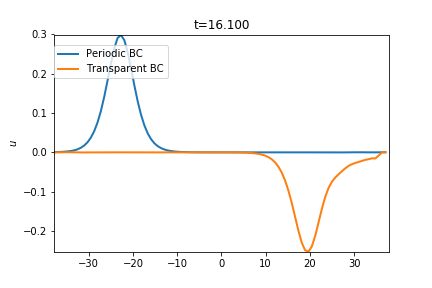
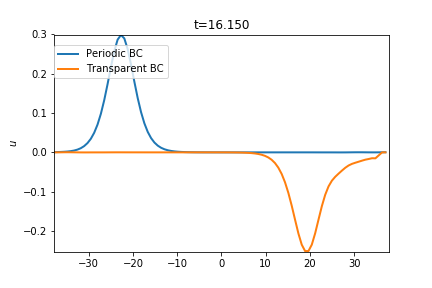
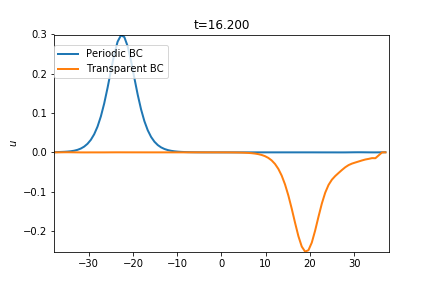
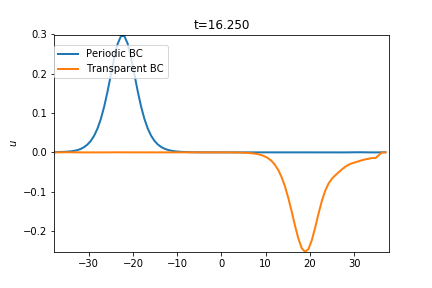
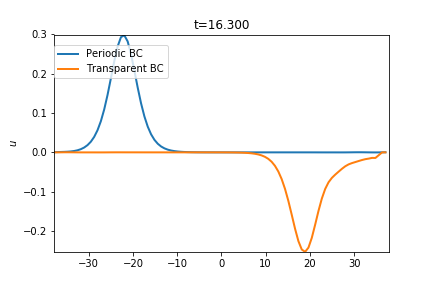
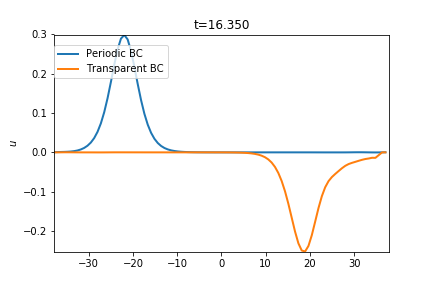
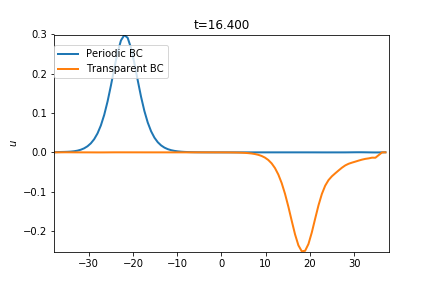
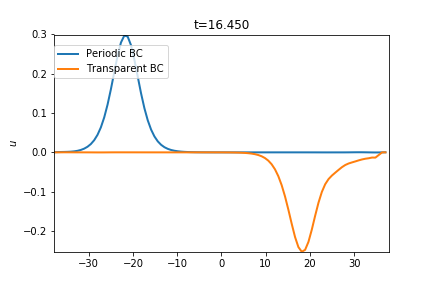
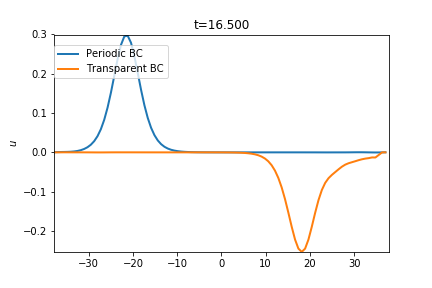
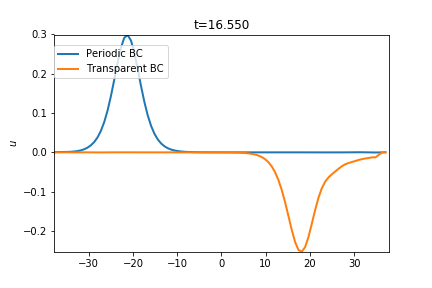
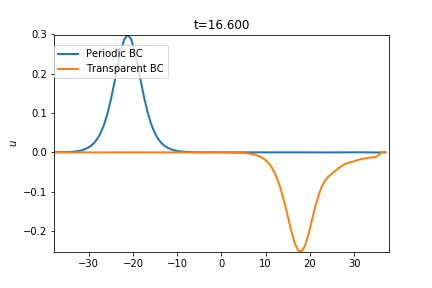
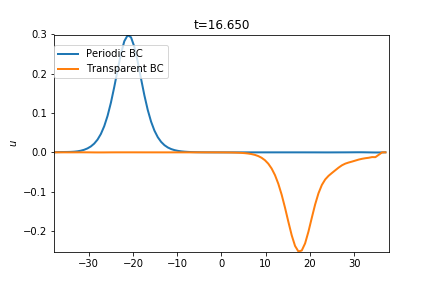
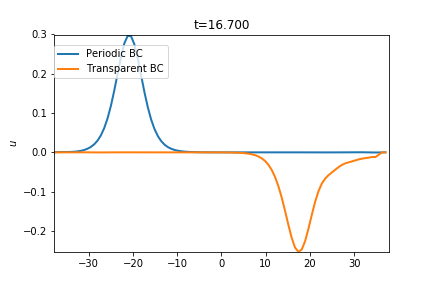
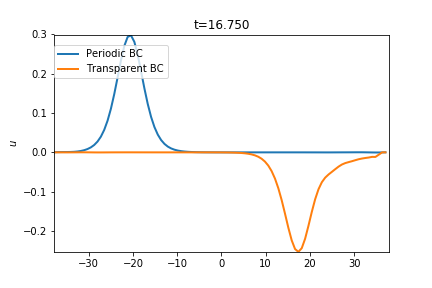
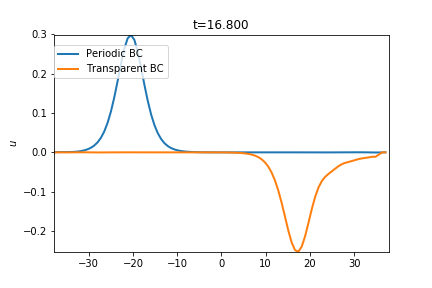
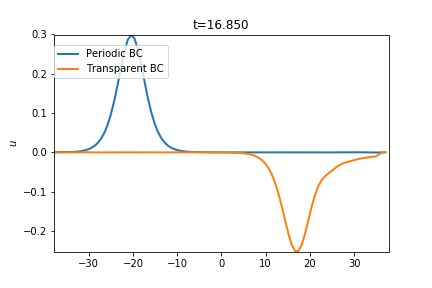
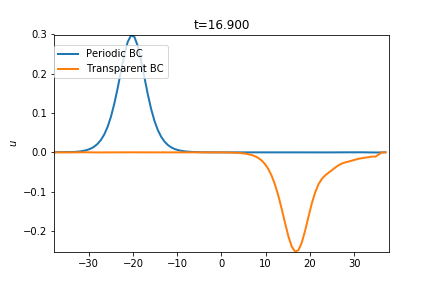
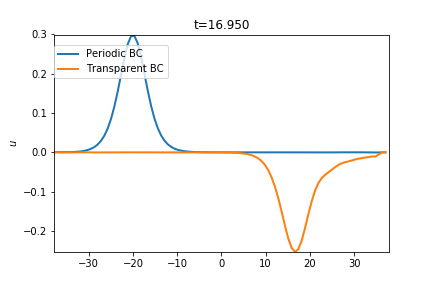
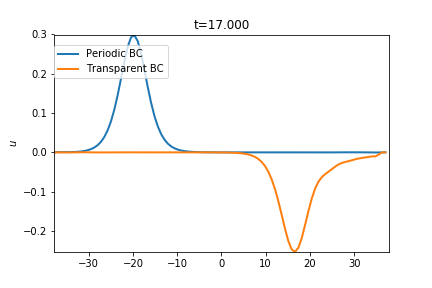
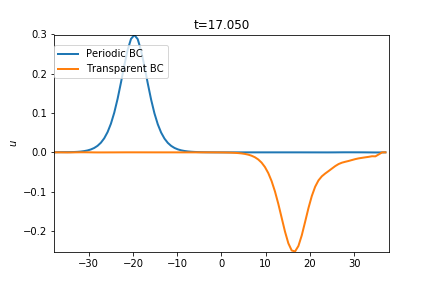
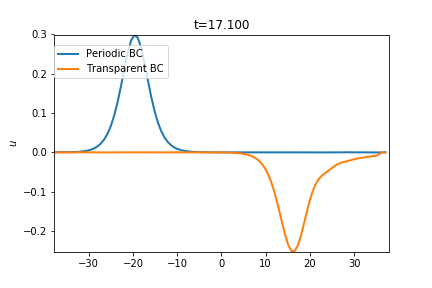
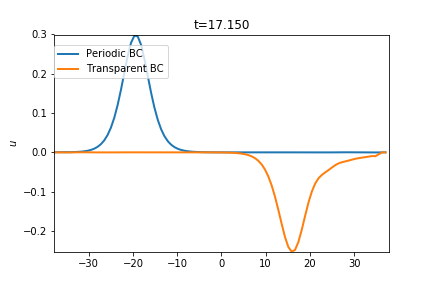
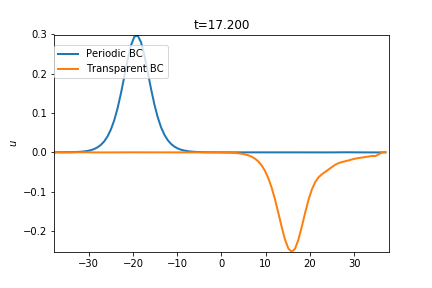
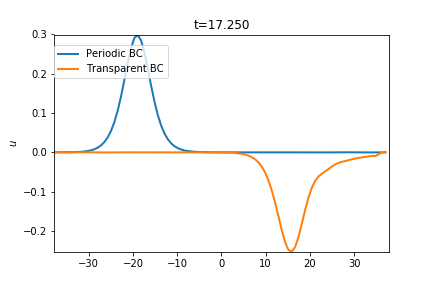
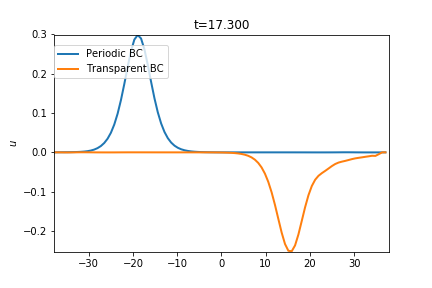
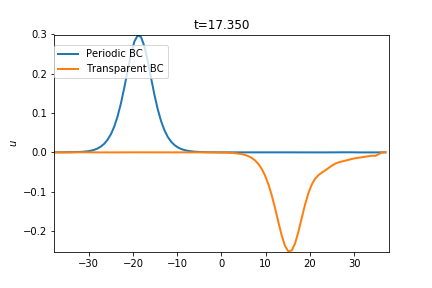
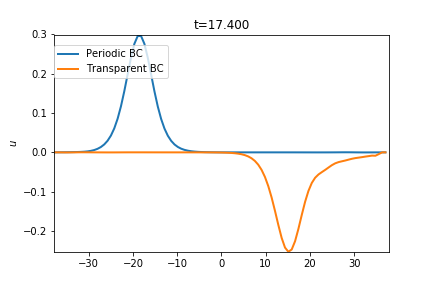
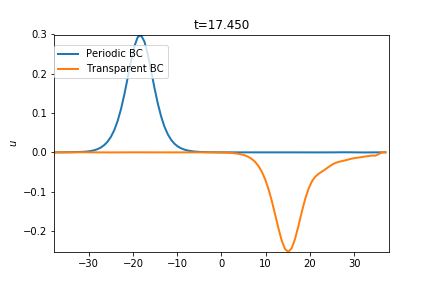
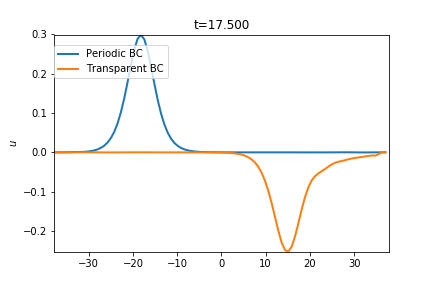
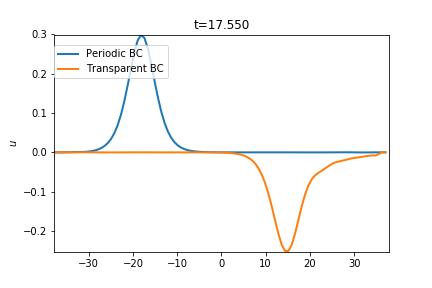
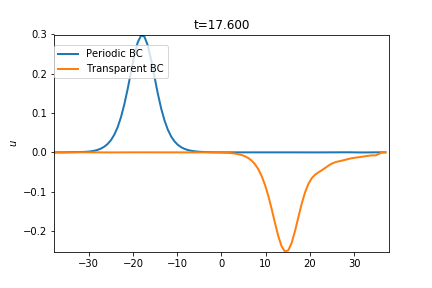
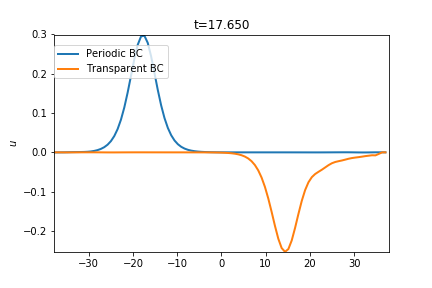
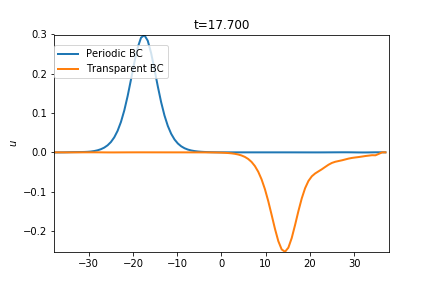
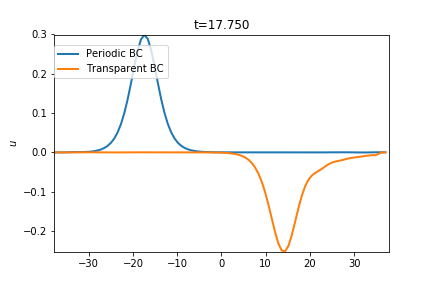
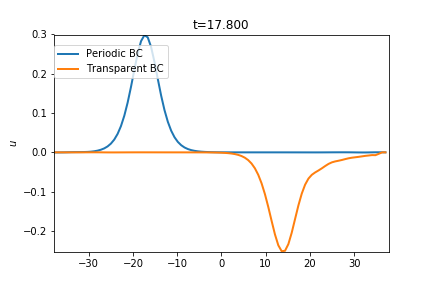
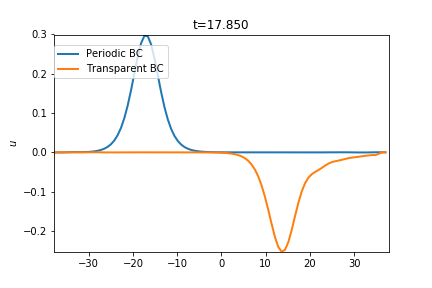
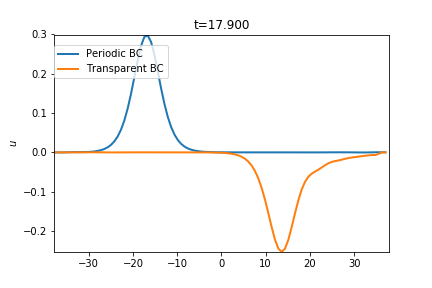
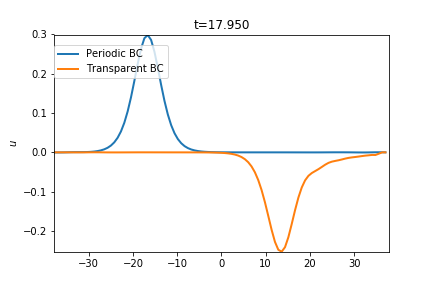
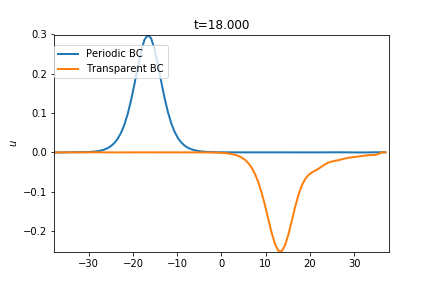
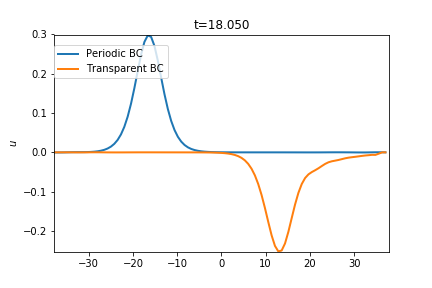
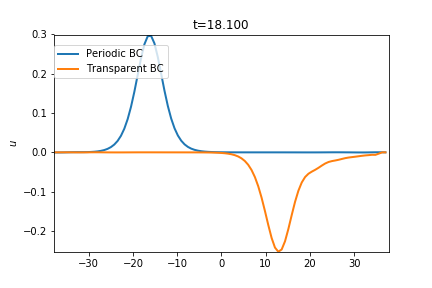
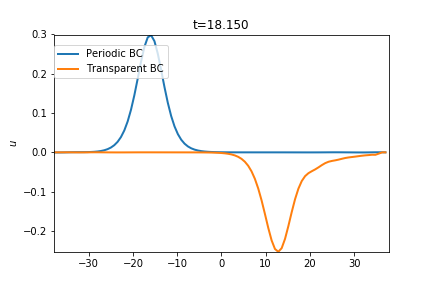
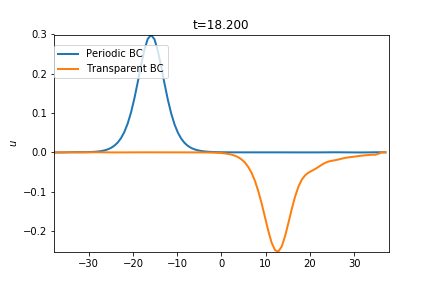
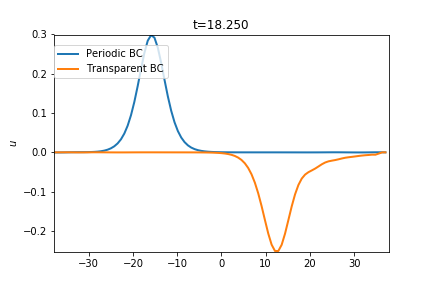
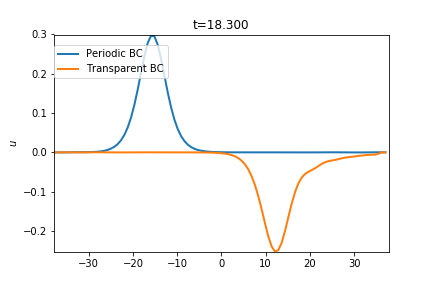
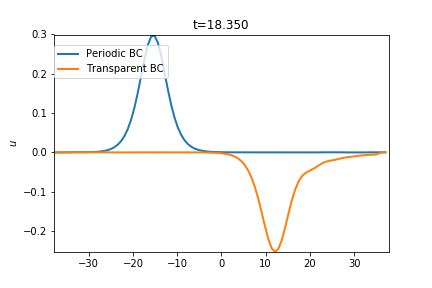
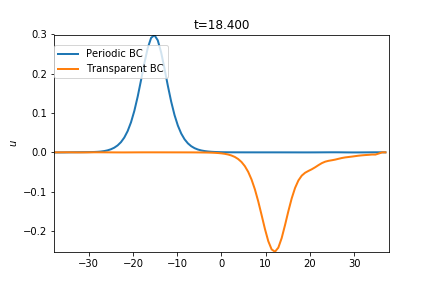
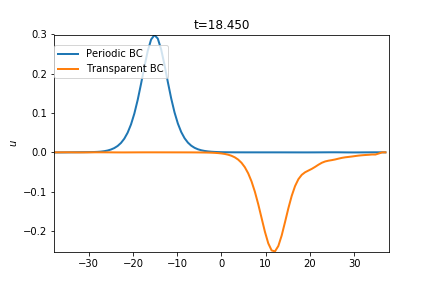
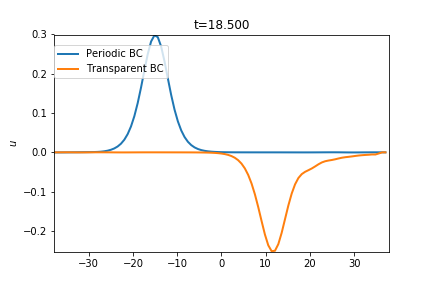
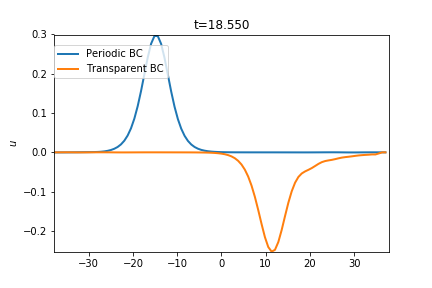
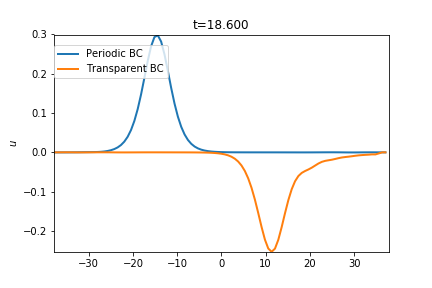
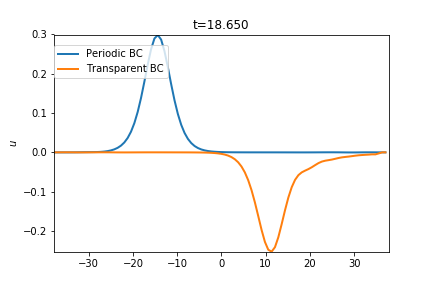
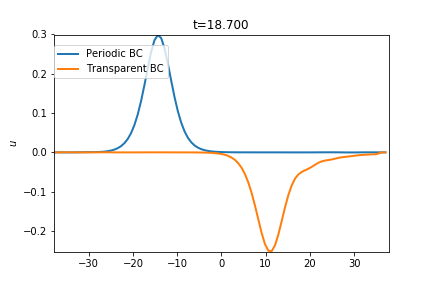
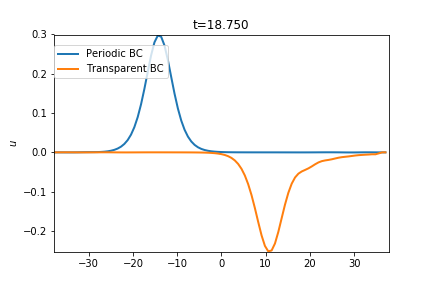
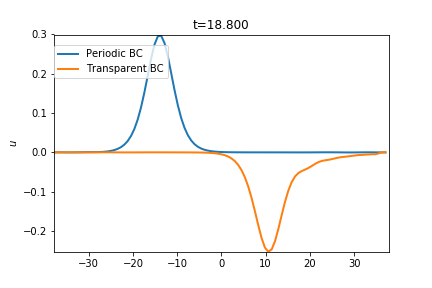
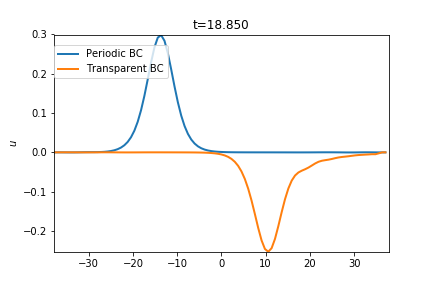
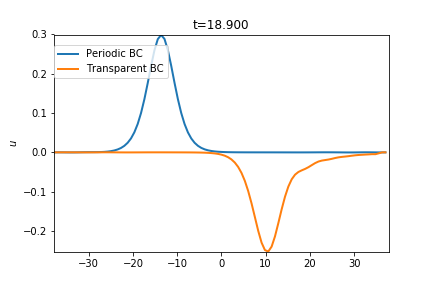
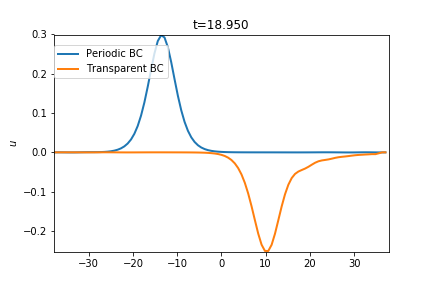
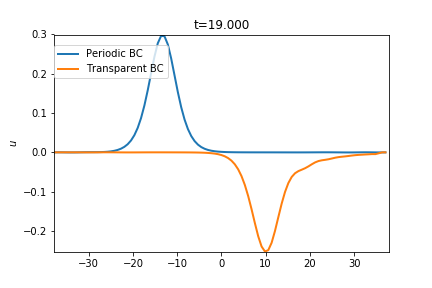
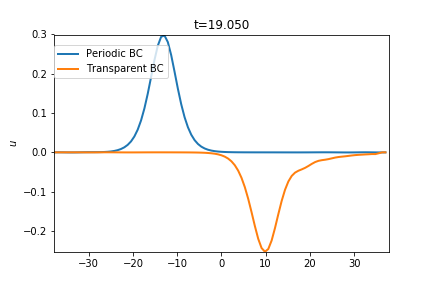
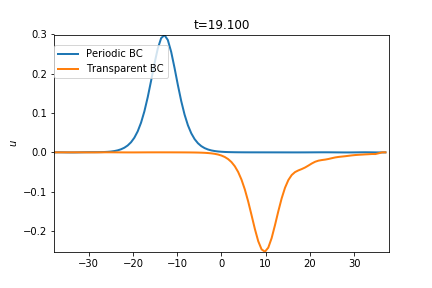
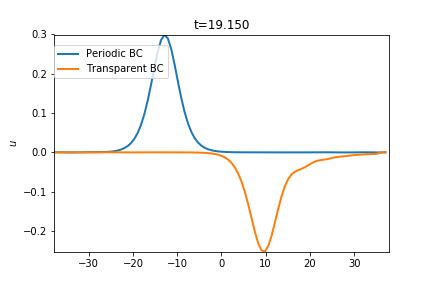
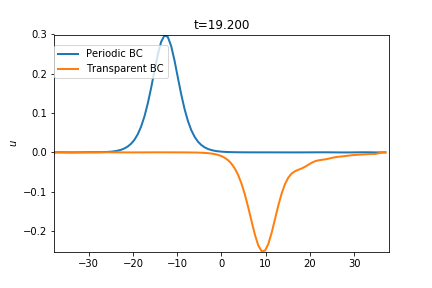
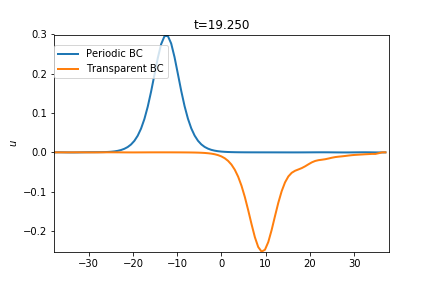
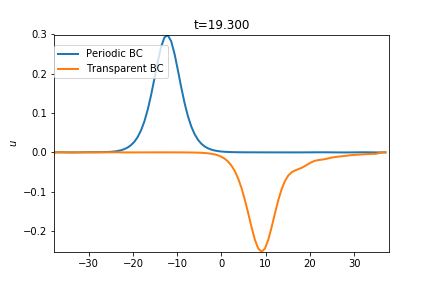
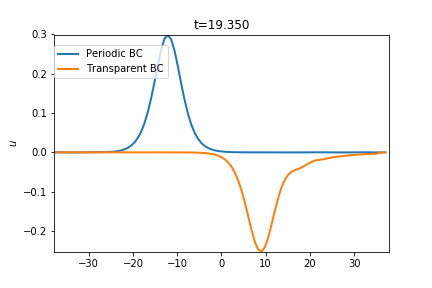
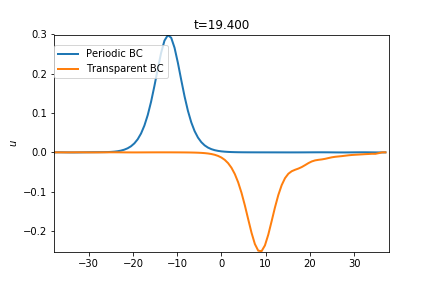
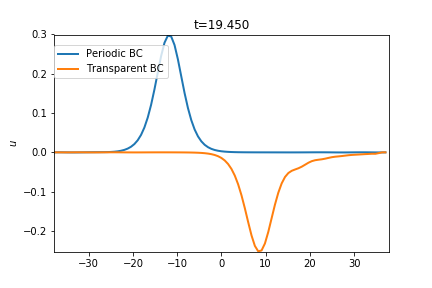
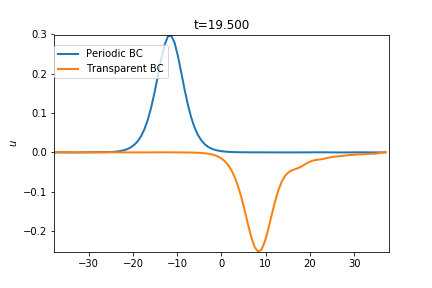
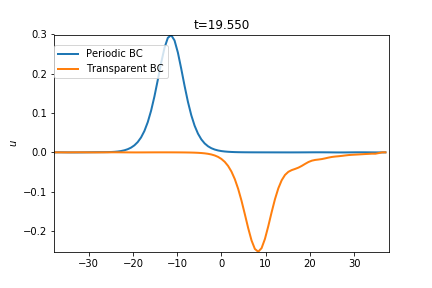
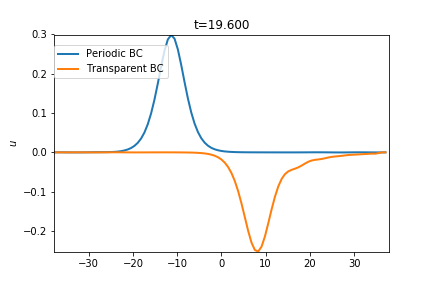
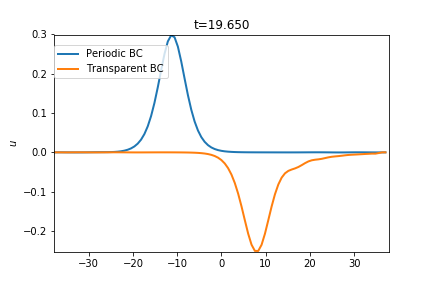
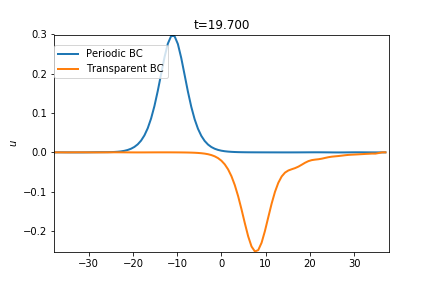
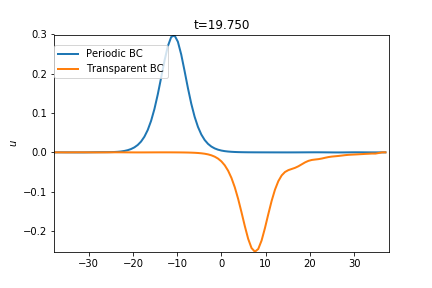
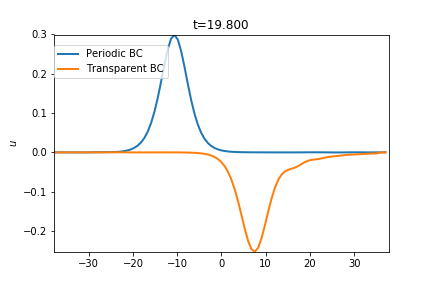
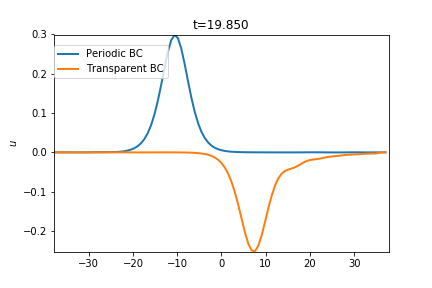
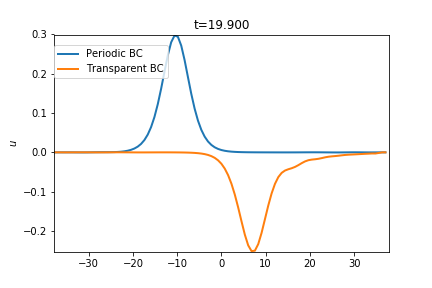
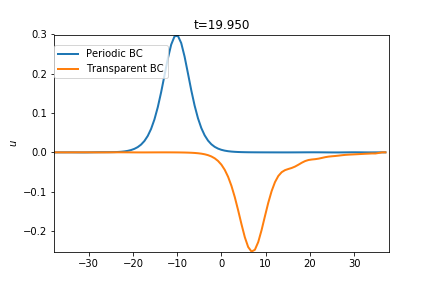
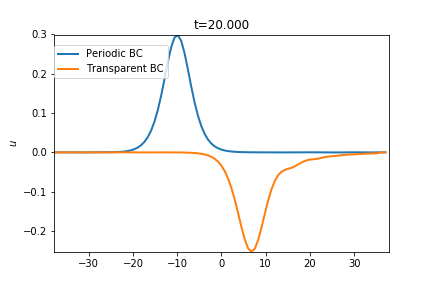

In [31]:
lb = ["Periodic BC", "Transparent BC"]
save = "./u_full_serre_TBC.mp4"
# save = None
ng = 2
# gF.plotAnimationNSolutions(2,x[ng:-ng],np.array([uall1[ng:-ng,:],uall2[ng:-ng,:]]),tall1,xmin,xmax,umin,umax,lb,ylabel=r'$h$',location=(0.,0.8),savePath=save)
gF.plotAnimationNSolutions(2,x,np.array([uall1[ng:-ng],uall2]),tall1,xmin,xmax,umin,umax,lb,ylabel=r'$u$',location=(0.,0.8),savePath=save)

In [32]:
# gF.plotAnimationNSolutions(2,x[ng:-ng],np.array([hall1[ng:-ng,:],hall2[ng:-ng,:]]),tall1,xmin,xmax,hmin,hmax,lb,ylabel=r'$h$',location=(0.,0.8))
gF.plotAnimationNSolutions(2,x,np.array([hall1[ng:-ng],hall2]),tall1,xmin,xmax,hmin,hmax,lb,ylabel=r'$h$',location=(0.,0.8))

*** Plotting animation ...


KeyboardInterrupt: 

In [ ]:
# label = np.array(["Serre","NSWE","Analytical"])
loc=(.7,.7)
case = "gaussian"
label = lb
gF.saveSnapshotNsolutions(2,0,x,np.array([hall1[ng:-ng],hall2]),tall1,label,"$x$","$h$","../figures/Serre/"+case+"1h",ext="png", legloc=loc)
gF.saveSnapshotNsolutions(2,0,x,np.array([uall1[ng:-ng],uall2]),tall1,label,"$x$","$u$","../figures/Serre/"+case+"1u",ext="png", legloc=loc)
it = np.argmin(np.absolute(tall1-10.))
gF.saveSnapshotNsolutions(2,it,x,np.array([hall1[ng:-ng],hall2]),tall1,label,"$x$","$h$","../figures/Serre/"+case+"2h",ext="png", legloc=loc)
gF.saveSnapshotNsolutions(2,it,x,np.array([uall1[ng:-ng],uall2]),tall1,label,"$x$","$u$","../figures/Serre/"+case+"2u",ext="png", legloc=loc)
gF.saveSnapshotNsolutions(2,-1,x,np.array([hall1[ng:-ng],hall2]),tall1,label,"$x$","$h$","../figures/Serre/"+case+"3h",ext="png", legloc=loc)
gF.saveSnapshotNsolutions(2,-1,x,np.array([uall1[ng:-ng],uall2]),tall1,label,"$x$","$u$","../figures/Serre/"+case+"3u",ext="png", legloc=loc)